# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 # 4 hours / 72*5min = 6 hours used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 32
TRAIN_SPLIT_RATIO = 0.8 #0.9891 # 1-(60/5*24)/50977
MODE_TRAIN_AE = False #  True
MODE_AUTO_SELECT = 2 #1 #   #0 # 0: False, 1: True, 2: from disk

MODE_TRAIN_PREDICTOR = False # False

MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_80765/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
69660  1693429200000   1703.84   1704.72  1703.53    1704.42    304.2080   
69661  1693429500000   1704.42   1705.32  1704.34    1705.21    128.5311   
69662  1693429800000   1705.21   1708.34  1705.20    1706.61   1255.5185   
69663  1693430100000   1706.61   1707.69  1705.42    1705.56    412.1529   
69664  1693430400000   1705.56   1705.56  1704.01    1704.01    457.8109   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1749.198952       1748.674891   
1      2023-01-01 00:05:00       1749.198952       1748.674891   
2      2023-01-01 00:10:00       1749.198952       1748.674891   
3      2023-01-01 00:15:00       1749.198952       1748.674891   
4      2023-01-01 00:20:00       1749.198952       1748.674891   
...                    ...               ...               ...   
69660  2023-08-30 21:00:00       1700.075000       1704.125000   
69661  2023-08-30 21:05:00       1701.070000       1702.925000   
69662  2023-08-30 21:10:00       1701.070000       1702.645000   
69663  2023-08-30 21:15:00       1701.070000       1701.820000   
69664  2023-08-30 21:20:00       1701.077500       1702.245000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
69660        1703.760  ...   NaN         NaN            NaN           NaN   
69661        1703.760  ...   NaN         NaN            NaN           NaN   
69662        1704.895  ...   NaN         NaN            NaN           NaN   
69663        1704.895  ...   NaN         NaN            NaN           NaN   
69664        1704.895  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
69660               NaN         0.0               NaN         0.0      0.0   
69661               NaN         0.0               NaN         0.0      0.0   
69662               NaN         0.0               NaN         0.0      0.0   
69663               NaN         0.0               NaN         0.0      0.0   
69664               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
69660   NaN  
69661   NaN  
69662   NaN  
69663   NaN  
69664   NaN  

[69665 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_BTC            1
vwap_z_score_ETH            1
ichi_tenkan_BTC             8
ichi_tenkan_ETH             8
min_low_h_BTC              13
rsi_h_BTC                  13
max_high_h_ETH             13
min_low_h_ETH              13
rsi_h_ETH                  13
max_high_h_BTC             13
chop_h_BTC                 14
chop_h_ETH                 14
ichi_cloud_a_ETH           25
ichi_kijun_ETH             25
ichi_kijun_BTC             25
ichi_cloud_a_BTC           25
ichi_tenkan_day_BTC       215
ichi_tenkan_day_ETH       215
dxy                       264
rsi_d_ETH                 335
min_low_d_BTC             335
rsi_d_BTC                 335
max_high_d_ETH            335
min_low_d_ETH             335
max_high_d_BTC            335
chop_d_ETH                335
chop_d_BTC                335
ichi_kijun_day_ETH        623
ichi_cloud_a_day_ETH      623
ichi_kijun_day_BTC        623
ichi_cloud_a_day_BTC      623
fvx                       732
spx                     

#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
69660  1693429200000   1703.84   1704.72  1703.53    1704.42    304.2080   
69661  1693429500000   1704.42   1705.32  1704.34    1705.21    128.5311   
69662  1693429800000   1705.21   1708.34  1705.20    1706.61   1255.5185   
69663  1693430100000   1706.61   1707.69  1705.42    1705.56    412.1529   
69664  1693430400000   1705.56   1705.56  1704.01    1704.01    457.8109   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1749.198952       1748.674891   
1      2023-01-01 00:05:00       1749.198952       1748.674891   
2      2023-01-01 00:10:00       1749.198952       1748.674891   
3      2023-01-01 00:15:00       1749.198952       1748.674891   
4      2023-01-01 00:20:00       1749.198952       1748.674891   
...                    ...               ...               ...   
69660  2023-08-30 21:00:00       1700.075000       1704.125000   
69661  2023-08-30 21:05:00       1701.070000       1702.925000   
69662  2023-08-30 21:10:00       1701.070000       1702.645000   
69663  2023-08-30 21:15:00       1701.070000       1701.820000   
69664  2023-08-30 21:20:00       1701.077500       1702.245000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...   1.0         0.0            0.0           0.0   
1            1194.710  ...   1.0         0.0            0.0           0.0   
2            1194.710  ...   1.0         0.0            0.0           0.0   
3            1194.710  ...   1.0         0.0            0.0           0.0   
4            1194.710  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
69660        1703.760  ...   NaN         NaN            NaN           NaN   
69661        1703.760  ...   NaN         NaN            NaN           NaN   
69662        1704.895  ...   NaN         NaN            NaN           NaN   
69663        1704.895  ...   NaN         NaN            NaN           NaN   
69664        1704.895  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
69660               NaN         0.0               NaN         0.0      0.0   
69661               NaN         0.0               NaN         0.0      0.0   
69662               NaN         0.0               NaN         0.0      0.0   
69663               NaN         0.0               NaN         0.0      0.0   
69664               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
69660                  NaN  
69661                  NaN  
69662                  NaN  
69663                  NaN  
69664                  NaN  

[69665 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       5572
delta_event_real    5572
delta_event_pred    5572
Previous_num        5572
Actual_num          5572
Event               5572
Date                5572
Previous            5572
Consensus           5572
Actual              5572
Country             5572
Time (ET)           5572
keep                5572
date                5572
dtype: int64

on 69665 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
69660   1703.84   1704.72  1703.53    1704.42    304.2080   
69661   1704.42   1705.32  1704.34    1705.21    128.5311   
69662   1705.21   1708.34  1705.20    1706.61   1255.5185   
69663   1706.61   1707.69  1705.42    1705.56    412.1529   
69664   1705.56   1705.56  1704.01    1704.01    457.8109   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1749.198952       1748.674891   
1      2023-01-01 00:05:00       1749.198952       1748.674891   
2      2023-01-01 00:10:00       1749.198952       1748.674891   
3      2023-01-01 00:15:00       1749.198952       1748.674891   
4      2023-01-01 00:20:00       1749.198952       1748.674891   
...                    ...               ...               ...   
69660  2023-08-30 21:00:00       1700.075000       1704.125000   
69661  2023-08-30 21:05:00       1701.070000       1702.925000   
69662  2023-08-30 21:10:00       1701.070000       1702.645000   
69663  2023-08-30 21:15:00       1701.070000       1701.820000   
69664  2023-08-30 21:20:00       1701.077500       1702.245000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0            1194.710         1194.710  ...  1196.096667  1196.096667   
1            1194.710         1194.710  ...  1195.801420  1195.801420   
2            1194.710         1194.710  ...  1195.648641  1195.648641   
3            1194.710         1194.710  ...  1195.575250  1195.575250   
4            1194.710         1194.710  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
69660        1703.760         1704.390  ...  1696.973584  1806.063774   
69661        1703.760         1704.390  ...  1696.971505  1806.059846   
69662        1704.895         1705.525  ...  1696.971454  1806.047957   
69663        1704.895         1705.525  ...  1696.966050  1806.043769   
69664        1704.895         1705.525  ...  1696.965577  1806.038586   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
69660  1823.915618  1742.266627   1731.285645         -0.155713 -0.015762   
69661  1823.915099  1742.257362   1731.285610         -0.151135 -0.015292   
69662  1823.909924  1742.245070   1731.285296         -0.143020 -0.014459   
69663  1823.908158  1742.237052   1731.285191         -0.149106 -0.015083   
69664  1823.905976  1742.229338   1731.285066         -0.158090 -0.016006   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.205254e+08      522461.0       17.891530  
1      1.205254e+08      522461.0       17.891530  
2      1.205254e+08      522461.0       17.891530  
3      1.205254e+08      522461.0       17.891530  
4      1.205254e+08      522461.0       17.891530  
...             ...           ...             ...  
69660  1.202138e+08      412992.0       18.316148  
69661  1.202138e+08      412992.0       18.316148  
69662  1.202138e+08      412992.0       18.316148  
69663  1.202138e+08      412992.0       18.316148  
69664  1.202138e+08      412992.0       18.316148  

[69665 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0      3.910  3823.179932  103.494003
1      3.910  3823.179932  103.494003
2      3.910  3823.179932  103.494003
3      3.910  3823.179932  103.494003
4      3.910  3823.179932  103.494003
...      ...          ...         ...
69660  4.273  4514.870117  103.148003
69661  4.273  4514.870117  103.148003
69662  4.273  4514.870117  103.148003
69663  4.273  4514.870117  103.148003
69664  4.273  4514.870117  103.148003

[69665 rows x 3 columns]

In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  102


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [27]:
df_feat.shape[0]

69665

In [28]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

55732

In [29]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
69660  1693429200000   1703.84   1704.72  1703.53    1704.42    304.2080   
69661  1693429500000   1704.42   1705.32  1704.34    1705.21    128.5311   
69662  1693429800000   1705.21   1708.34  1705.20    1706.61   1255.5185   
69663  1693430100000   1706.61   1707.69  1705.42    1705.56    412.1529   
69664  1693430400000   1705.56   1705.56  1704.01    1704.01    457.8109   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1749.198952       1748.674891   
1      2023-01-01 00:05:00       1749.198952       1748.674891   
2      2023-01-01 00:10:00       1749.198952       1748.674891   
3      2023-01-01 00:15:00       1749.198952       1748.674891   
4      2023-01-01 00:20:00       1749.198952       1748.674891   
...                    ...               ...               ...   
69660  2023-08-30 21:00:00       1700.075000       1704.125000   
69661  2023-08-30 21:05:00       1701.070000       1702.925000   
69662  2023-08-30 21:10:00       1701.070000       1702.645000   
69663  2023-08-30 21:15:00       1701.070000       1701.820000   
69664  2023-08-30 21:20:00       1701.077500       1702.245000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
69660        1703.760  ...         NaN            NaN           NaN   
69661        1703.760  ...         NaN            NaN           NaN   
69662        1704.895  ...         NaN            NaN           NaN   
69663        1704.895  ...         NaN            NaN           NaN   
69664        1704.895  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
69660               NaN         0.0               NaN         0.0      0.0   
69661               NaN         0.0               NaN         0.0      0.0   
69662               NaN         0.0               NaN         0.0      0.0   
69663               NaN         0.0               NaN         0.0      0.0   
69664               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
69660                  NaN  False  
69661                  NaN  False  
69662                  NaN  False  
69663                  NaN  False  
69664                  NaN  False  

[69665 rows x 136 columns]

In [30]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
55728  1689249600000   1883.72   1885.08  1883.71    1884.05    417.2182   
55729  1689249900000   1884.06   1884.06  1883.23    1883.27    453.4697   
55730  1689250200000   1883.27   1884.60  1883.26    1884.05    343.2436   
55731  1689250500000   1884.05   1884.20  1883.28    1883.28    367.4170   
55732  1689250800000   1883.29   1883.29  1881.36    1881.60    680.0444   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1749.198952       1748.674891   
1      2023-01-01 00:05:00       1749.198952       1748.674891   
2      2023-01-01 00:10:00       1749.198952       1748.674891   
3      2023-01-01 00:15:00       1749.198952       1748.674891   
4      2023-01-01 00:20:00       1749.198952       1748.674891   
...                    ...               ...               ...   
55728  2023-07-13 12:00:00       1878.452500       1874.750000   
55729  2023-07-13 12:05:00       1878.567500       1874.750000   
55730  2023-07-13 12:10:00       1878.567500       1874.985000   
55731  2023-07-13 12:15:00       1878.567500       1874.985000   
55732  2023-07-13 12:20:00       1878.650000       1874.985000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
55728        1882.655  ...         0.1            0.2          -0.4   
55729        1882.655  ...         0.1            0.2          -0.4   
55730        1882.655  ...         0.1            0.2          -0.4   
55731        1882.655  ...         0.1            0.2          -0.4   
55732        1882.655  ...         0.1            0.2          -0.4   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
55728              -0.6         0.0               0.1         0.0      0.0   
55729              -0.6         0.0               0.1         0.0      0.0   
55730              -0.6         0.0               0.1         0.0      0.0   
55731              -0.6         0.0               0.1         0.0      0.0   
55732              -0.6         0.0               0.1         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
55728  2023-07-13 13:00:00   True  
55729  2023-07-13 13:00:00   True  
55730  2023-07-13 13:00:00   True  
55731  2023-07-13 13:00:00   True  
55732  2023-07-13 13:00:00   True  

[55733 rows x 136 columns]

In [31]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
55733  1689251100000   1881.60   1882.29  1880.60    1880.89    831.6705   
55734  1689251400000   1880.89   1883.06  1877.36    1877.36   1293.1933   
55735  1689251700000   1877.36   1879.77  1876.11    1878.88   1151.6127   
55736  1689252000000   1878.87   1882.86  1878.67    1882.85    648.7949   
55737  1689252300000   1882.85   1883.93  1882.34    1882.75    653.9686   
...              ...       ...       ...      ...        ...         ...   
69660  1693429200000   1703.84   1704.72  1703.53    1704.42    304.2080   
69661  1693429500000   1704.42   1705.32  1704.34    1705.21    128.5311   
69662  1693429800000   1705.21   1708.34  1705.20    1706.61   1255.5185   
69663  1693430100000   1706.61   1707.69  1705.42    1705.56    412.1529   
69664  1693430400000   1705.56   1705.56  1704.01    1704.01    457.8109   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
55733  2023-07-13 12:25:00         1879.2050          1874.985   
55734  2023-07-13 12:30:00         1879.7600          1874.985   
55735  2023-07-13 12:35:00         1879.8850          1874.985   
55736  2023-07-13 12:40:00         1879.8125          1874.985   
55737  2023-07-13 12:45:00         1879.8525          1874.985   
...                    ...               ...               ...   
69660  2023-08-30 21:00:00         1700.0750          1704.125   
69661  2023-08-30 21:05:00         1701.0700          1702.925   
69662  2023-08-30 21:10:00         1701.0700          1702.645   
69663  2023-08-30 21:15:00         1701.0700          1701.820   
69664  2023-08-30 21:20:00         1701.0775          1702.245   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
55733        1882.655  ...         0.1            0.2          -0.4   
55734        1881.285  ...         0.1            0.2          -0.4   
55735        1880.660  ...         0.1            0.2          -0.4   
55736        1880.660  ...         0.1            0.2          -0.4   
55737        1880.660  ...         0.1            0.2          -0.4   
...               ...  ...         ...            ...           ...   
69660        1703.760  ...         NaN            NaN           NaN   
69661        1703.760  ...         NaN            NaN           NaN   
69662        1704.895  ...         NaN            NaN           NaN   
69663        1704.895  ...         NaN            NaN           NaN   
69664        1704.895  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
55733              -0.6         0.0               0.1         0.0      0.0   
55734              -0.6         0.0               0.1         0.0      0.0   
55735              -0.6         0.0               0.1         0.0      0.0   
55736              -0.6         0.0               0.1         0.0      0.0   
55737              -0.6         0.0               0.1         0.0      0.0   
...                 ...         ...               ...         ...      ...   
69660               NaN         0.0               NaN         0.0      0.0   
69661               NaN         0.0               NaN         0.0      0.0   
69662               NaN         0.0               NaN         0.0      0.0   
69663               NaN         0.0               NaN         0.0      0.0   
69664               NaN         0.0               NaN         0.0      0.0   

                      date  train  
55733  2023-07-13 13:00:00  False  
55734  2023-07-13 13:00:00  False  
55735  2023-07-13 13:00:00  False  
55736  2023-07-13 13:00:00  False  
55737  2023-07-13 13:00:00  False  
...                    ...    ...  
69660                  NaN  False  
69661                  NaN  False  
69662                  NaN  False  
69663                  NaN  False  
69664                  NaN  False  

[13932 rows x 136 columns]

In [32]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [33]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [34]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [35]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(55646, 72, 102) (55646, 15)
(13845, 72, 102) (13845, 15)


In [36]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [37]:
seq_y

array([0.99975042, 0.99980883, 1.00062661, 1.00108861, 1.00048324,
       0.99992566, 1.00019648, 1.00045137, 1.00095585, 1.00041951,
       1.000308  , 1.00048324, 1.00006903, 1.00048324, 1.00007434])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99973443, 1.00020714, 0.99995751, ..., 1.0005152 , 1.00069048,
        1.00027619],
       [1.00047284, 1.00022314, 1.00028158, ..., 1.0009563 , 1.0005419 ,
        1.0009563 ],
       [0.99975042, 0.99980883, 1.00062661, ..., 1.00006903, 1.00048324,
        1.00007434]])

In [39]:
seq_y

array([0.99975042, 0.99980883, 1.00062661, 1.00108861, 1.00048324,
       0.99992566, 1.00019648, 1.00045137, 1.00095585, 1.00041951,
       1.000308  , 1.00048324, 1.00006903, 1.00048324, 1.00007434])

In [40]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99973443, 1.00020714, 0.99995751, ..., 1.0005152 , 1.00069048,
        1.00027619],
       [1.00047284, 1.00022314, 1.00028158, ..., 1.0009563 , 1.0005419 ,
        1.0009563 ],
       [0.99975042, 0.99980883, 1.00062661, ..., 1.00006903, 1.00048324,
        1.00007434]])

In [41]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [42]:
X_train.shape

(55646, 72, 102)

In [43]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(55646, 72, 102) (55646, 15)
(13845, 72, 102) (13845, 15)


## Standardization

In [44]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [45]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99973443, 1.00020714, 0.99995751, ..., 1.0005152 , 1.00069048,
        1.00027619],
       [1.00047284, 1.00022314, 1.00028158, ..., 1.0009563 , 1.0005419 ,
        1.0009563 ],
       [0.99975042, 0.99980883, 1.00062661, ..., 1.00006903, 1.00048324,
        1.00007434]])

In [46]:
np.mean(y_train_sca)

2.3131333391012462e-05

In [47]:
np.std(y_train_sca)

0.9999043504166453

In [48]:
np.mean(y_test_sca)

-0.03664452167303552

In [49]:
np.std(y_test_sca)

0.7287898200974101

### Check unscaling

In [50]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1749.198952       1748.674891   
1    1195.38   1196.31   1196.69  1194.90       1749.198952       1748.674891   
2    1194.55   1195.38   1195.81  1194.55       1749.198952       1748.674891   
3    1195.98   1194.55   1195.98  1194.31       1749.198952       1748.674891   
4    1196.06   1195.98   1196.37  1195.97       1749.198952       1748.674891   
5    1196.61   1196.06   1196.70  1196.06       1749.198952       1748.674891   
6    1194.36   1196.62   1196.62  1193.72       1749.198952       1748.674891   
7    1194.22   1194.37   1194.43  1192.72       1749.198952       1748.674891   
8    1193.64   1194.22   1194.22  1193.02       1749.198952       1748.674891   
9    1194.64   1193.64   1195.06  1193.63       1749.198952       1748.674891   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1752.079744   
1         1194.71          1194.71           1752.079744   
2         1194.71          1194.71           1752.079744   
3         1194.71          1194.71           1752.079744   
4         1194.71          1194.71           1752.079744   
5         1194.71          1194.71           1752.079744   
6         1194.71          1194.71           1752.079744   
7         1194.71          1194.71           1752.079744   
8         1194.71          1194.71           1752.079744   
9         1194.71          1194.71           1752.079744   

   ichi_cloud_b_day_ETH  ...    supply_ETH  hour_cos  hour_sin  weekday_cos  \
0           1743.729339  ...  1.205254e+08       1.0       0.0      0.62349   
1           1743.729339  ...  1.205254e+08       1.0       0.0      0.62349   
2           1743.729339  ...  1.205254e+08       1.0       0.0      0.62349   
3           1743.729339  ...  1.205254e+08       1.0       0.0      0.62349   
4           1743.729339  ...  1.205254e+08       1.0       0.0      0.62349   
5           1743.729339  ...  1.205254e+08       1.0       0.0      0.62349   
6           1743.729339  ...  1.205254e+08       1.0       0.0      0.62349   
7           1743.729339  ...  1.205254e+08       1.0       0.0      0.62349   
8           1743.729339  ...  1.205254e+08       1.0       0.0      0.62349   
9           1743.729339  ...  1.205254e+08       1.0       0.0      0.62349   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0    -0.781831           0.97953          0.201299      0.0         0.0   
1    -0.781831           0.97953          0.201299      0.0         0.0   
2    -0.781831           0.97953          0.201299      0.0         0.0   
3    -0.781831           0.97953          0.201299      0.0         0.0   
4    -0.781831           0.97953          0.201299      0.0         0.0   
5    -0.781831           0.97953          0.201299      0.0         0.0   
6    -0.781831           0.97953          0.201299      0.0         0.0   
7    -0.781831           0.97953          0.201299      0.0         0.0   
8    -0.781831           0.97953          0.201299      0.0         0.0   
9    -0.781831           0.97953          0.201299      0.0         0.0   

   event_real  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  

[10 rows x 102 columns]

In [51]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [52]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [53]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [54]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. ... 1. 1. 1.]
X test         :  [1. 1. 1. ... 1. 1. 1.]
unscaled to raw:  [1880.89 1877.36 1878.88 1882.85 1882.75 1880.   1880.51 1881.49 1881.28
 1881.74]
X_test_raw     :  [1880.89 1877.36 1878.88 1882.85 1882.75 1880.   1880.51 1881.49 1881.28
 1881.74]


## Check Inputs TRAIN/TEST 

In [55]:
X_train.reshape(-1, X_train.shape[-1]).shape

(4006512, 102)

In [56]:
X_train[:,-1,:].shape

(55646, 102)

In [57]:
X_test[:,-1,:].shape

(13845, 102)

In [58]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.026923  0.003789 -0.056019  0.099958         -0.020420   
1       0.026923 -0.021492 -0.066952  0.074580         -0.049968   
2       0.026923  0.036319 -0.046917  0.107222         -0.044219   
3       0.026923  0.110458  0.015986  0.113561          0.017638   
4       0.026923 -0.044990 -0.065131  0.051900         -0.019922   
...          ...       ...       ...       ...               ...   
69486   0.026923 -0.017688 -0.064032  0.039884         -0.075358   
69487   0.026923  0.066572  0.005600  0.103461         -0.048036   
69488   0.026923  0.055808 -0.039109  0.118725         -0.027867   
69489   0.026923  0.131332  0.135527  0.118082          0.032589   
69490   0.026923 -0.055127 -0.066585  0.041088         -0.019353   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.037494       -0.113346        -0.018901   
1              0.004034       -0.141703        -0.048708   
2              0.009507       -0.128561        -0.017543   
3              0.064894       -0.051401         0.063521   
4              0.016198       -0.119241        -0.007751   
...                 ...             ...              ...   
69486          0.228857       -0.139576        -0.025266   
69487          0.249622       -0.103328         0.012819   
69488          0.267180       -0.076570         0.033745   
69489          0.337477        0.021066         0.136319   
69490          0.251419       -0.056939         0.054369   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
0                  7.545713              7.097567  ...  0.365688  1.364762   
1                  7.534827              7.087291  ... -0.000401  1.412942   
2                  7.536608              7.088972  ... -0.000401  1.412942   
3                  7.554627              7.105982  ... -0.000401  1.412942   
4                  7.538784              7.091027  ... -0.000401  1.412942   
...                     ...                   ...  ...       ...       ...   
69486             -0.560724             -0.423860  ...  0.365688 -1.366821   
69487             -0.555157             -0.418558  ...  0.365688 -1.366821   
69488             -0.551048             -0.414644  ...  0.365688 -1.366821   
69489             -0.536053             -0.400363  ...  0.365688 -1.366821   
69490             -0.548033             -0.411773  ...  0.706828 -1.225565   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin   day_off  \
0         0.869832    -1.114138           1.38119          0.217022 -0.060065   
1         0.869832    -1.114138           1.38119          0.217022 -0.060065   
2         0.869832    -1.114138           1.38119          0.217022 -0.060065   
3         0.869832    -1.114138           1.38119          0.217022 -0.060065   
4         0.869832    -1.114138           1.38119          0.217022 -0.060065   
...            ...          ...               ...               ...       ...   
69486    -0.327105     1.369547           1.38119         -0.349517 -0.060065   
69487    -0.327105     1.369547           1.38119         -0.349517 -0.060065   
69488    -0.327105     1.369547           1.38119         -0.349517 -0.060065   
69489    -0.327105     1.369547           1.38119         -0.349517 -0.060065   
69490    -0.327105     1.369547           1.38119         -0.349517 -0.060065   

       event_pred  event_real  TRAIN  
0       -0.002266   -0.001278    1.0  
1       -0.002266   -0.001278    1.0  
2       -0.002266   -0.001278    1.0  
3       -0.002266   -0.001278    1.0  
4       -0.002266   -0.001278    1.0  
...           ...         ...    ...  
69486   -0.002266   -0.001278    0.0  
69487   -0.002266   -0.001278    0.0  
69488   -0.002266   -0.001278    0.0  
69489   -0.002266   -0.001278    0.0  
69490   -0.002266   -0.001278    0.0  

[69491 rows x 103 columns]

In [59]:
df[df["TRAIN"] == 1].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  5.564600e+04  55646.000000  55646.000000  55646.000000   
mean   2.692252e-02      0.026536      0.026809      0.026598   
std    4.045411e-15      0.167631      0.127871      0.131009   
min    2.692252e-02     -5.203912     -0.067863     -5.145501   
25%    2.692252e-02     -0.039056     -0.047442     -0.003011   
50%    2.692252e-02      0.026727     -0.008714      0.063626   
75%    2.692252e-02      0.091182      0.055569      0.103222   
max    2.692252e-02      3.369685      3.302427      0.124451   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      55646.000000      55646.000000    55646.000000     55646.000000   
mean           0.015335          0.014673        0.024739         0.026121   
std            0.626785          0.680070        0.361712         0.232601   
min           -5.286321         -5.475898       -3.633633        -3.582485   
25%           -0.205973         -0.229570       -0.130760        -0.074246   
50%            0.026510          0.030354        0.035272         0.030721   
75%            0.250127          0.291742        0.193364         0.133836   
max            6.451570          5.935121        3.784366         3.301547   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          55646.000000          55646.000000  ...  55646.000000   
mean              -0.000730             -0.000676  ...     -0.001130   
std                0.973053              0.976733  ...      0.999979   
min               -3.007458             -2.573696  ...     -1.414857   
25%               -0.405681             -0.458327  ...     -1.000572   
50%               -0.039844             -0.048839  ...     -0.000401   
75%                0.305058              0.372970  ...      0.999771   
max                7.569896              7.120396  ...      1.414056   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  55646.000000  55646.000000  55646.000000      55646.000000   
mean       0.000233     -0.001630      0.001216         -0.001934   
std        1.000038      1.000359      0.999666          0.999963   
min       -1.415001     -1.286974     -1.387135         -1.438967   
25%       -1.000859     -1.286974     -1.114138         -0.967591   
50%       -0.001030     -0.327105     -0.008794         -0.014307   
75%        0.998799      0.869832      1.096550          0.967236   
max        1.412942      1.402519      1.369547          1.410353   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      55646.000000  55646.000000  5.564600e+04  5.564600e+04  55646.0  
mean           0.000377     -0.000012 -4.479729e-07 -2.526904e-07      1.0  
std            1.000054      0.999910  9.999101e-01  9.999101e-01      0.0  
min           -1.473459     -0.060065 -6.304153e+01 -7.111904e+01      1.0  
25%           -0.982866     -0.060065 -2.266173e-03 -1.278292e-03      1.0  
50%            0.076117     -0.060065 -2.266173e-03 -1.278292e-03      1.0  
75%            0.979514     -0.060065 -2.266173e-03 -1.278292e-03      1.0  
max            1.340963     16.648574  6.303700e+01  7.111648e+01      1.0  

[8 rows x 103 columns]

In [60]:
df[df["TRAIN"] == 0].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  1.384500e+04  13845.000000  13845.000000  13845.000000   
mean   2.692252e-02      0.028610     -0.015758      0.072173   
std    4.618001e-15      0.137891      0.119615      0.091194   
min    2.692252e-02     -3.338028     -0.067863     -3.308662   
25%    2.692252e-02     -0.010393     -0.063472      0.056502   
50%    2.692252e-02      0.027286     -0.039851      0.096365   
75%    2.692252e-02      0.066630     -0.000090      0.120297   
max    2.692252e-02     10.181812     10.385033      0.124451   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      13845.000000      13845.000000    13845.000000     13845.000000   
mean           0.063567          0.072767        0.050111         0.037786   
std            0.431518          0.467008        0.256300         0.161884   
min           -3.778496         -3.595845       -4.291341        -2.816718   
25%           -0.073810         -0.075023       -0.045442        -0.028317   
50%            0.055758          0.069729        0.054222         0.037828   
75%            0.192747          0.228158        0.149181         0.102622   
max            8.886392          9.135361        6.019142         5.620733   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          13845.000000          13845.000000  ...  13845.000000   
mean               0.113029              0.186308  ...     -0.000032   
std                0.393203              0.395193  ...      0.999525   
min               -1.142669             -1.055238  ...     -1.414857   
25%               -0.014149             -0.013013  ...     -1.000572   
50%                0.082551              0.168058  ...     -0.000401   
75%                0.204584              0.323236  ...      0.999771   
max                2.986685              2.908926  ...      1.414056   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  13845.000000  13845.000000  13845.000000      13845.000000   
mean      -0.003119      0.009042     -0.023221         -0.097740   
std        1.000545      0.996792      1.003049          1.017282   
min       -1.415001     -1.286974     -1.387135         -1.431658   
25%       -1.000859     -1.286974     -1.114138         -1.095280   
50%       -0.001030     -0.327105     -0.008794         -0.086465   
75%        0.998799      0.869832      1.096550          0.967236   
max        1.412942      1.402519      1.369547          1.410353   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      13845.000000  1.384500e+04  13845.000000  13845.000000  13845.0  
mean          -0.338809 -6.006521e-02     -0.006819     -0.001278      0.0  
std            0.943203  9.888281e-15      0.535753      0.854796      0.0  
min           -1.471653 -6.006521e-02    -63.041532    -71.119037      0.0  
25%           -1.179036 -6.006521e-02     -0.002266     -0.001278      0.0  
50%           -0.487515 -6.006521e-02     -0.002266     -0.001278      0.0  
75%            0.488694 -6.006521e-02     -0.002266     -0.001278      0.0  
max            1.339157 -6.006521e-02     -0.002266     71.116480      0.0  

[8 rows x 103 columns]

Text(0.5, 1.0, 'Features scaled boxplot')

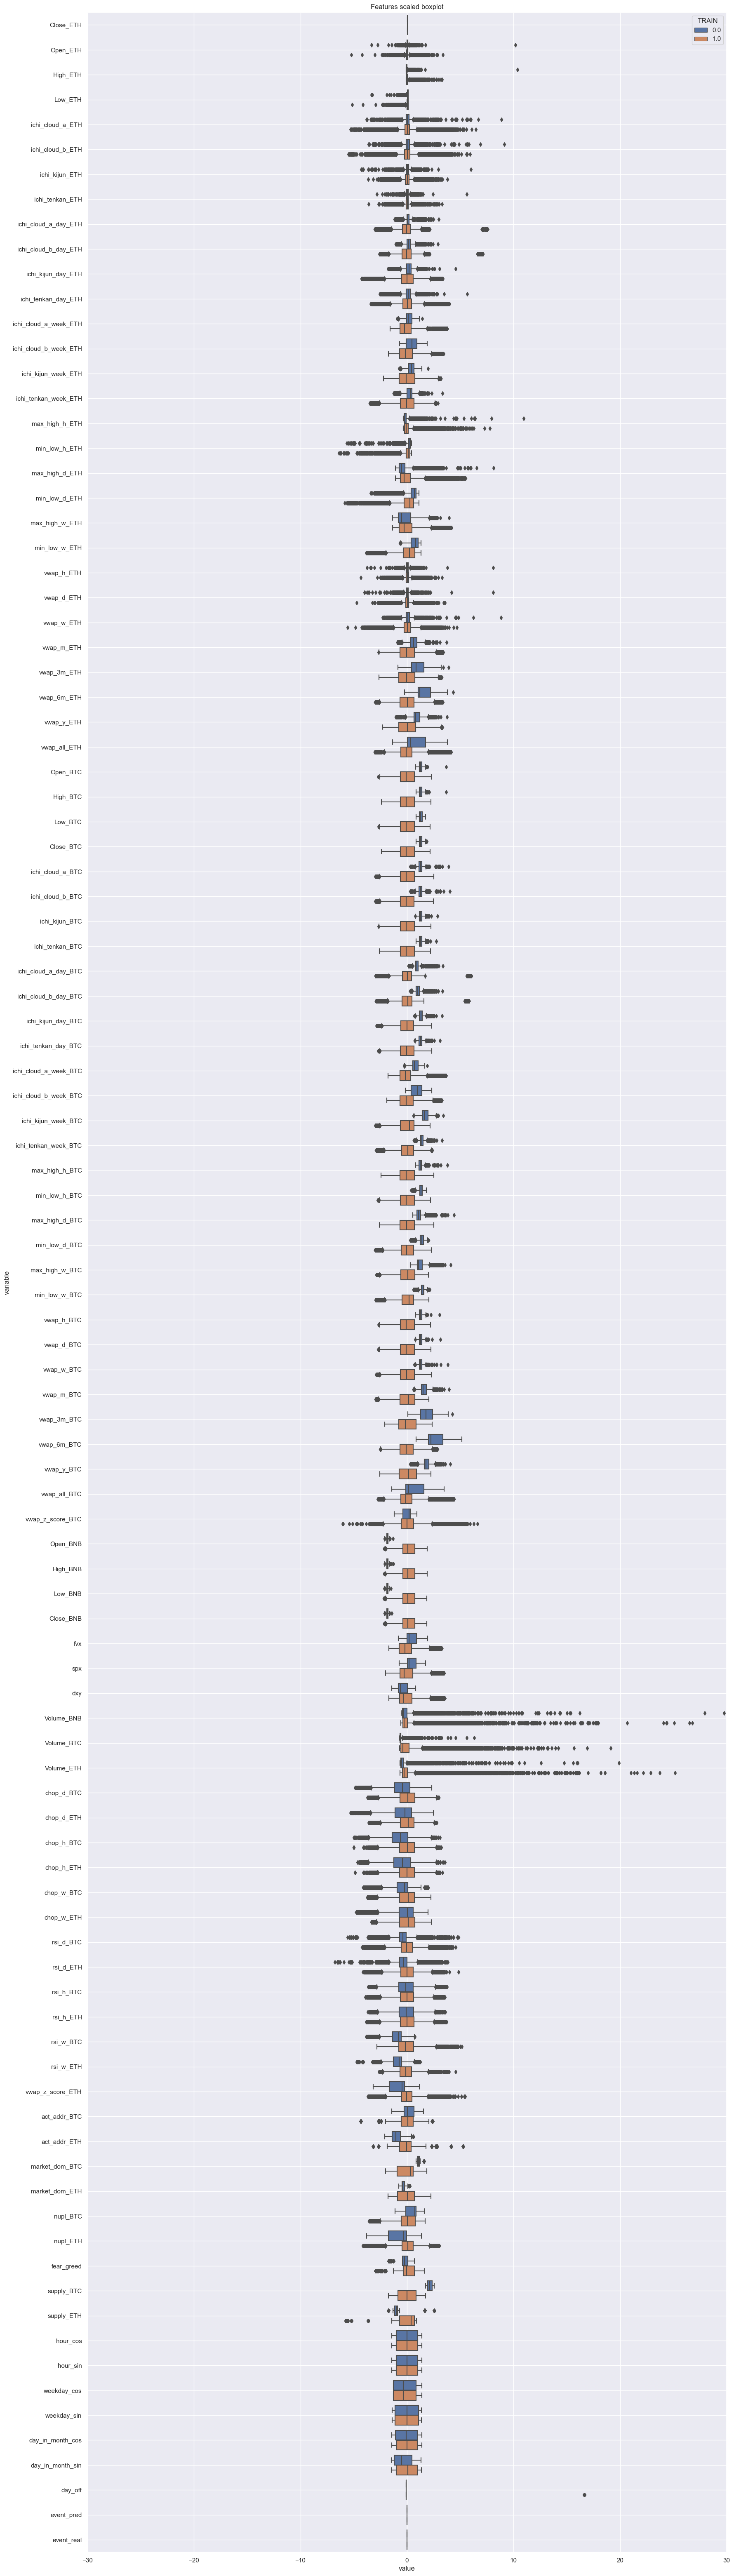

In [61]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

<AxesSubplot: >

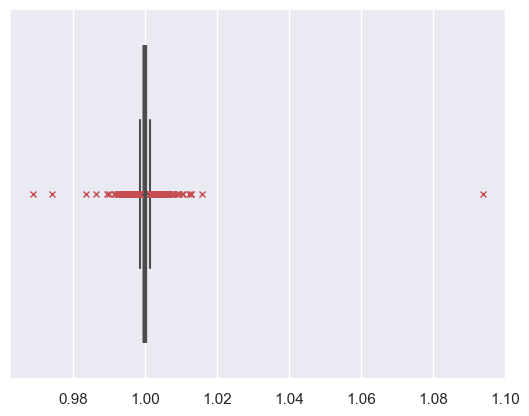

In [62]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


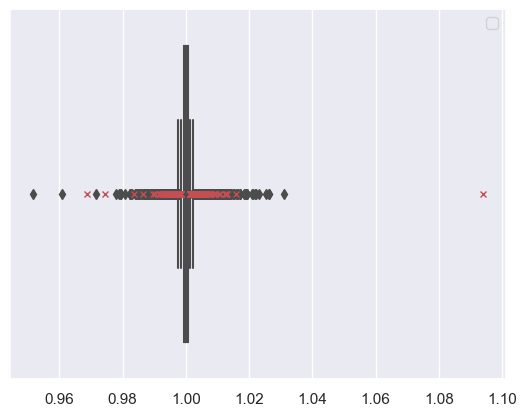

In [63]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

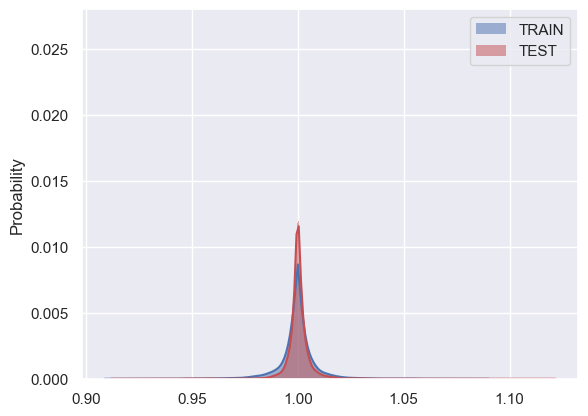

In [64]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [65]:
X_train_sca.shape

(55646, 72, 102)

In [66]:
X_train_sca[:,-1,:].shape

(55646, 102)

In [67]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.08922063],
       [-0.03470473],
       [-0.19343456],
       ...,
       [-0.07871545],
       [ 0.0920913 ],
       [-0.07501764]])

In [68]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(55646, 103)

In [69]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [70]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [71]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

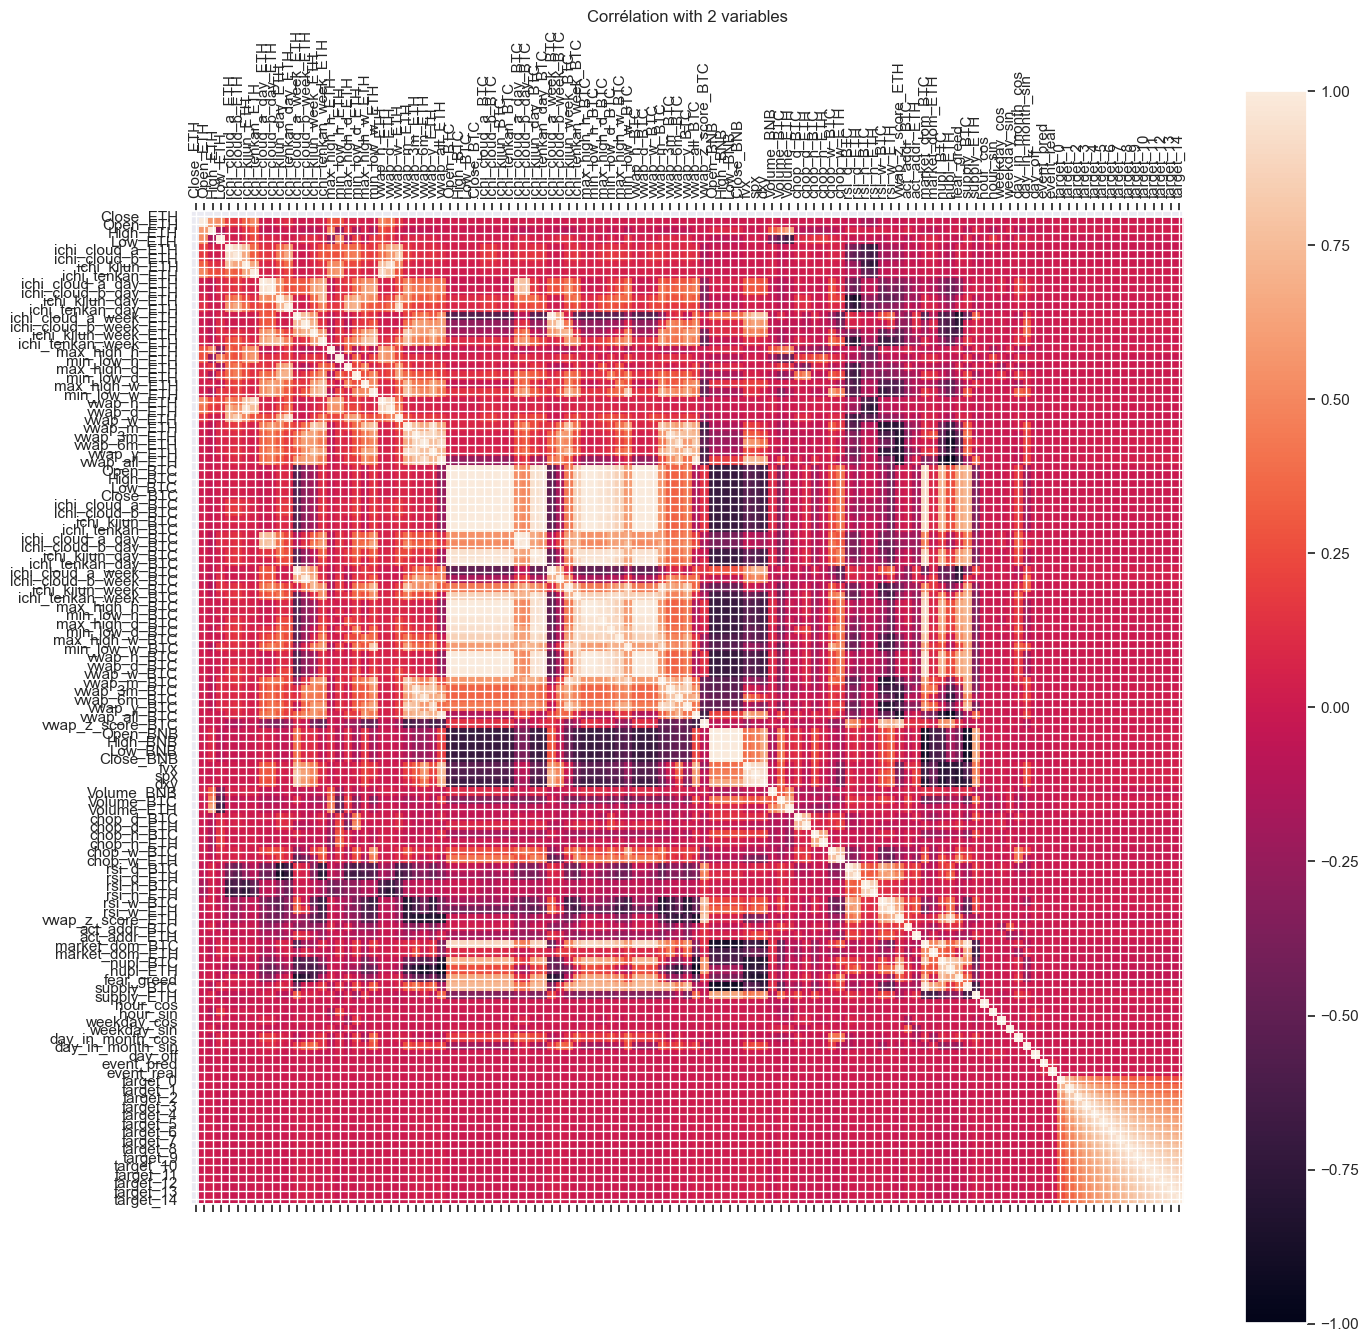

In [72]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


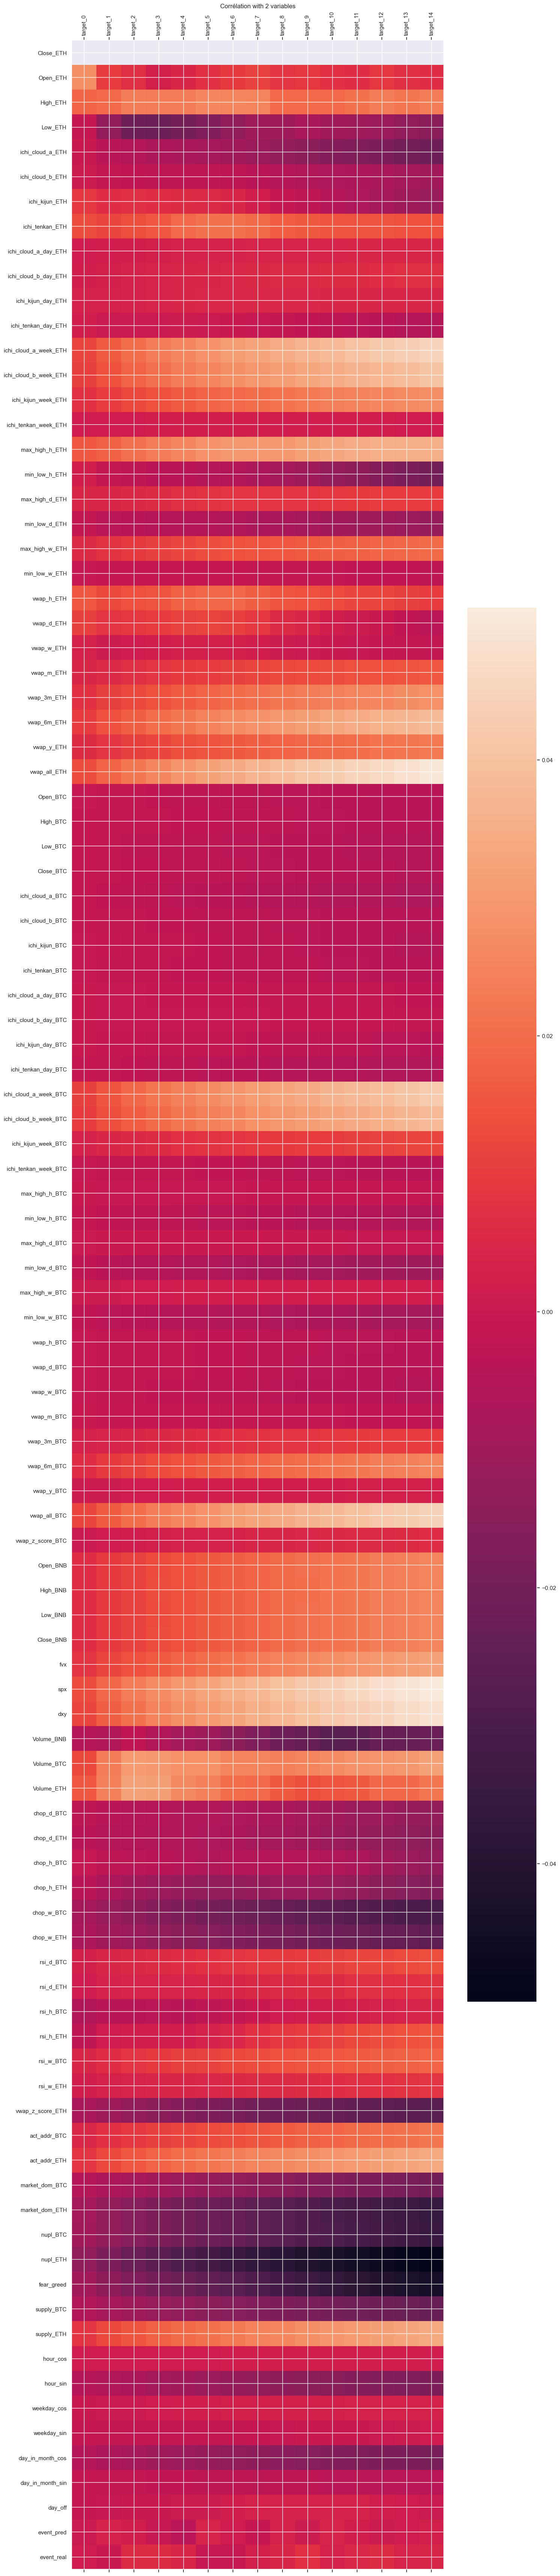

In [73]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


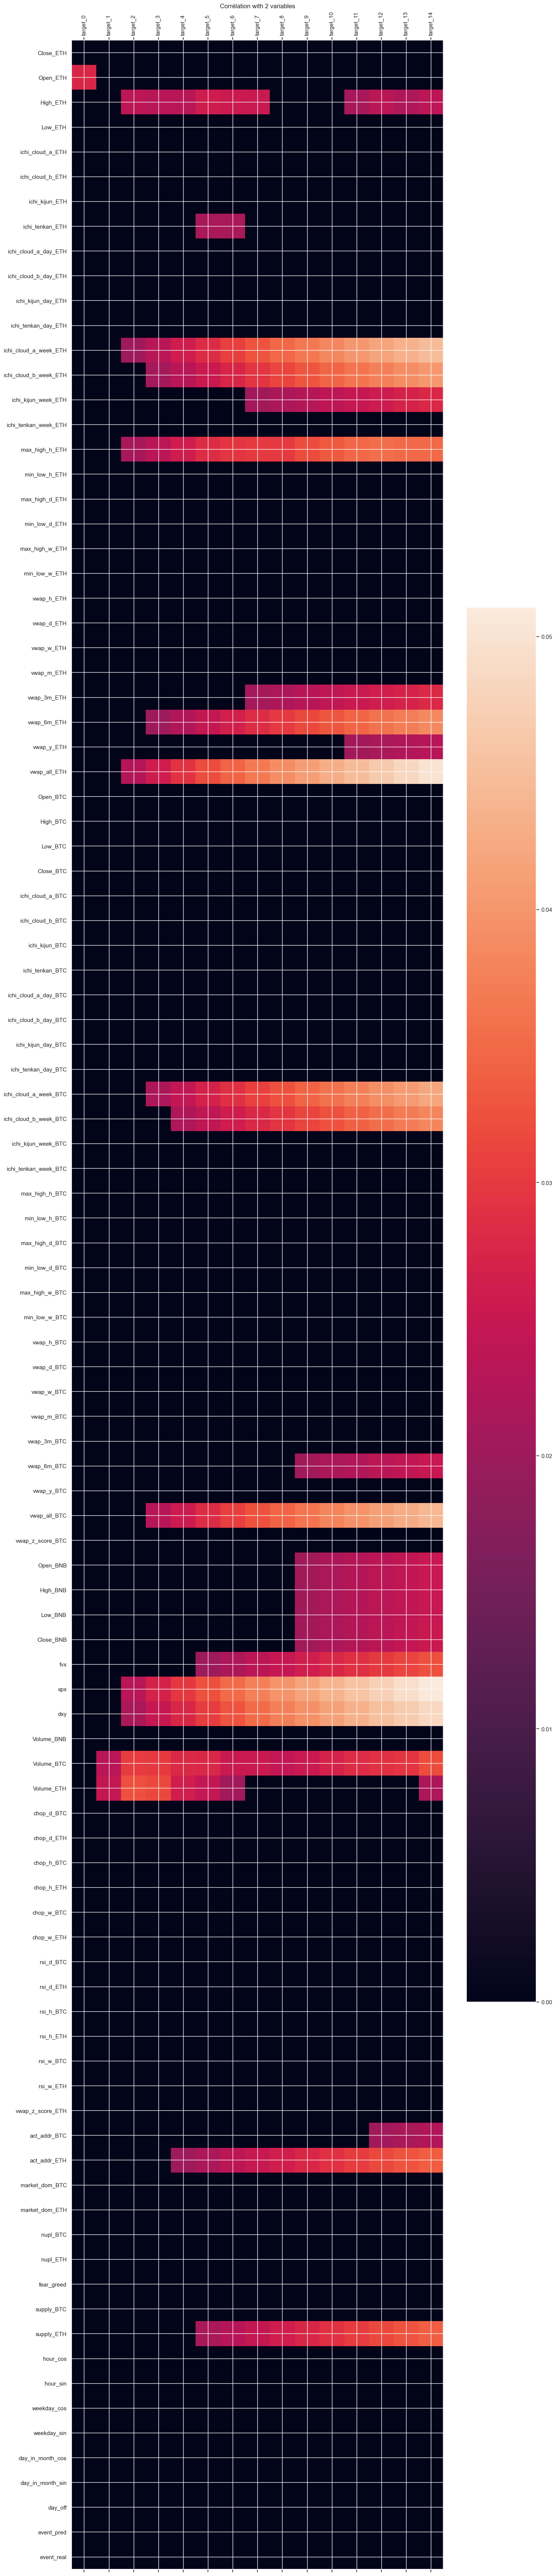

In [74]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [75]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

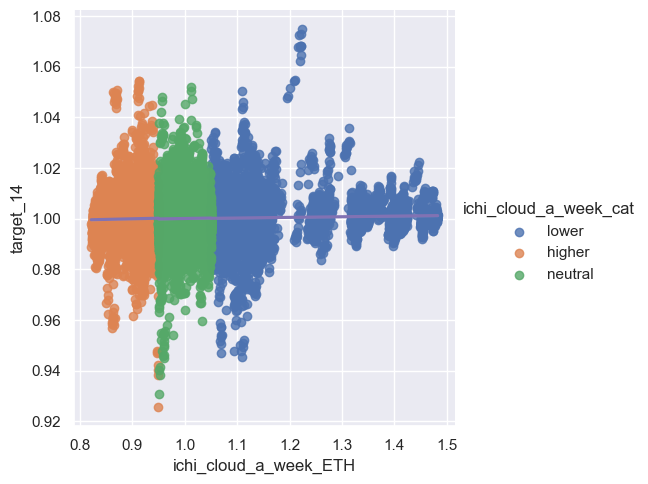

In [76]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

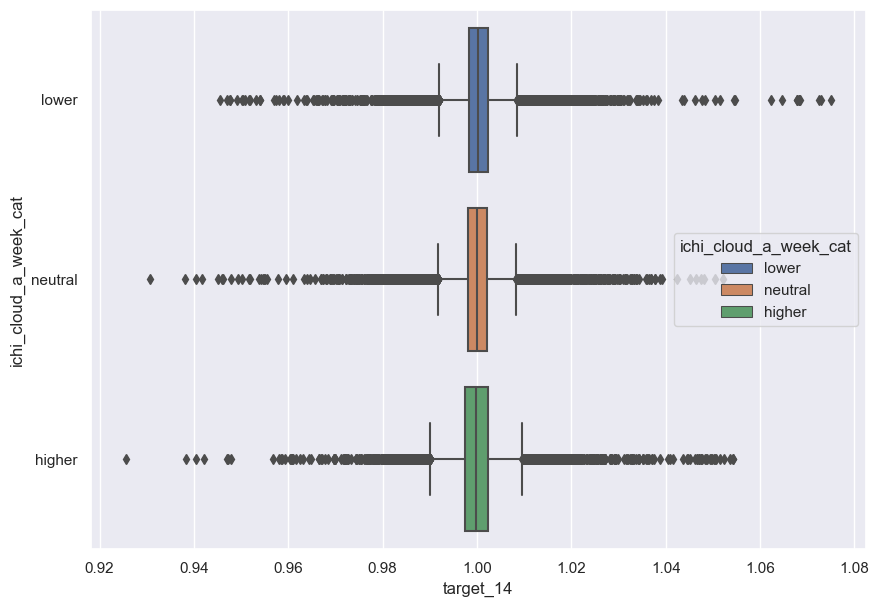

In [77]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [78]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


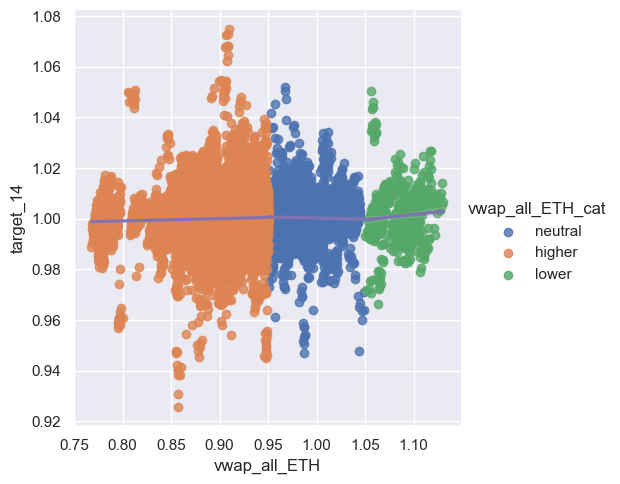

In [79]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

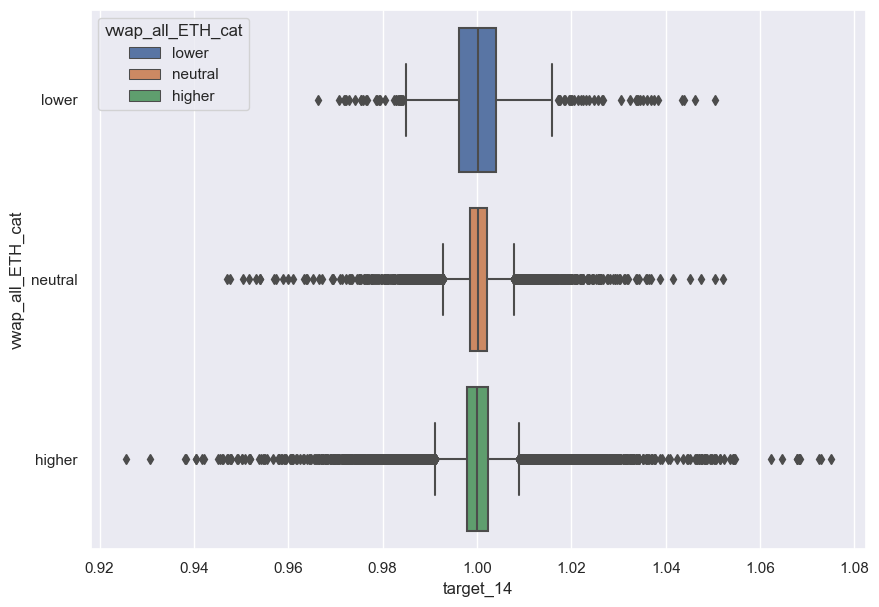

In [80]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

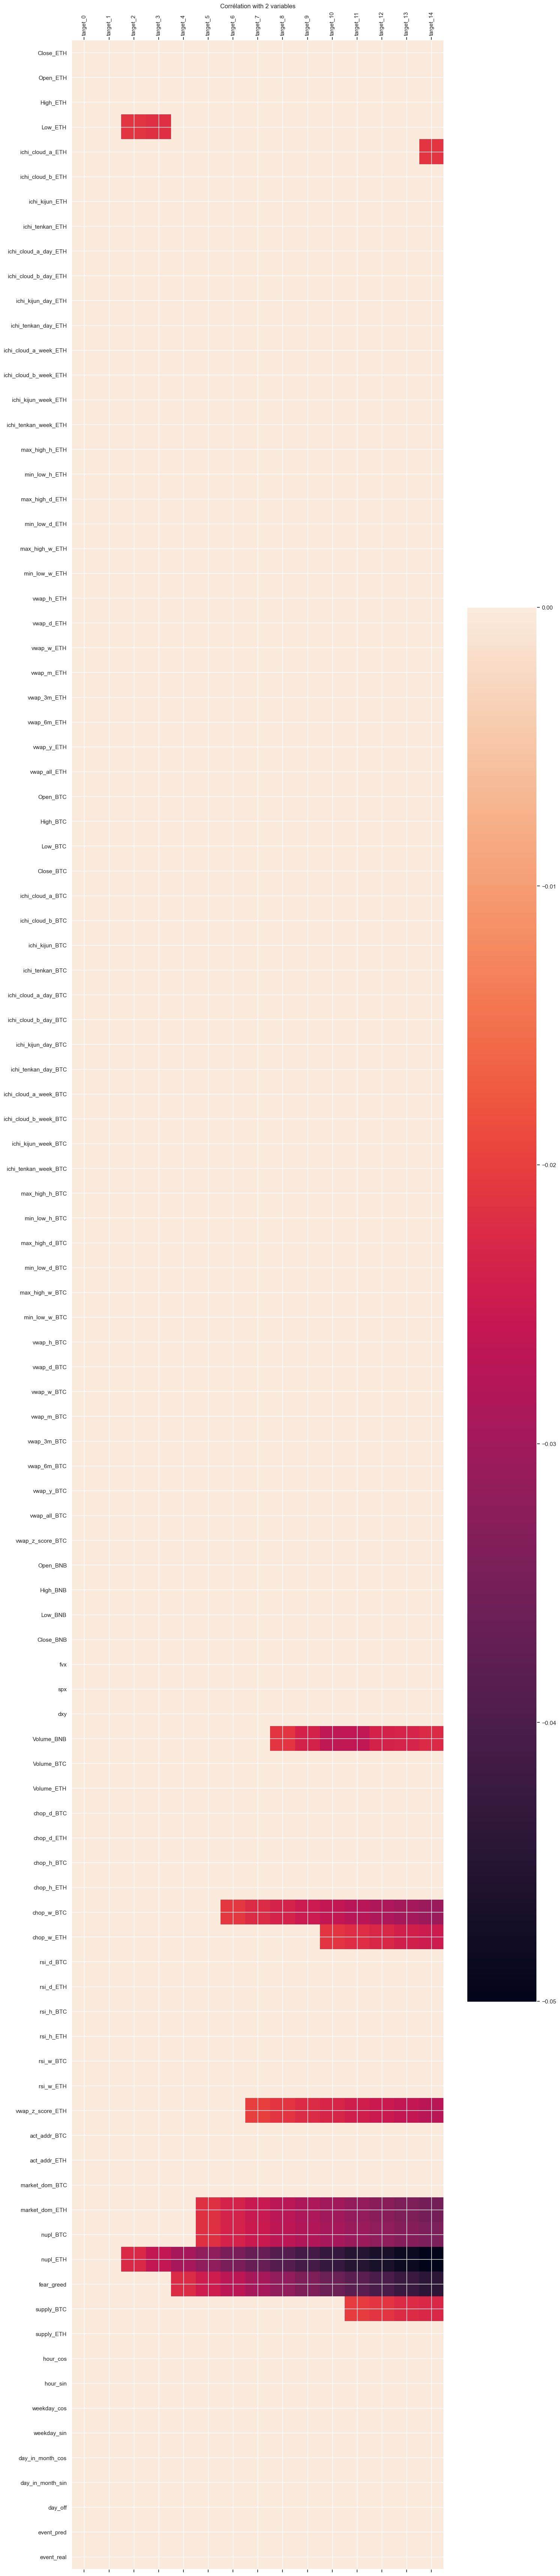

In [81]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

Text(0.5, 1.0, 'Net Unrealized Profit/Loss impact : ETH price = f(NUPL)')

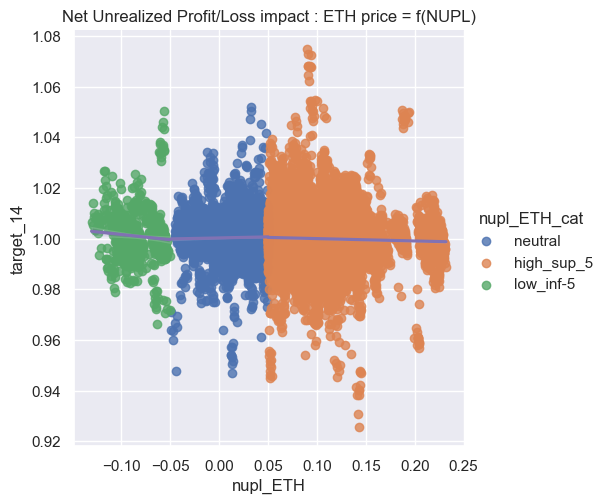

In [82]:
list_nupl_level=["low_inf-5", "neutral", "high_sup_5"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low_inf-5"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high_sup_5"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})
plt.title("Net Unrealized Profit/Loss impact : ETH price = f(NUPL)")

(0.98, 1.02)

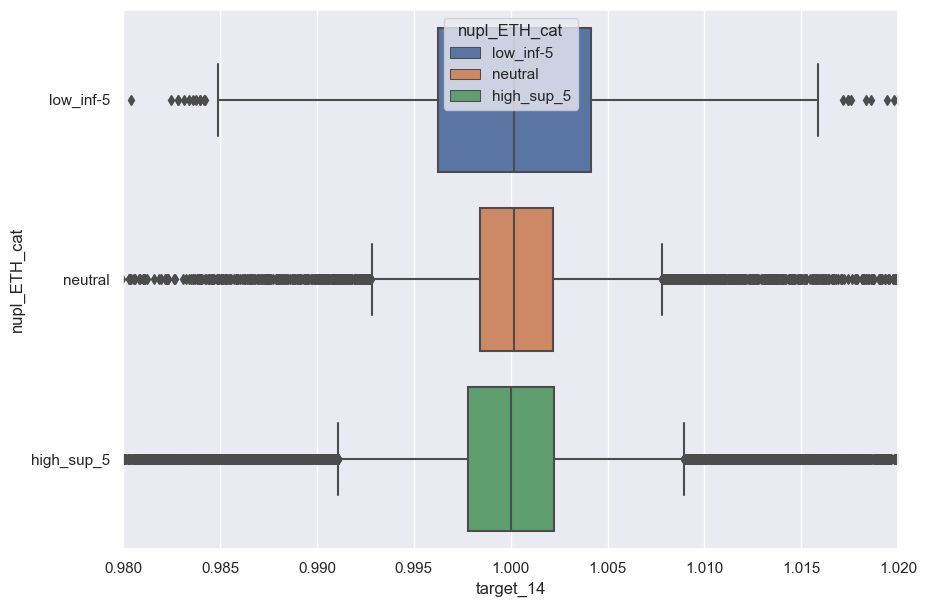

In [83]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)
ax = fig.gca()
ax.set_xlim([0.98,1.02])

In [84]:
df["target_14"].describe()

count    55646.000000
mean         1.000140
std          0.005899
min          0.925613
25%          0.997930
50%          1.000049
75%          1.002255
max          1.074927
Name: target_14, dtype: float64

In [85]:
df["target_1"].describe()

count    55646.000000
mean         1.000019
std          0.002166
min          0.967271
25%          0.999185
50%          1.000007
75%          1.000843
max          1.053076
Name: target_1, dtype: float64

<AxesSubplot: xlabel='target_14'>

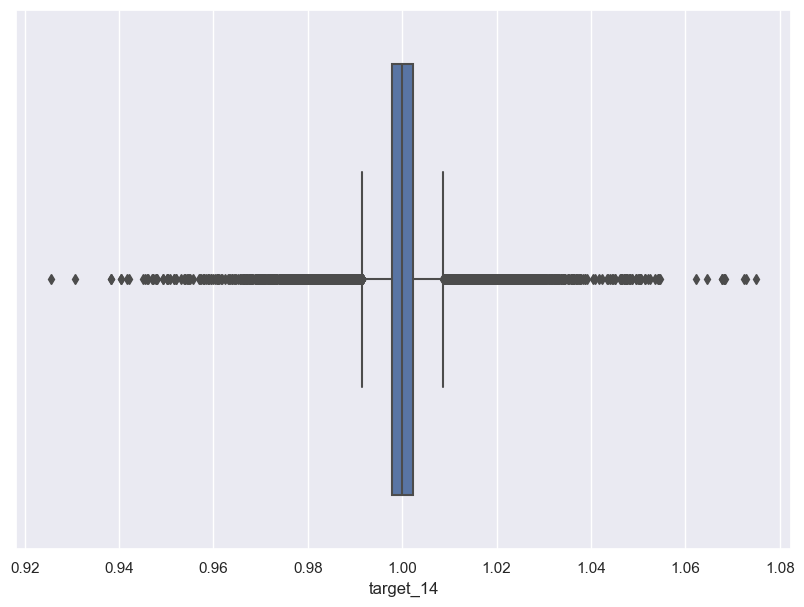

In [86]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [87]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [0.99973443, 1.00020714, 0.99995751, ..., 1.0005152 , 1.00069048,
        1.00027619],
       [1.00047284, 1.00022314, 1.00028158, ..., 1.0009563 , 1.0005419 ,
        1.0009563 ],
       [0.99975042, 0.99980883, 1.00062661, ..., 1.00006903, 1.00048324,
        1.00007434]])

In [88]:
y_train_sca

array([[ 8.92206251e-02,  7.17924937e-02, -1.04425279e-01, ...,
        -4.24585897e-02,  1.75716406e-02, -5.02044258e-02],
       [-3.47047328e-02, -2.10841407e-01, -5.59959791e-02, ...,
        -8.89006326e-02, -1.56645507e-01, -2.94070825e-01],
       [-1.93434562e-01, -3.85774720e-02, -1.48913149e-01, ...,
        -1.39234580e-01, -2.76670248e-01, -3.42484511e-01],
       ...,
       [-7.87154489e-02,  3.06314227e-02, -2.71135544e-02, ...,
         1.01891182e-01,  1.42435527e-01,  4.66034377e-02],
       [ 9.20912963e-02,  3.43309798e-02,  4.78493518e-02, ...,
         2.03925101e-01,  1.08067554e-01,  2.03925101e-01],
       [-7.50176403e-02, -6.15056573e-02,  1.27662104e-01, ...,
        -1.31591500e-03,  9.44963278e-02, -8.75529109e-05]])

## Autoencoder

### Model creation

### Training

In [89]:
X_train_sca.shape

(55646, 72, 102)

In [90]:
3*3*3*10*35/3600

2.625

In [91]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
seed = 1
epochs = 30 #100 #150 #6 #300
patience = 10 #30 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in [64]: #[32, 64, 128]: #[104]: #
        for encoding_dim in [16]:#[16, 20, 32]:
            for dropout_autoenc in [0.25]: #[0.05, 0.15, 0.25]: #[0.25]:
                # check already done ? 
                #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                path_jpg = os.path.join(path_data,
                    f"output_MSE autoencoder - {plt_name}.jpg")
                if (MODE_TRAIN_AE == False):
                    print(f"BE CAREFUL ! training inactivated => no training done...")
                    continue
                print(f"Training: {plt_name} ...")
                # Init
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                # Input dimension
                input_dim = X_train.shape[-1]
                # Reduced encoded input dimension
                # 64/8/0.5
                # Définir l'encodeur
                encoder_inputs = keras.Input(shape=(None, input_dim))
                encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                #encoder = layers.LayerNormalization()(encoder)
                #encoder = layers.Dense(encoding_dim, activation='relu')
                encoder = layers.Dropout(dropout_autoenc)(encoder)
                encoder_outputs = layers.Dense(encoding_dim)(encoder)
                encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                print(encoder_model.summary())
                # Définir le décodeur
                decoder_inputs = keras.Input(shape=(None, encoding_dim))
                decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                #decoder = layers.LayerNormalization()(decoder)
                #decoder = layers.Dense(n_unit_enc, activation='relu')
                decoder = layers.Dropout(dropout_autoenc)(decoder)
                decoder_outputs = layers.Dense(input_dim)(decoder)
                decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                print(decoder_model.summary())
                # Define complete autoencoder 
                autoencoder_inputs = keras.Input(shape=(None, input_dim))
                encoded = encoder_model(autoencoder_inputs)
                decoded = decoder_model(encoded)
                autoencoder = keras.Model(autoencoder_inputs, decoded)
                # Compile : autoencoder
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.Adam()
                autoencoder.compile(optimizer=optim, loss="mse")
                # earlystop 
                es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                                monitor='val_loss', mode='auto', restore_best_weights=True)
                # Train
                if patience == 0:
                    autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                    epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                    verbose=1)
                else:
                    autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                        epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                        verbose=1, callbacks=[es])

                plot_train_history(
                    autoenc_step_history,f"MSE autoencoder - {plt_name}",
                    saveFolder=path_data)
                #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                            # save the best
                mse_curr = np.min(autoenc_step_history.history['val_loss'])
                print("MSE TEST : ", mse_curr)

                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_unit_enc_min = n_unit_enc
                    encoding_dim_min = encoding_dim
                    dropout_autoenc_min = dropout_autoenc
                    print("Save autoencoder: ", path_mdl_autoencoder)
                    autoencoder.save(path_mdl_autoencoder)
                    print("Save encoder: ", path_mdl_encoder)
                    encoder_model.save(path_mdl_encoder)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min
else:
    print("Load models...")
    autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
    print(autoencoder.summary())
    encoder_model = tf.keras.models.load_model(path_mdl_encoder)
    print(encoder_model.summary())
    n_unit_enc = encoder_model.layers[1].units
    dropout_autoenc = encoder_model.layers[2].rate
    encoding_dim = encoder_model.layers[3].units

print(f"Best model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

Load models...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 model (Functional)          (None, None, 16)          43792     
                                                                 
 model_1 (Functional)        (None, None, 102)         27366     
                                                                 
Total params: 71158 (277.96 KB)
Trainable params: 71158 (277.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                    

### Save model

In [92]:
# TODO select best model


In [93]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [94]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [95]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

1739/1739 [==============================] - 40s 23ms/step


(55646, 72, 102)

### Results

In [96]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

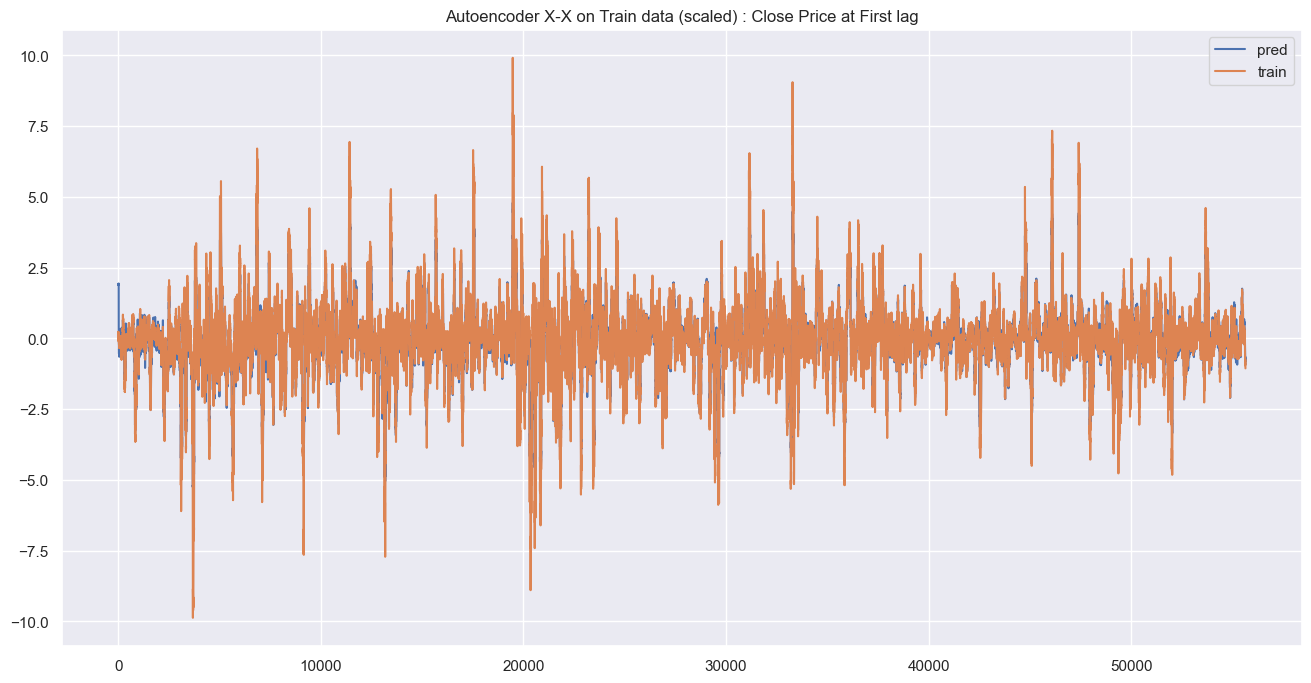

In [97]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE TRAIN by lags and by features

In [98]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)

mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)

df_mae_ae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_train.index))]
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)

df_mae_ae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(55646, 72, 102)
(55646, 72, 102)
(72, 102)
(1, 102)


In [99]:
df_mae_ae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.187372  0.193550  0.181363  0.191535          0.297807   
lag_1    0.136098  0.139158  0.126986  0.137401          0.261996   
lag_2    0.124593  0.123484  0.114323  0.122644          0.247294   
lag_3    0.121823  0.117262  0.111110  0.116999          0.236021   
lag_4    0.120409  0.115091  0.109575  0.115046          0.229649   
...           ...       ...       ...       ...               ...   
lag_67   0.103132  0.102681  0.092540  0.100820          0.177378   
lag_68   0.102742  0.102398  0.092217  0.100539          0.177337   
lag_69   0.102348  0.102141  0.091881  0.100232          0.177268   
lag_70   0.102013  0.101789  0.091573  0.099900          0.177210   
lag_71   0.101439  0.101649  0.091152  0.099496          0.177163   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.329531        0.211047         0.204877   
lag_1           0.291941        0.163234         0.154199   
lag_2           0.275397        0.144219         0.133503   
lag_3           0.264187        0.136183         0.124288   
lag_4           0.255833        0.133026         0.118304   
...                  ...             ...              ...   
lag_67          0.182227        0.119395         0.096050   
lag_68          0.182202        0.119271         0.095903   
lag_69          0.182168        0.119127         0.095757   
lag_70          0.182105        0.119025         0.095597   
lag_71          0.182063        0.118885         0.095362   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  \
lag_0               0.299505              0.244114  ...    0.359462  0.635314   
lag_1               0.244302              0.189915  ...    0.251284  0.470535   
lag_2               0.214475              0.162519  ...    0.201159  0.400122   
lag_3               0.194979              0.148461  ...    0.173823  0.355407   
lag_4               0.181465              0.137177  ...    0.156514  0.324852   
...                      ...                   ...  ...         ...       ...   
lag_67              0.138340              0.107088  ...    0.120200  0.209470   
lag_68              0.138347              0.107083  ...    0.120180  0.209316   
lag_69              0.138337              0.107061  ...    0.120147  0.209158   
lag_70              0.138339              0.107057  ...    0.120111  0.208999   
lag_71              0.138347              0.107044  ...    0.120078  0.208855   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
lag_0   0.633039     0.587606     0.590853          0.589790   
lag_1   0.460966     0.420403     0.426919          0.466035   
lag_2   0.384271     0.360069     0.370249          0.398544   
lag_3   0.346147     0.328875     0.340597          0.358112   
lag_4   0.319180     0.306084     0.319311          0.325646   
...          ...          ...          ...               ...   
lag_67  0.219577     0.229825     0.229520          0.186345   
lag_68  0.219401     0.229806     0.229405          0.186400   
lag_69  0.219250     0.229765     0.229285          0.186474   
lag_70  0.219153     0.229742     0.229171          0.186524   
lag_71  0.219019     0.229746     0.229032          0.186597   

        day_in_month_sin   day_off  event_pred  event_real  
lag_0           0.607881  0.370605    0.049145    0.049818  
lag_1           0.452363  0.304223    0.048373    0.048447  
lag_2           0.389174  0.211414    0.042419    0.045218  
lag_3           0.348164  0.155518    0.040875    0.043192  
lag_4           0.318409  0.123929    0.039966    0.042359  
...                  ...       ...         ...         ...  
lag_67          0.187080  0.070921    0.039615    0.037996  
lag_68          0.187012  0.070853    0.039609    0.037944  
lag_69          0.186937  0.070764    0.039605    0.037881  
lag_70          0.186868  0.070684    0.039602    0.037825  
lag_71          0.186790  0.07056

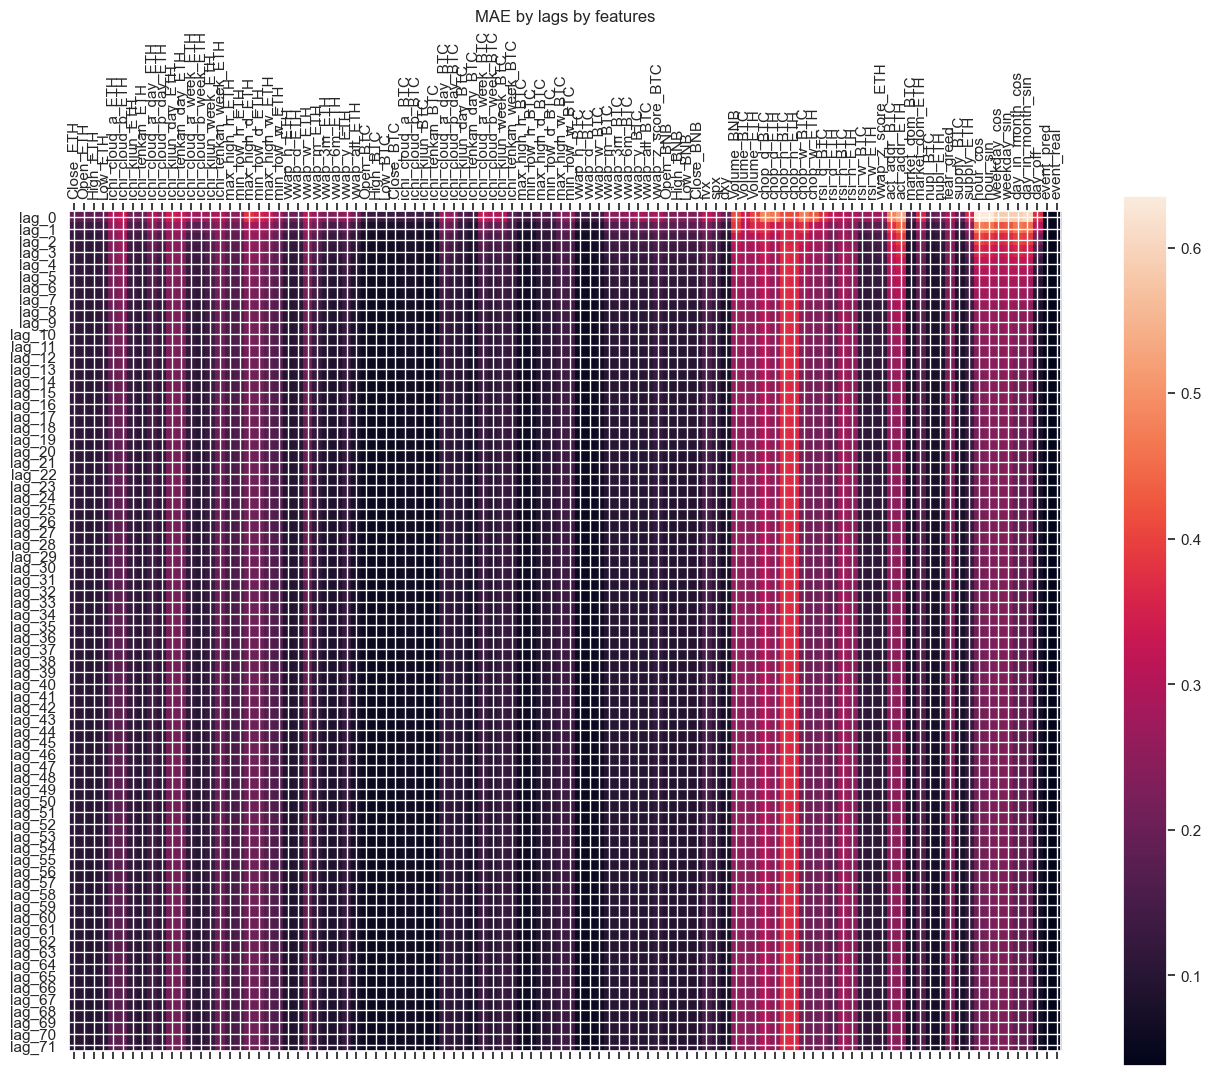

In [100]:
plot_corr(df_mae_ae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

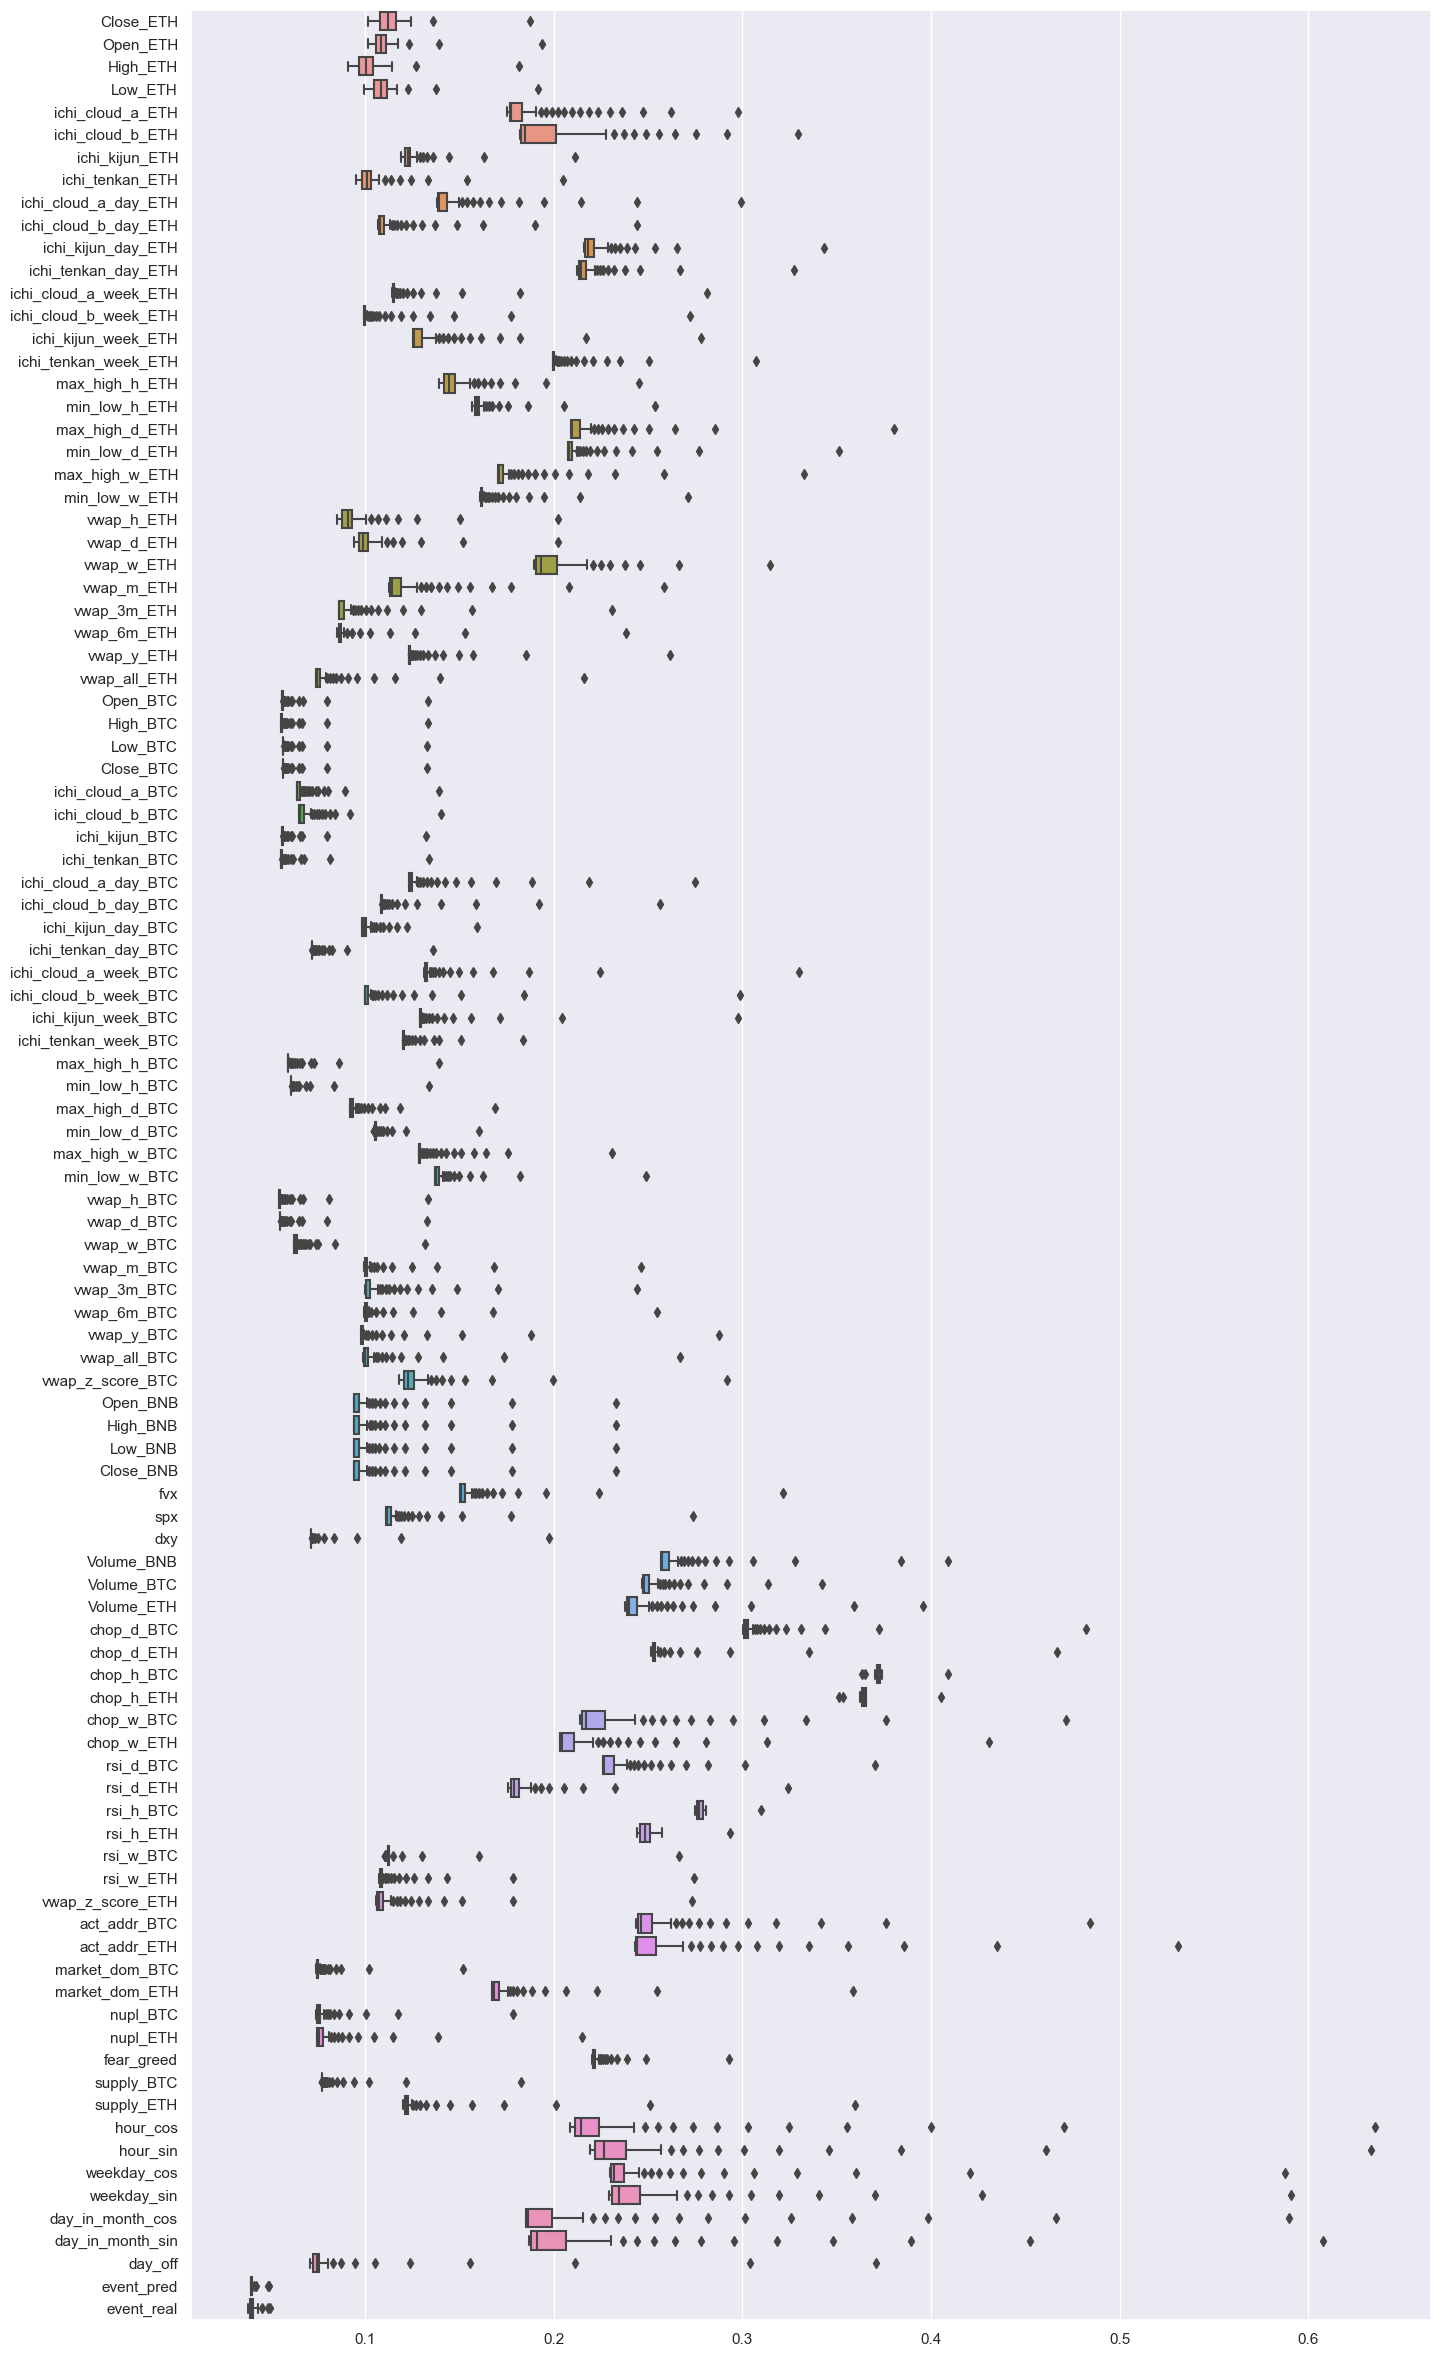

In [101]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_ae_train, orient="h")

In [102]:
df_mae_ae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.112995  0.109866  0.101727  0.109322           0.18687   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.198722          0.1249         0.103867              0.147767   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.114171  ...    0.130052  0.235808  0.245533     0.247388   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0      0.25187          0.212447          0.215697  0.085976    0.040035   

   event_real  
0    0.040005  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature')

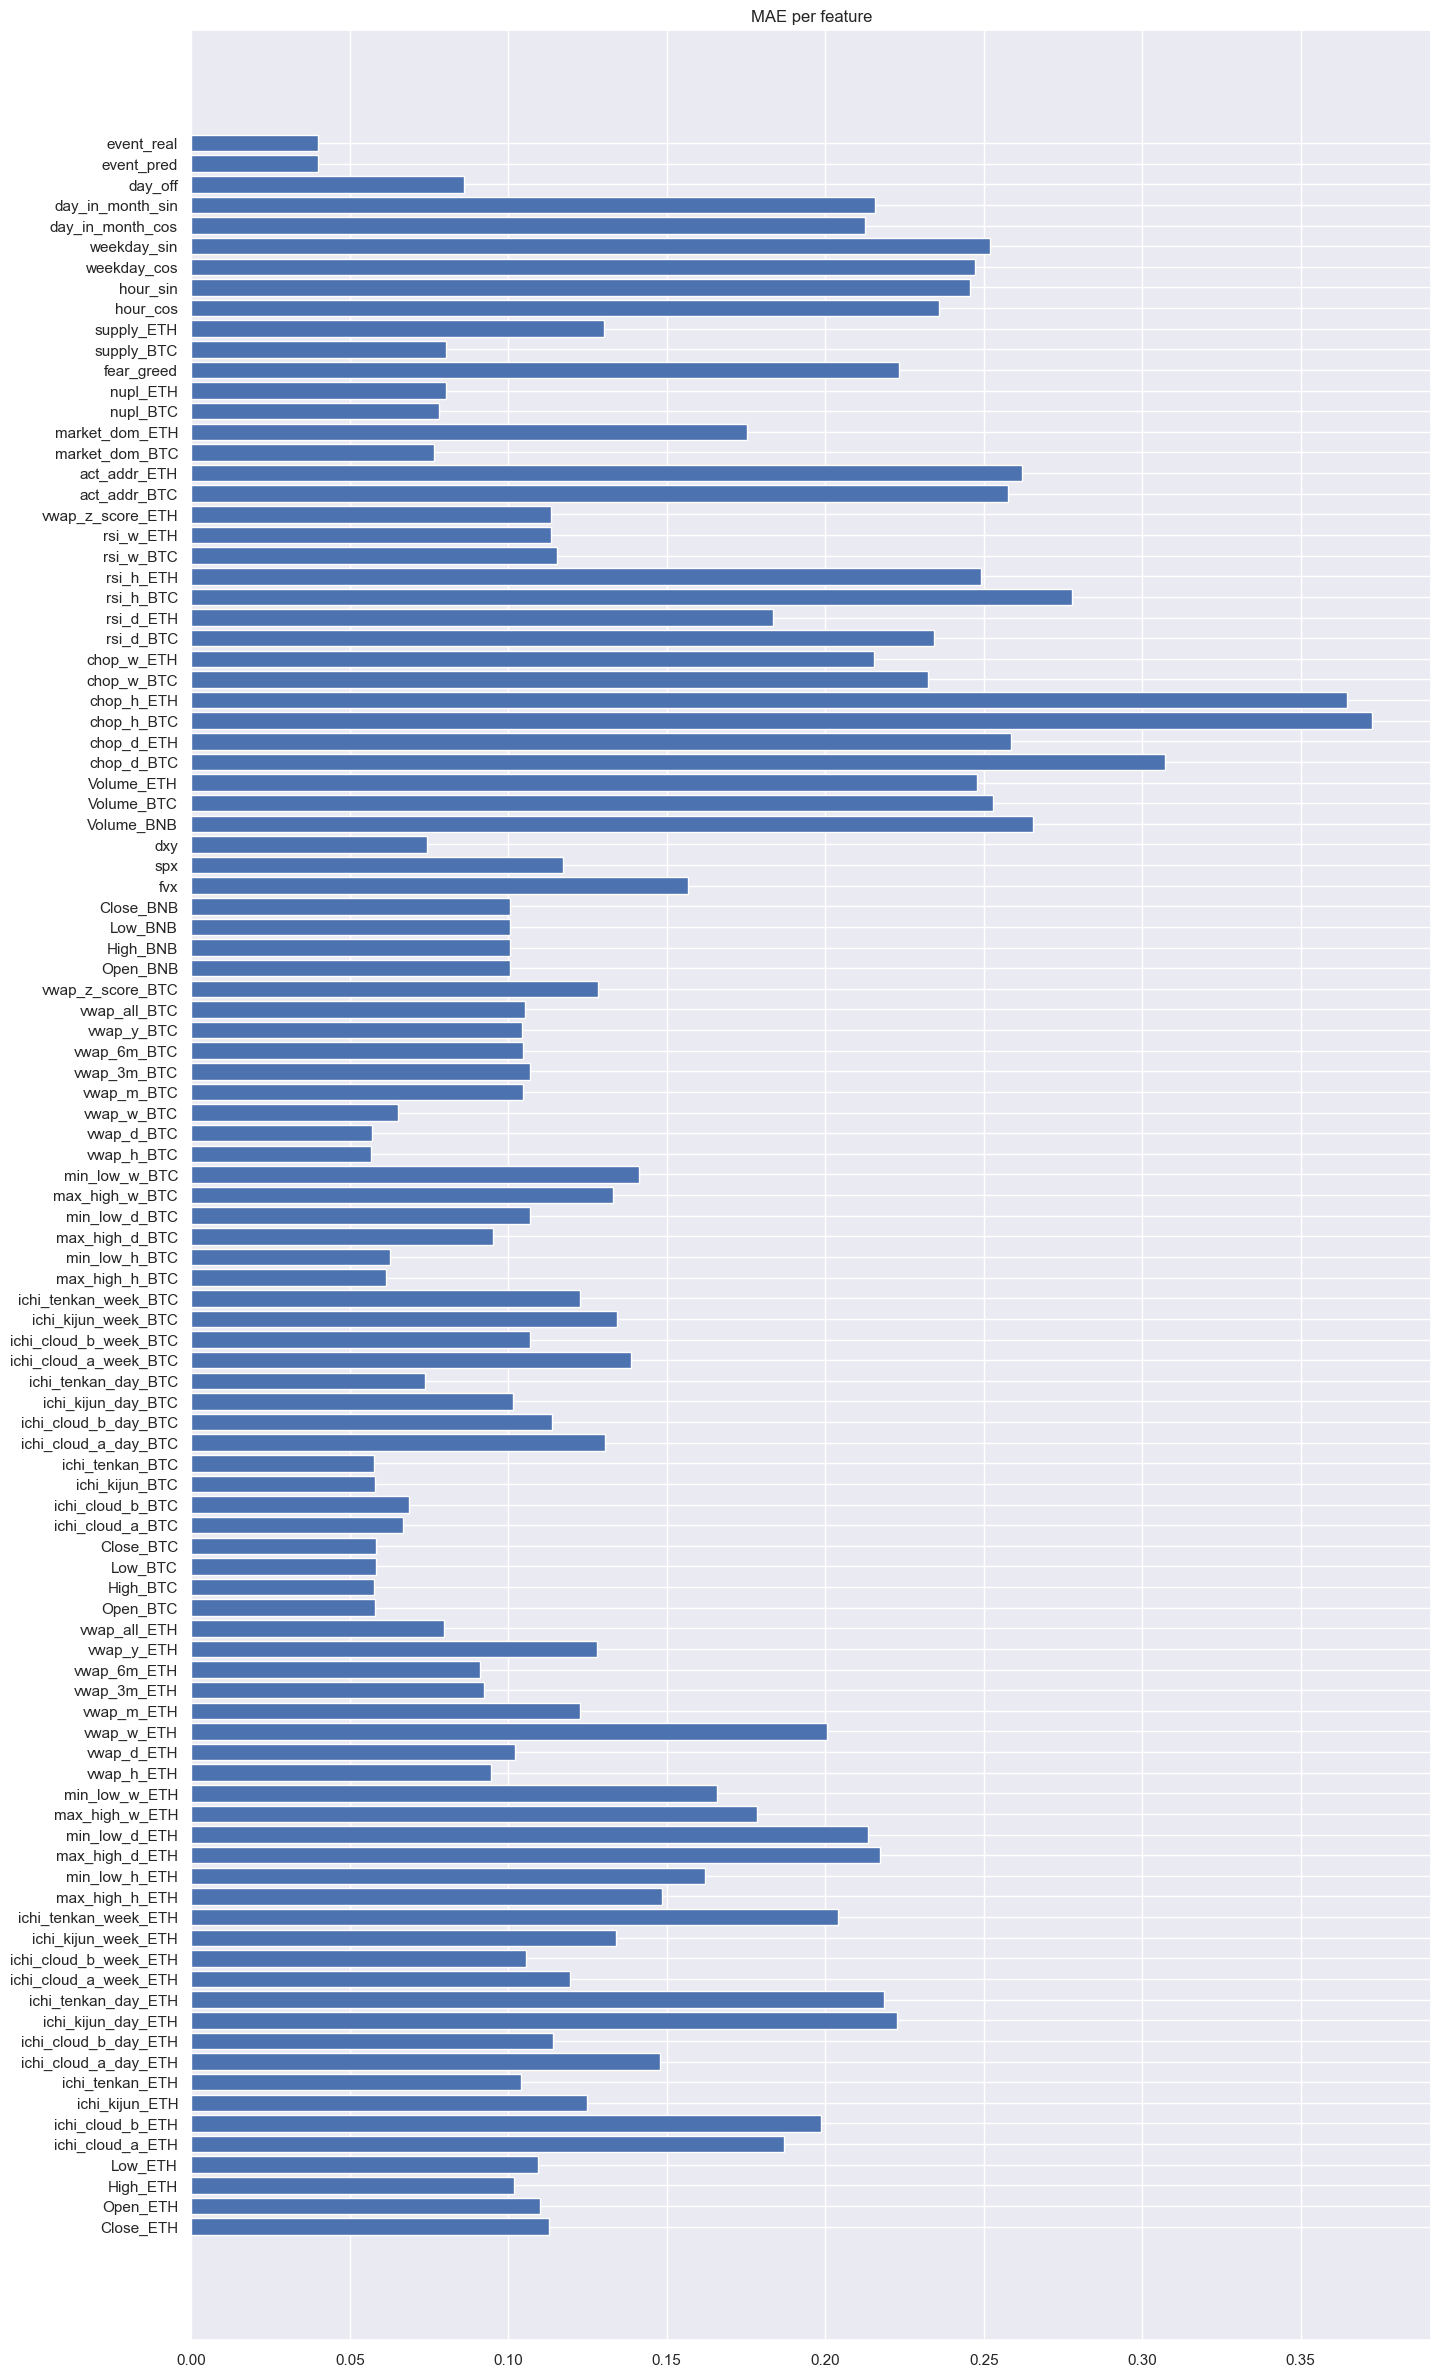

In [103]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_train_feat.columns, df_mae_ae_train_feat.values[0])
plt.title("MAE per feature")

In [104]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(55646,)
(55646,)
[1196.32 1195.38 1194.55 ... 1865.98 1864.56 1864.48]
[1196.32 1195.38 1194.55]


In [105]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.99878997, 0.99947107, 0.99991226, ..., 1.0017284 , 1.0017455 ,
       1.0014249 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 1865.98 1864.56 1864.48]
[1215.04649252 1215.57943565 1215.420084   ... 1868.1821892  1866.02092147
 1867.00123665]


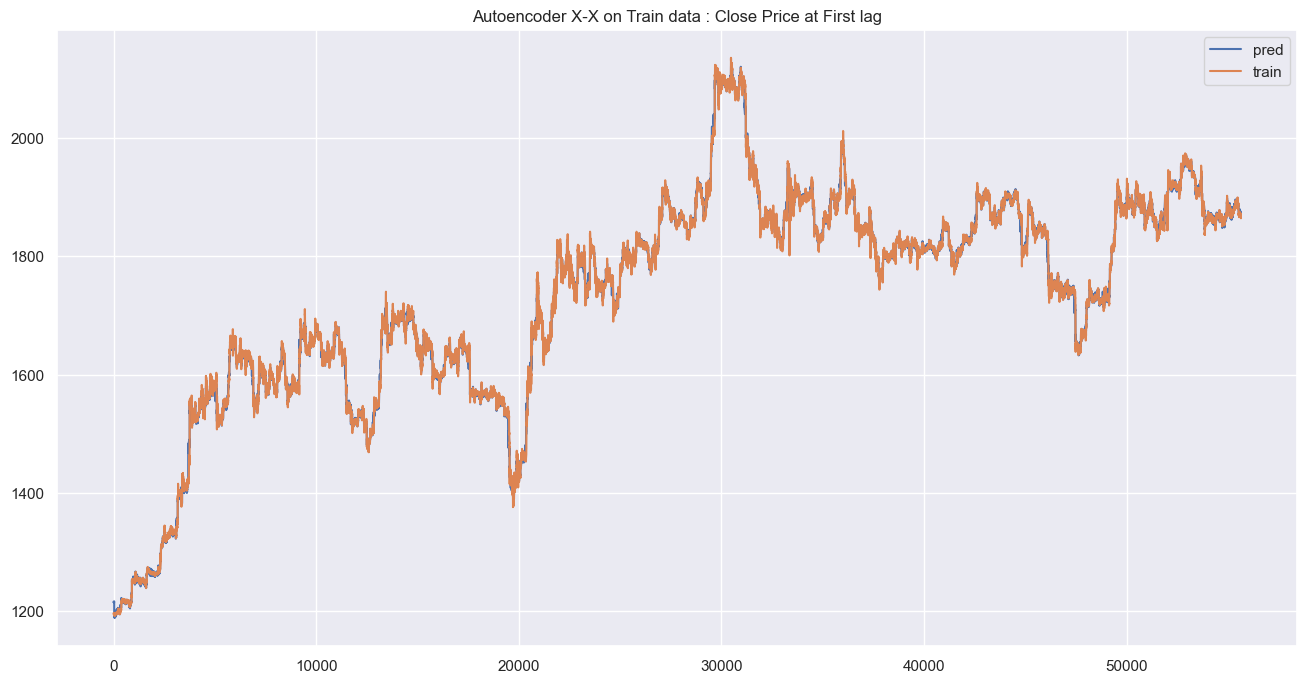

In [106]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### MAE TEST per features

In [107]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

433/433 [==============================] - 11s 24ms/step


(13845, 72, 102)

In [108]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-07-13 12:20:00'

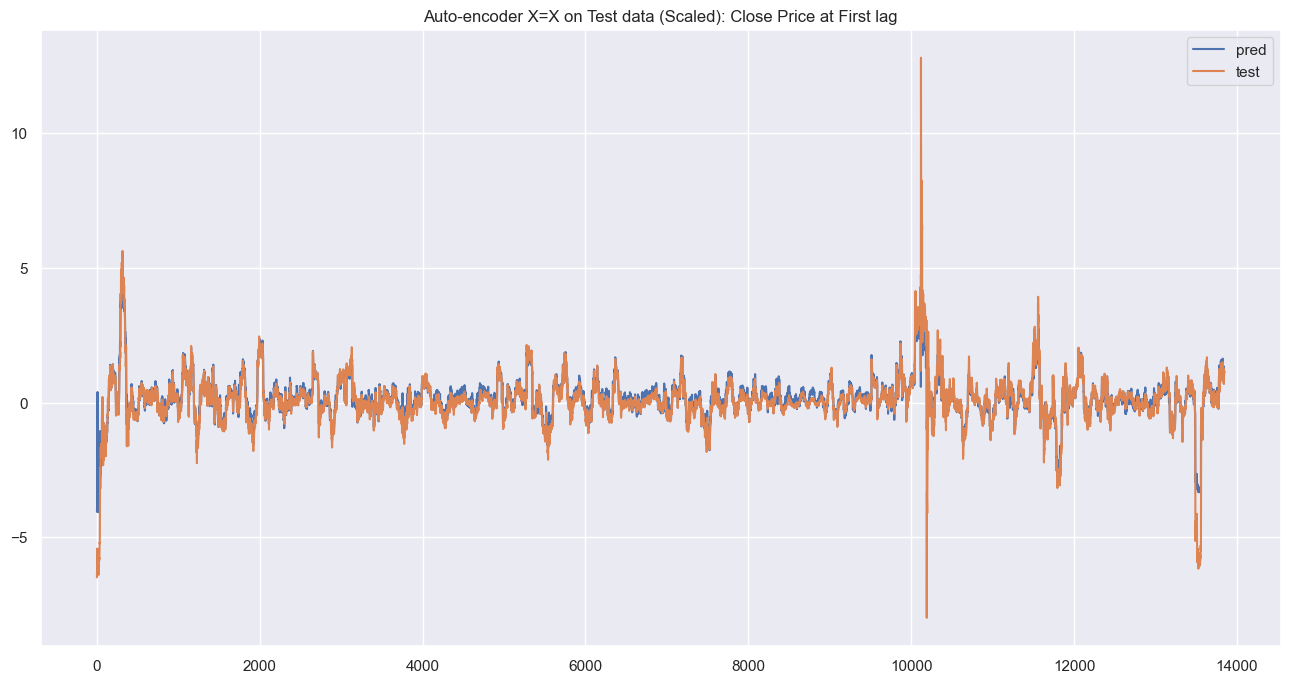

In [109]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [110]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1880.89 1877.36 1878.88 1882.85 1882.75 1880.   1880.51 1881.49 1881.28]
X test pred :  [1925.31261077 1917.78145037 1913.56083935 1915.59540485 1914.93217814
 1909.82769987 1913.2865746  1986.54440596 1912.68633594]


[1880.89 1877.36 1878.88 ... 1718.34 1719.45 1720.03]
[1925.31261077 1917.78145037 1913.56083935 ... 1718.63129919 1719.478672
 1719.48157531]


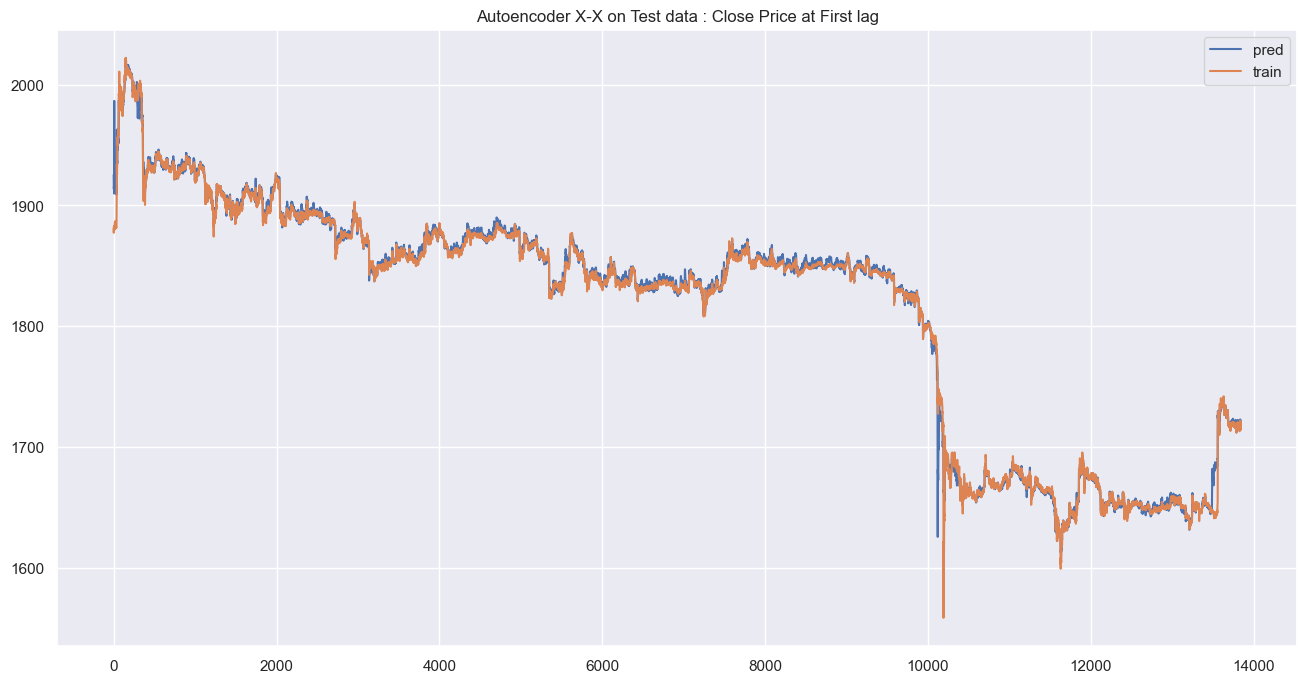

In [111]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [112]:
X_test_sca.shape

(13845, 72, 102)

In [113]:
mean_absolute_error(X_test_sca[:,0,:], X_test_sca_pred[:,0,:])

0.36640216983100377

In [114]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_ae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_ae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(13845, 72, 102)
(13845, 72, 102)
(72, 102)
(1, 102)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.187372  0.193550  0.181363  0.191535          0.297807   
lag_1    0.136098  0.139158  0.126986  0.137401          0.261996   
lag_2    0.124593  0.123484  0.114323  0.122644          0.247294   
lag_3    0.121823  0.117262  0.111110  0.116999          0.236021   
lag_4    0.120409  0.115091  0.109575  0.115046          0.229649   
...           ...       ...       ...       ...               ...   
lag_67   0.103859  0.098885  0.104744  0.101810          0.170989   
lag_68   0.103520  0.098665  0.104497  0.101512          0.170936   
lag_69   0.103144  0.098453  0.104156  0.101201          0.170836   
lag_70   0.102910  0.098197  0.103981  0.100905          0.170675   
lag_71   0.102629  0.098003  0.103862  0.100575          0.170576   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.329531        0.211047         0.204877   
lag_1           0.291941        0.163234         0.154199   
lag_2           0.275397        0.144219         0.133503   
lag_3           0.264187        0.136183         0.124288   
lag_4           0.255833        0.133026         0.118304   
...                  ...             ...              ...   
lag_67          0.179911        0.104471         0.087475   
lag_68          0.179880        0.104319         0.087238   
lag_69          0.179806        0.104086         0.087060   
lag_70          0.179703        0.103855         0.086863   
lag_71          0.179605        0.103605         0.086553   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
lag_0               0.299505              0.244114  ...  0.635314  0.633039   
lag_1               0.244302              0.189915  ...  0.470535  0.460966   
lag_2               0.214475              0.162519  ...  0.400122  0.384271   
lag_3               0.194979              0.148461  ...  0.355407  0.346147   
lag_4               0.181465              0.137177  ...  0.324852  0.319180   
...                      ...                   ...  ...       ...       ...   
lag_67              0.245165              0.255821  ...  0.237189  0.262329   
lag_68              0.245071              0.255808  ...  0.236842  0.262160   
lag_69              0.244978              0.255796  ...  0.236600  0.262032   
lag_70              0.244910              0.255762  ...  0.236412  0.261920   
lag_71              0.244832              0.255724  ...  0.236178  0.261838   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.587606     0.590853          0.589790          0.607881   
lag_1      0.420403     0.426919          0.466035          0.452363   
lag_2      0.360069     0.370249          0.398544          0.389174   
lag_3      0.328875     0.340597          0.358112          0.348164   
lag_4      0.306084     0.319311          0.325646          0.318409   
...             ...          ...               ...               ...   
lag_67     0.301574     0.438109          0.645951          0.785605   
lag_68     0.301509     0.438202          0.646029          0.785695   
lag_69     0.301416     0.438266          0.646131          0.785780   
lag_70     0.301358     0.438332          0.646232          0.785858   
lag_71     0.301396     0.438384          0.646361          0.785907   

         day_off  event_pred  event_real  dataset  
lag_0   0.370605    0.049145    0.049818    TRAIN  
lag_1   0.304223    0.048373    0.048447    TRAIN  
lag_2   0.211414    0.042419    0.045218    TRAIN  
lag_3   0.155518    0.040875    0.043192    TRAIN  
lag_4   0.123929    0.039966    0.042359    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.064841    0.027306    0.031676     TEST  
lag_68  0.064718    0.027310    0.031644     TEST  
lag_69  0.064621    0.027305    0.031601     TEST  
lag_70  0.064512    0.027302    0.031547     TEST  
lag_71  0.064475    0.027305    0.031491     TEST  

[144 ro

In [115]:
df_mae_ae_test_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.108925  0.103224  0.110098  0.105968          0.174807   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0           0.18457        0.112473         0.093454              0.252336   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.259728  ...    0.283807  0.261895  0.277557     0.314452   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0     0.431984          0.667639           0.78499  0.078596    0.028527   

   event_real  
0    0.033348  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature on TEST')

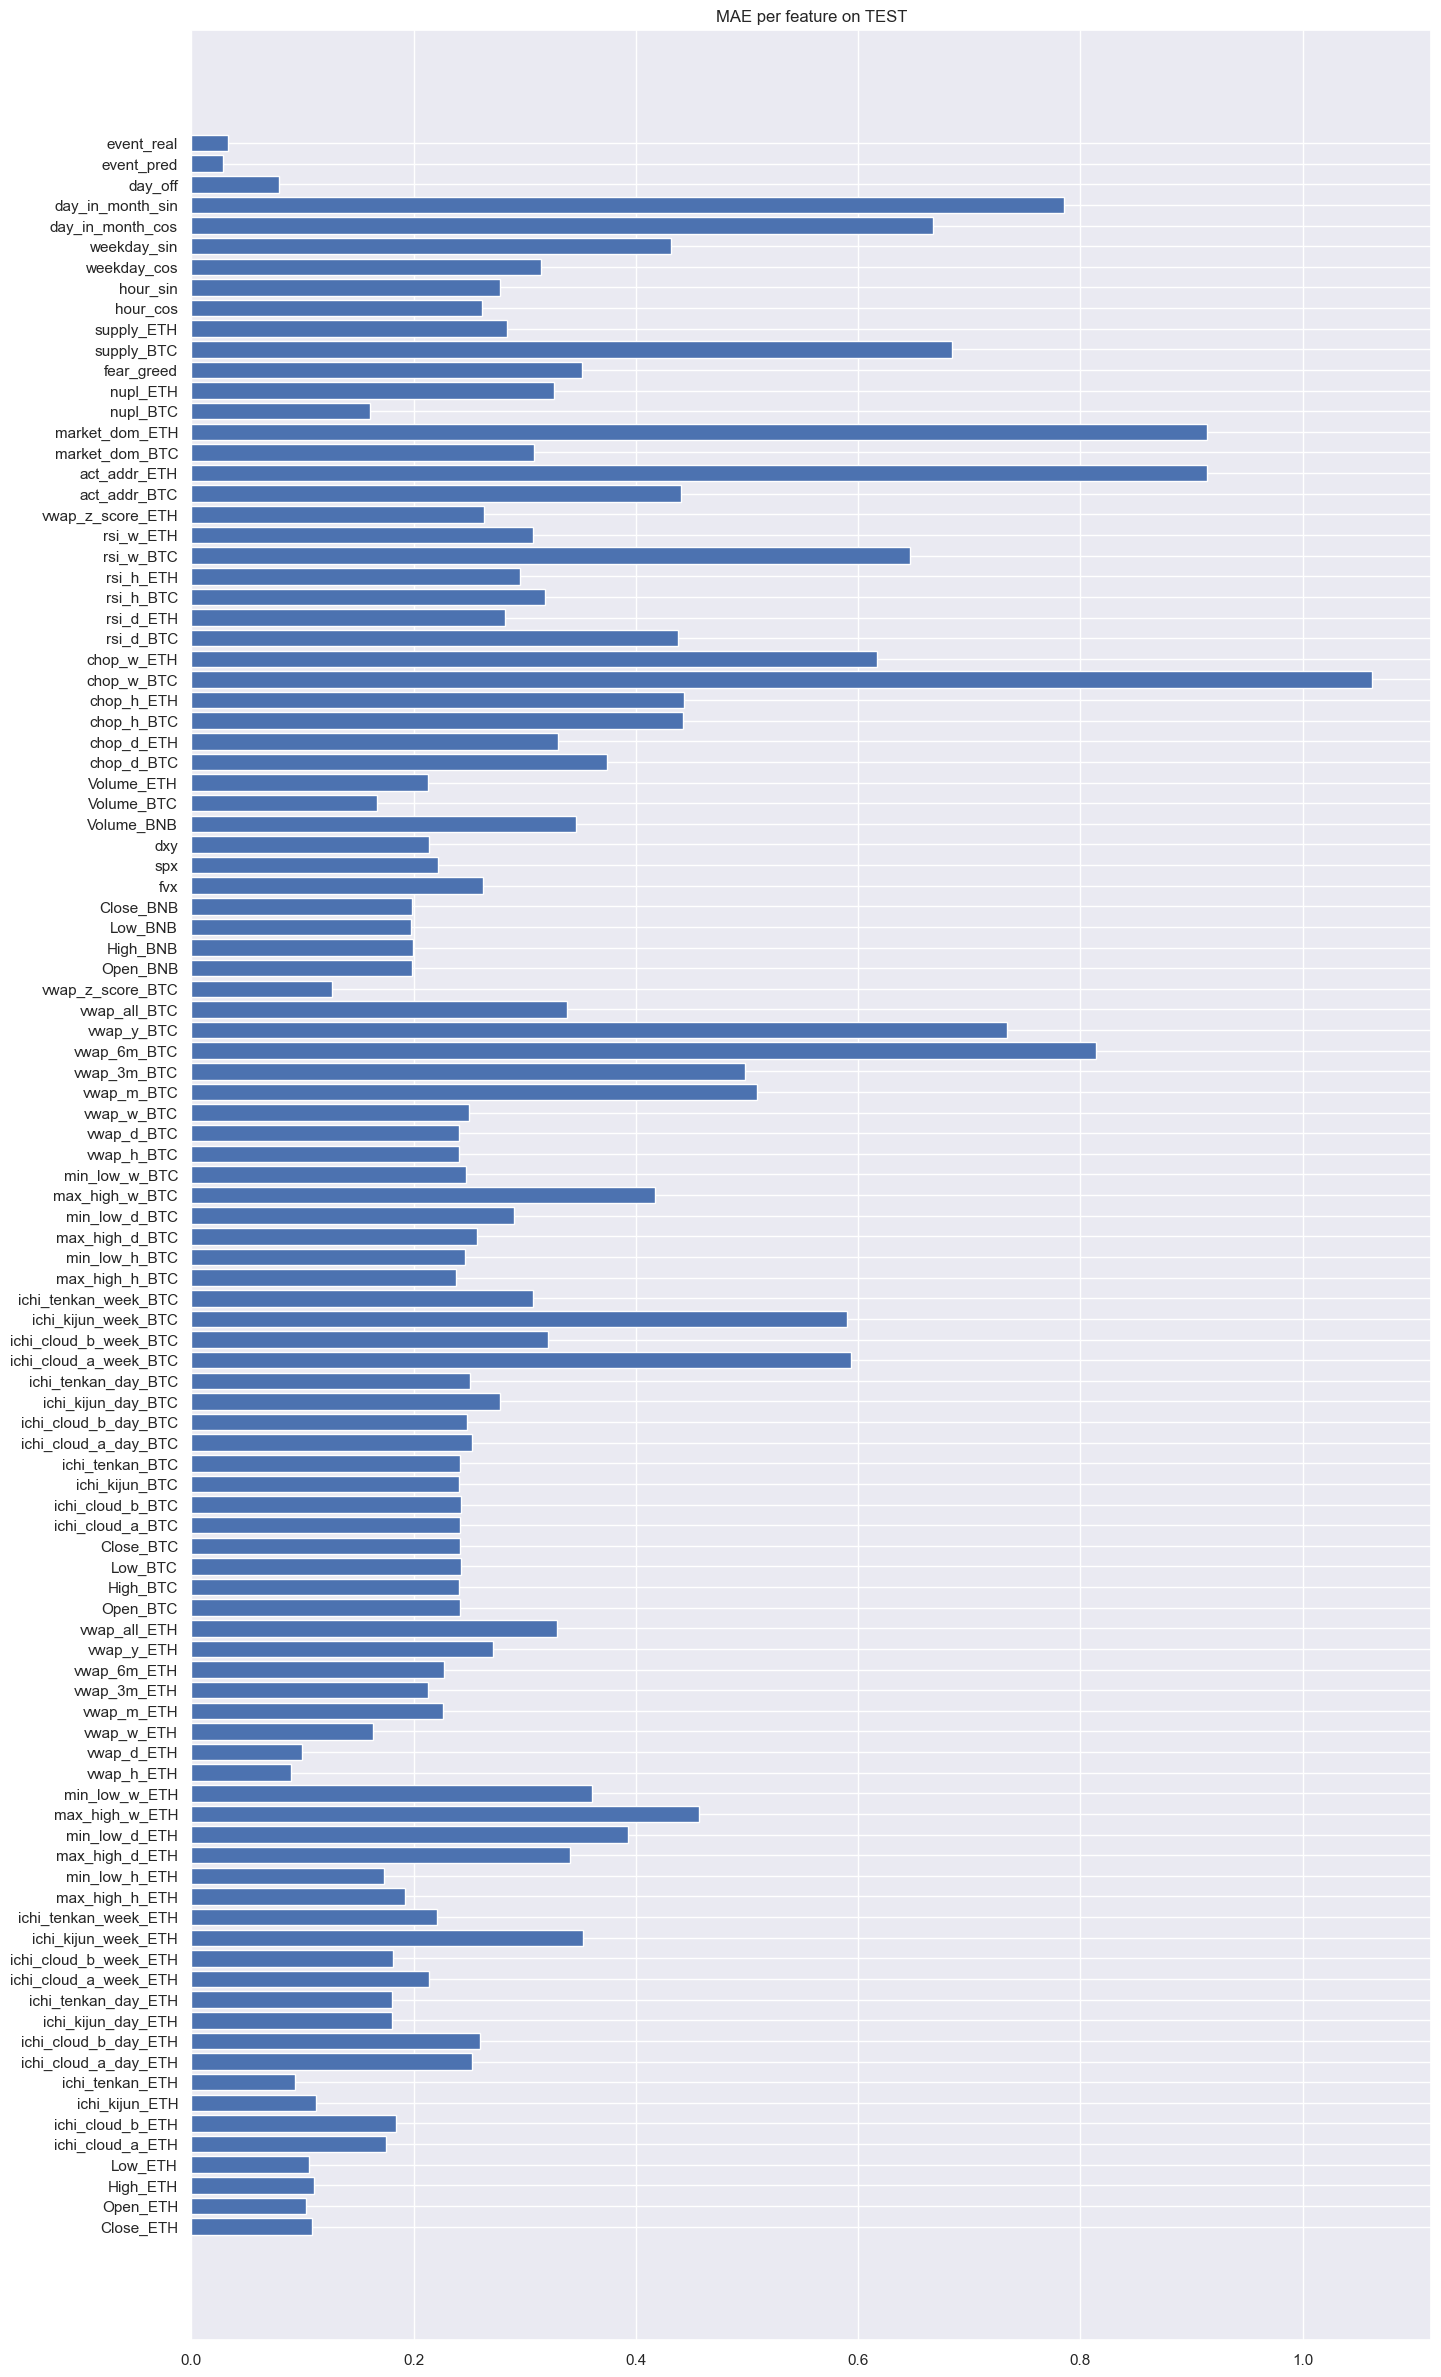

In [116]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_test_feat.columns, df_mae_ae_test_feat.values[0])
plt.title("MAE per feature on TEST")

In [117]:
df_mae_ae_test_feat.values[0]

array([0.10892537, 0.10322414, 0.11009807, 0.10596848, 0.17480656,
       0.18456996, 0.11247336, 0.09345397, 0.25233638, 0.25972824,
       0.18041524, 0.18101432, 0.21393204, 0.18148127, 0.35229057,
       0.22122692, 0.19196162, 0.1738257 , 0.34102494, 0.39273408,
       0.45690114, 0.36031359, 0.08947586, 0.09978938, 0.1638993 ,
       0.22618121, 0.21294772, 0.22747787, 0.27177714, 0.32952501,
       0.24185287, 0.24093147, 0.24265805, 0.24145751, 0.24177989,
       0.2424131 , 0.24072004, 0.24144216, 0.25268414, 0.24808941,
       0.27817276, 0.25045216, 0.59351498, 0.32079106, 0.59026425,
       0.30782955, 0.23807372, 0.246067  , 0.25715412, 0.29052671,
       0.41714257, 0.24696416, 0.2408166 , 0.24106707, 0.25011683,
       0.50870363, 0.49798209, 0.81434092, 0.73438896, 0.33802932,
       0.1267382 , 0.19842224, 0.19948182, 0.1975719 , 0.19861419,
       0.26208335, 0.22229233, 0.21367382, 0.34583623, 0.16745461,
       0.21314689, 0.37448249, 0.33036303, 0.44257609, 0.44310

In [118]:
2/df_mae_ae_test_feat.values[0].sum()

0.06269245511122773

In [119]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.187372
1       TRAIN   Close_ETH  0.136098
2       TRAIN   Close_ETH  0.124593
3       TRAIN   Close_ETH  0.121823
4       TRAIN   Close_ETH  0.120409
...       ...         ...       ...
14683    TEST  event_real  0.031676
14684    TEST  event_real  0.031644
14685    TEST  event_real  0.031601
14686    TEST  event_real  0.031547
14687    TEST  event_real  0.031491

[14688 rows x 3 columns]

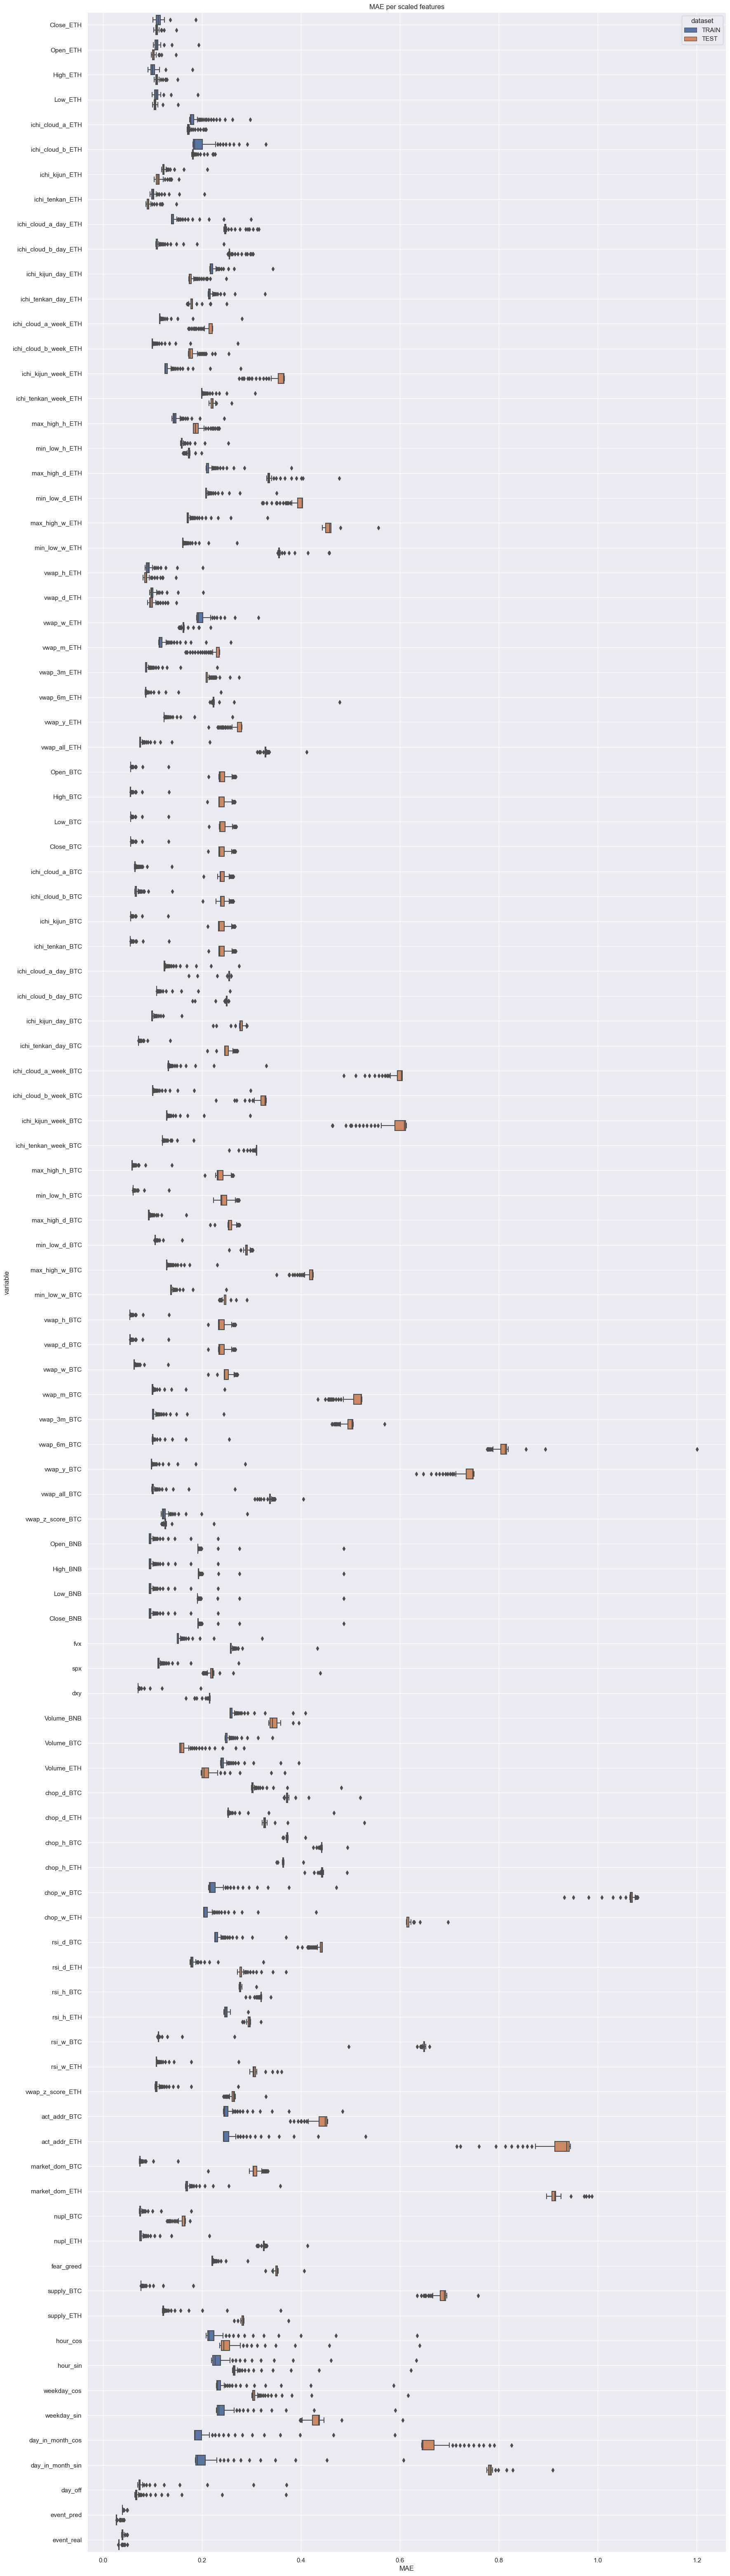

In [120]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MAE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

#### MSE  per features

In [121]:
# values per feat.
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mse_ae_train = np.mean(np.square(X_train_sca_pred - X_train_sca), 0)
print(mse_ae_train.shape)
df_mse_ae_train = pd.DataFrame(mse_ae_train, columns=list_col_select)
df_mse_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_train.index))]

print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mse_ae_test = np.mean(np.square(X_test_sca_pred - X_test_sca), 0)
print(mse_ae_test.shape)
df_mse_ae_test = pd.DataFrame(mse_ae_test, columns=list_col_select)
df_mse_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_test.index))]

# mean per feat.
mse_ae_train_feat = np.mean(mse_ae_train, 0)[np.newaxis,:]
print(mse_ae_train_feat.shape)
df_mse_ae_train_feat = pd.DataFrame(mse_ae_train_feat, columns=list_col_select)

mse_ae_test_feat = np.mean(mse_ae_test, 0)[np.newaxis,:]
print(mse_ae_test_feat.shape)
df_mse_ae_test_feat = pd.DataFrame(mse_ae_test_feat, columns=list_col_select)

# comp train/test
df_mse_ae_test["dataset"] = "TEST"
df_mse_ae_train["dataset"] = "TRAIN"
df_mse_ae_comp = pd.concat([df_mse_ae_train, df_mse_ae_test], ignore_index=False)

df_mse_ae_test_feat["dataset"] = "TEST"
df_mse_ae_train_feat["dataset"] = "TRAIN"
df_mse_ae_comp_feat = pd.concat([df_mse_ae_train_feat, df_mse_ae_test_feat], ignore_index=False)

df_mse_ae_comp = df_mse_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MSE")



(55646, 72, 102)
(55646, 72, 102)
(72, 102)
(13845, 72, 102)
(13845, 72, 102)
(72, 102)
(1, 102)
(1, 102)


In [122]:
df_mse_ae_comp_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.029153  0.027592  0.024066  0.026904          0.137677   
0   0.032583  0.029139  0.027690  0.032844          0.066882   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.132372        0.032221         0.023053              0.041624   
0          0.075625        0.032756         0.022499              0.096675   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0              0.027636  ...  0.084547  0.092026     0.090477     0.095108   
0              0.098774  ...  0.115275  0.127191     0.148026     0.319474   

   day_in_month_cos  day_in_month_sin   day_off  event_pred  event_real  \
0          0.071485          0.073704  0.061927    0.996568    0.997952   
0          0.632348          0.923920  0.013597    0.319608    0.771419   

   dataset  
0    TRAIN  
0     TEST  

[2 rows x 103 columns]

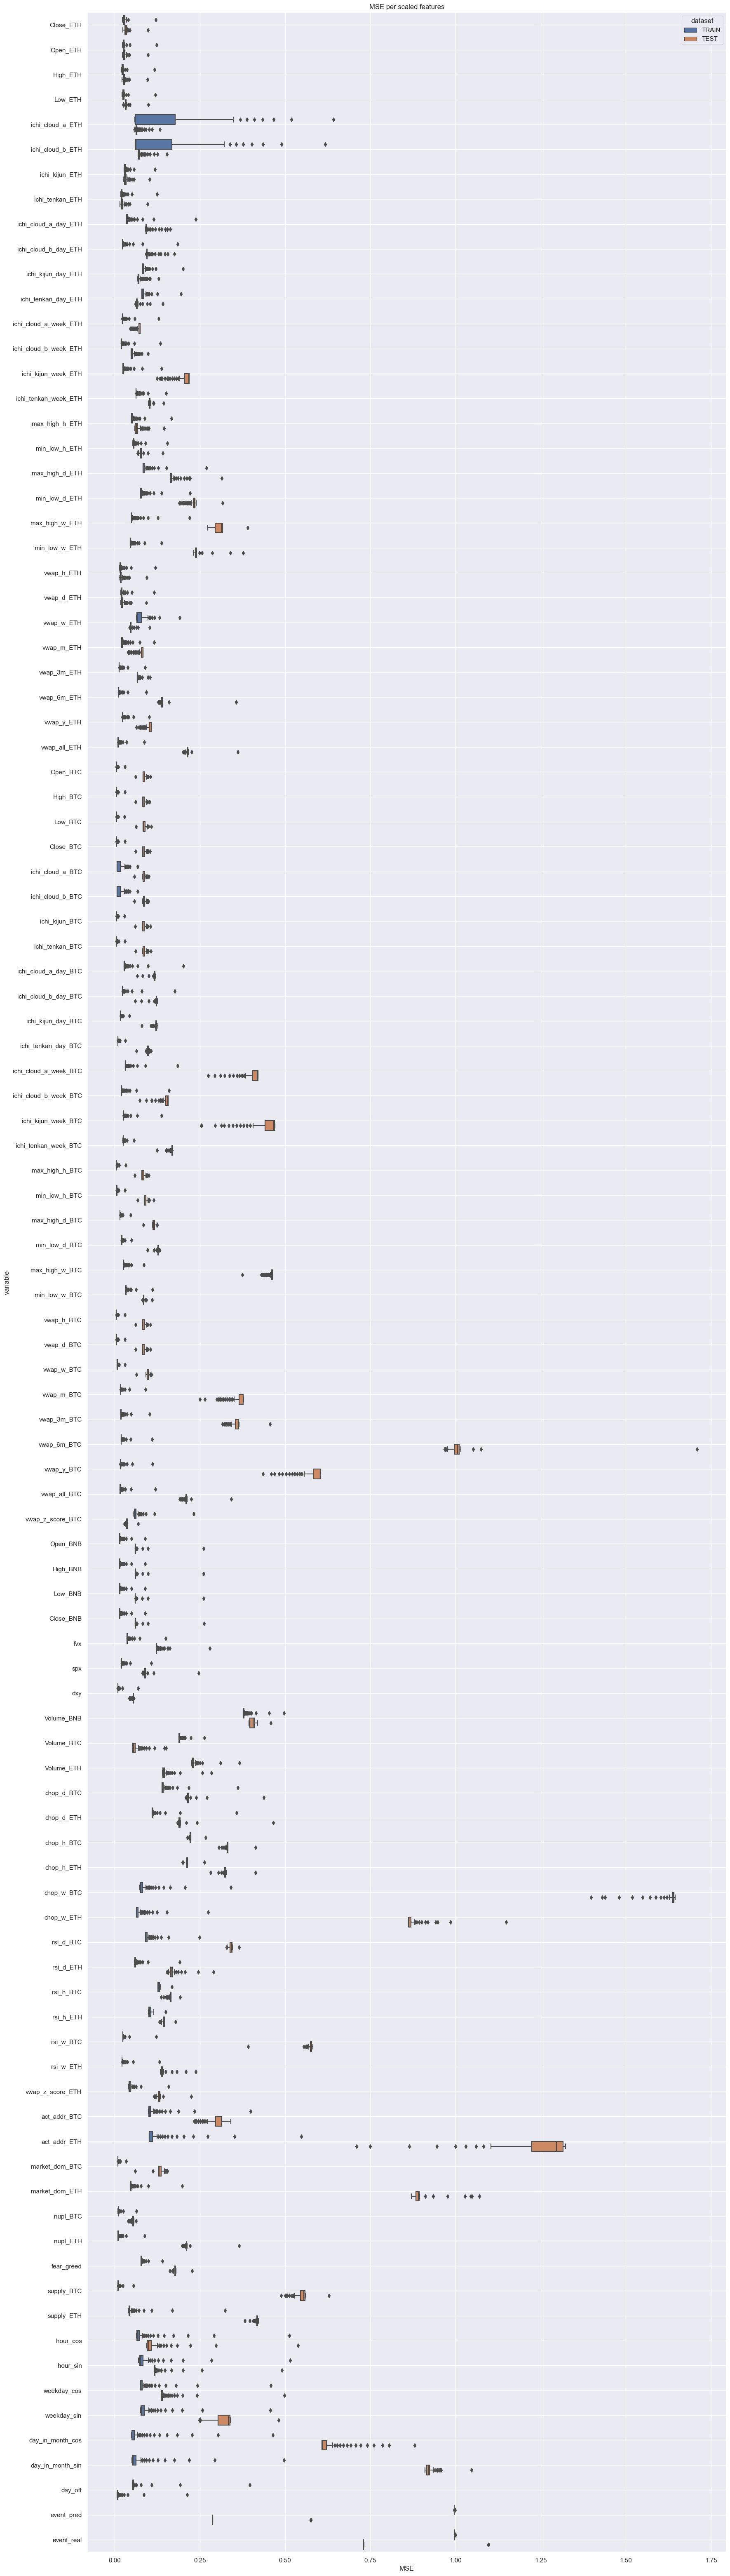

In [123]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_mse_ae_comp, x="MSE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MSE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MSE - {name_plt}.jpg")
)

Text(0.5, 1.0, 'MSE per feature on TRAIN')

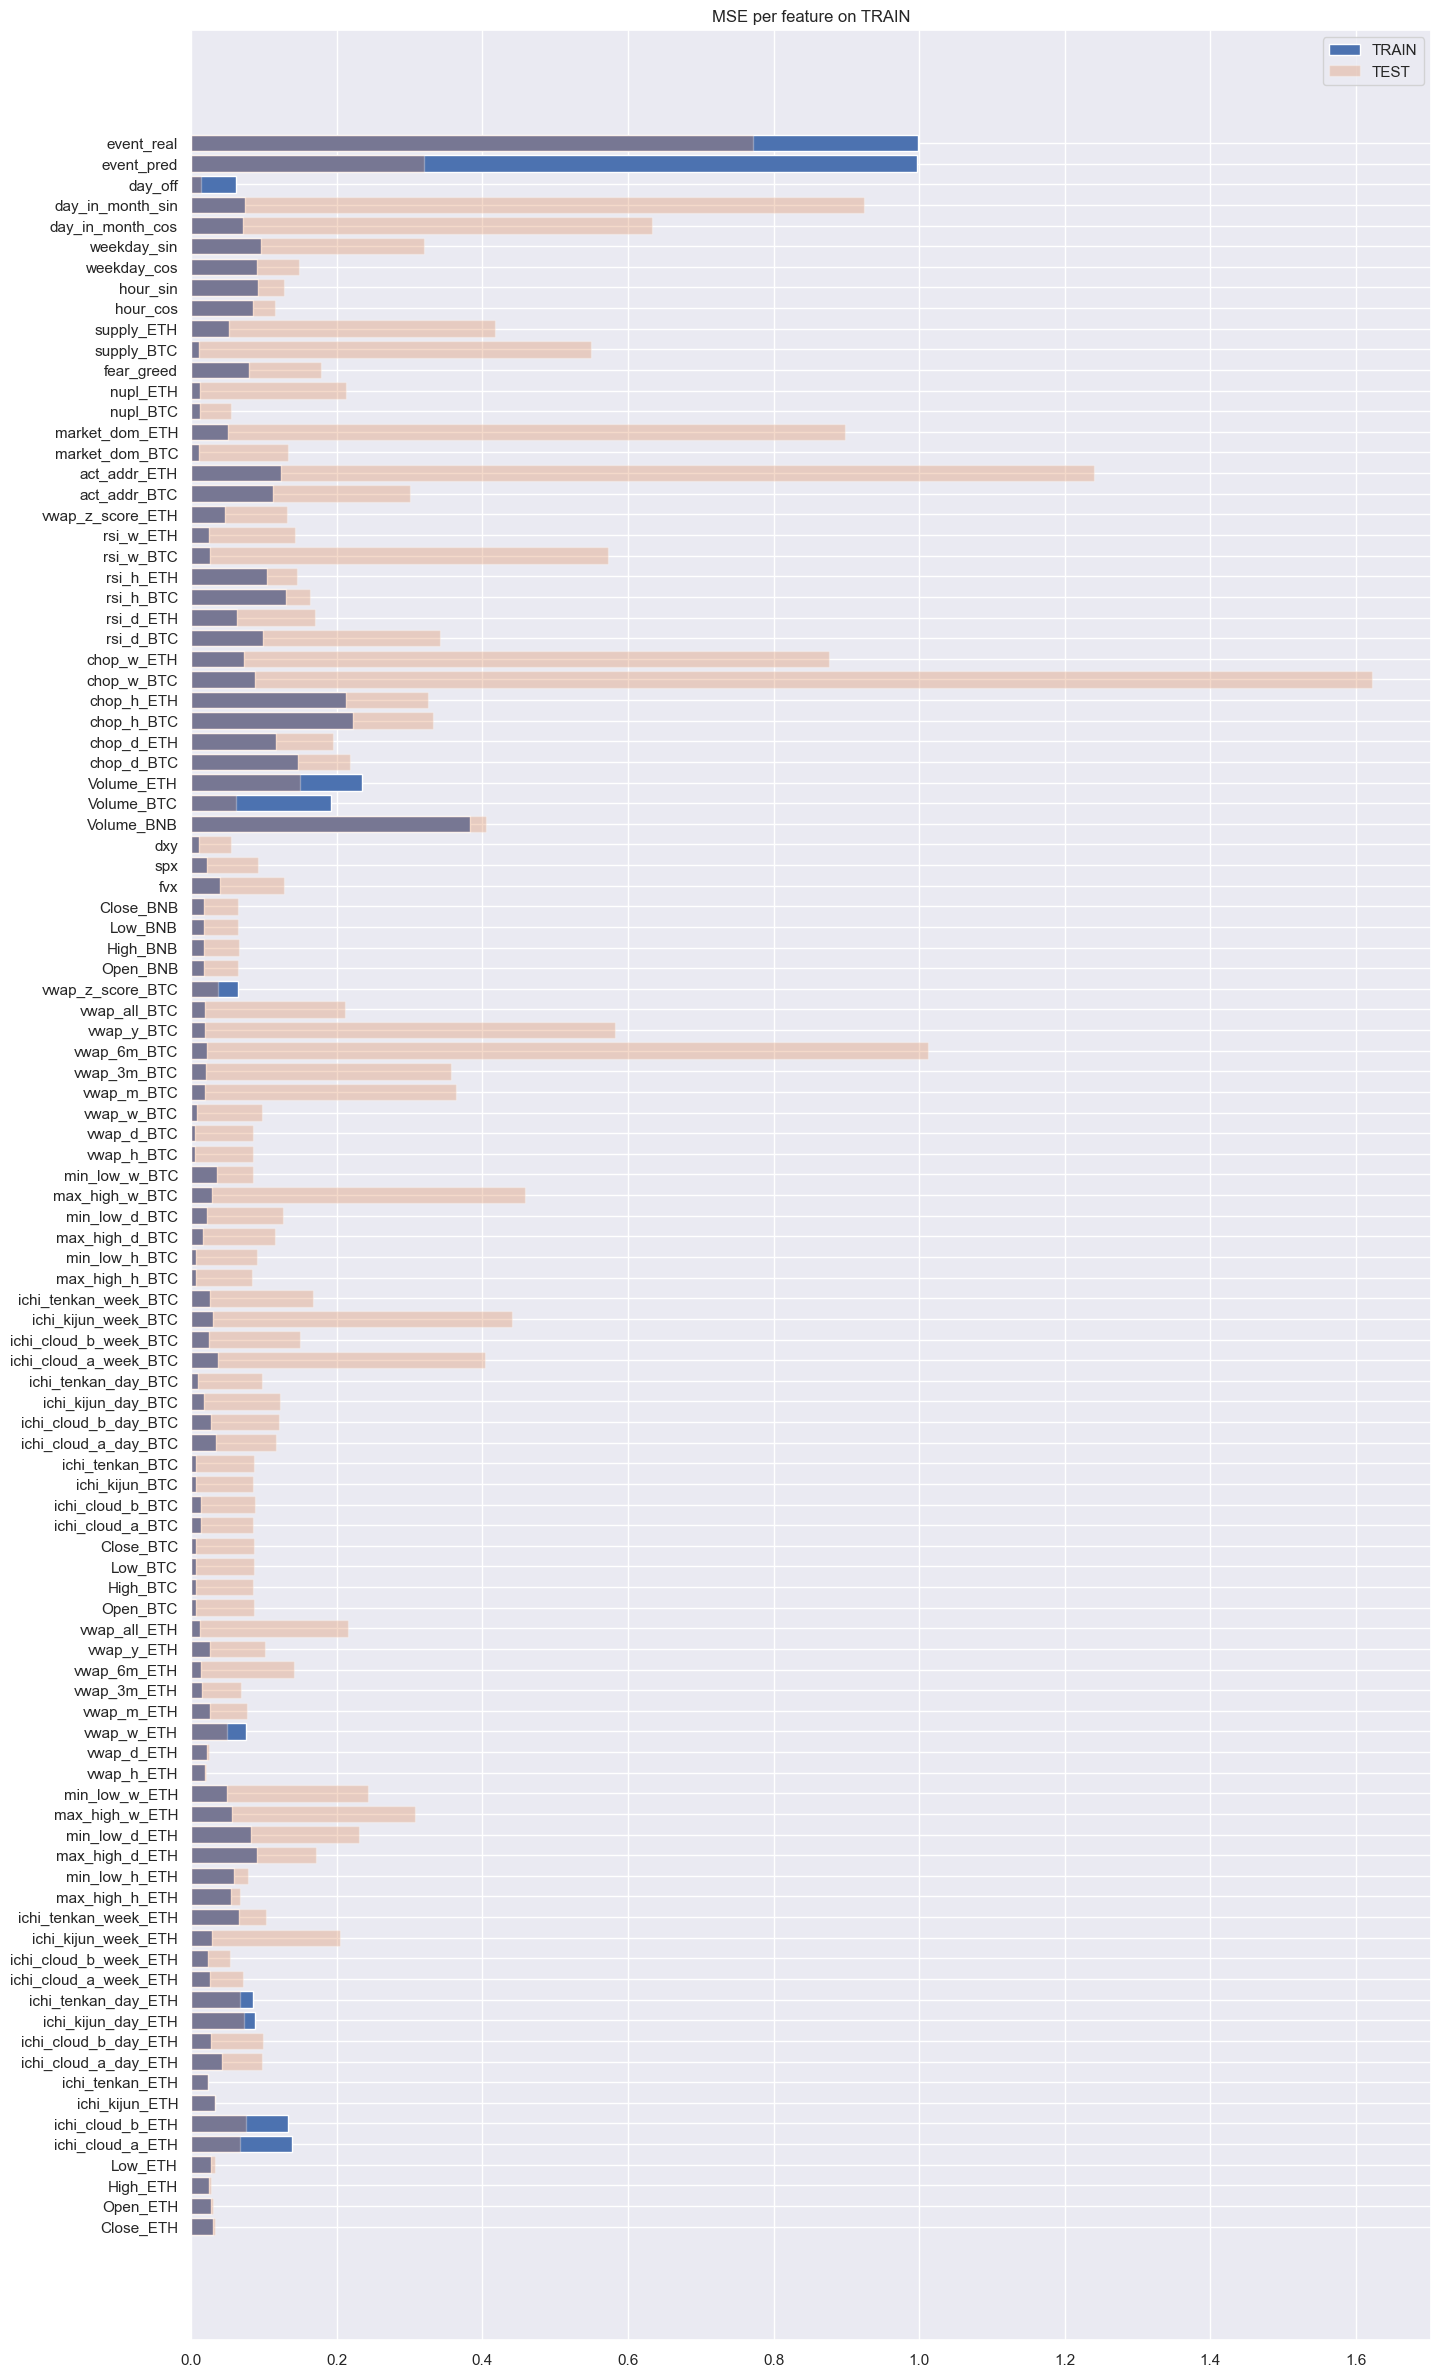

In [124]:
plt.figure(figsize=(16, 30))
plt.barh(list_col_select, df_mse_ae_train_feat.values[0,:-1], label="TRAIN")
plt.barh(list_col_select, df_mse_ae_test_feat.values[0,:-1], label="TEST", alpha=0.3)
plt.legend(loc='upper right')
#plt.barh(df_mse_ae_test_feat.columns, df_mse_ae_test_feat.values[0])
plt.title("MSE per feature on TRAIN")

In [125]:
encoder_model.layers[3].get_weights()

[array([[ 0.09735621, -0.13534741, -0.2731671 , ..., -0.28497565,
          0.09832506,  0.34697947],
        [ 0.04755156,  0.15124433, -0.11322425, ..., -0.12173507,
         -0.02576912,  0.33678526],
        [-0.47103134, -0.36056504, -0.71841115, ...,  0.09272866,
          0.12902151, -0.20764689],
        ...,
        [ 0.05180823, -0.04859613,  0.22824025, ..., -0.14752005,
          0.25913665,  0.11274992],
        [-0.16654304, -0.282974  ,  0.05955701, ..., -0.03973658,
          0.03370401,  0.18175137],
        [ 0.03336066, -0.13162462, -0.1833487 , ...,  0.05053541,
          0.33263183, -0.07420547]], dtype=float32),
 array([ 0.02475498,  0.5481986 , -0.13960803, -0.22331536,  0.16206996,
         0.28944027,  0.5789436 , -0.05311963,  0.4611521 , -0.2142034 ,
        -0.04581945, -0.6600265 ,  0.10794979, -0.291972  ,  0.22934006,
         0.3058436 ], dtype=float32)]

## Prediction Models

### LSTM all features

In [126]:
X_train_sca.shape

(55646, 72, 102)

In [127]:
X_train_sca.shape[-1]

102

In [128]:
X_train_sca.shape[-2:]

(72, 102)

In [129]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    patience = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=patience,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [130]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [131]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

1739/1739 [==============================] - 21s 12ms/step


(55646, 72, 16)

In [132]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

433/433 [==============================] - 5s 12ms/step


(13845, 72, 16)

In [133]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [134]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [135]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [136]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((55646, 72, 20), (13845, 72, 20))

#### Correlations

In [137]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



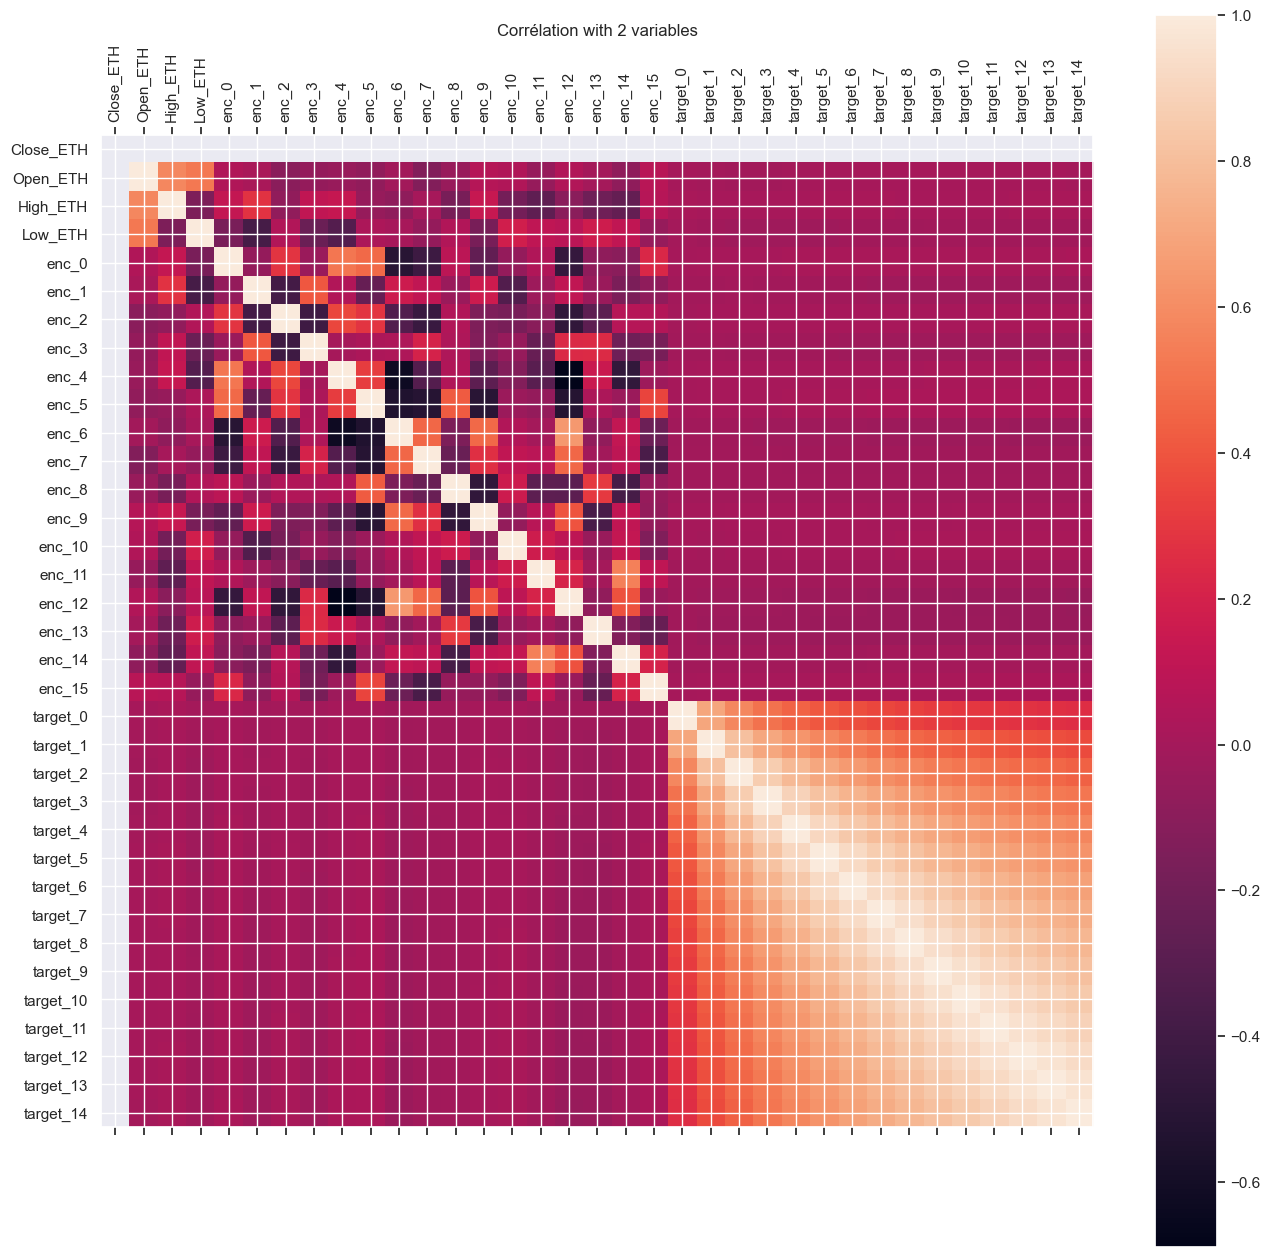

In [138]:
fig = plot_corr(corr_matrix_min)

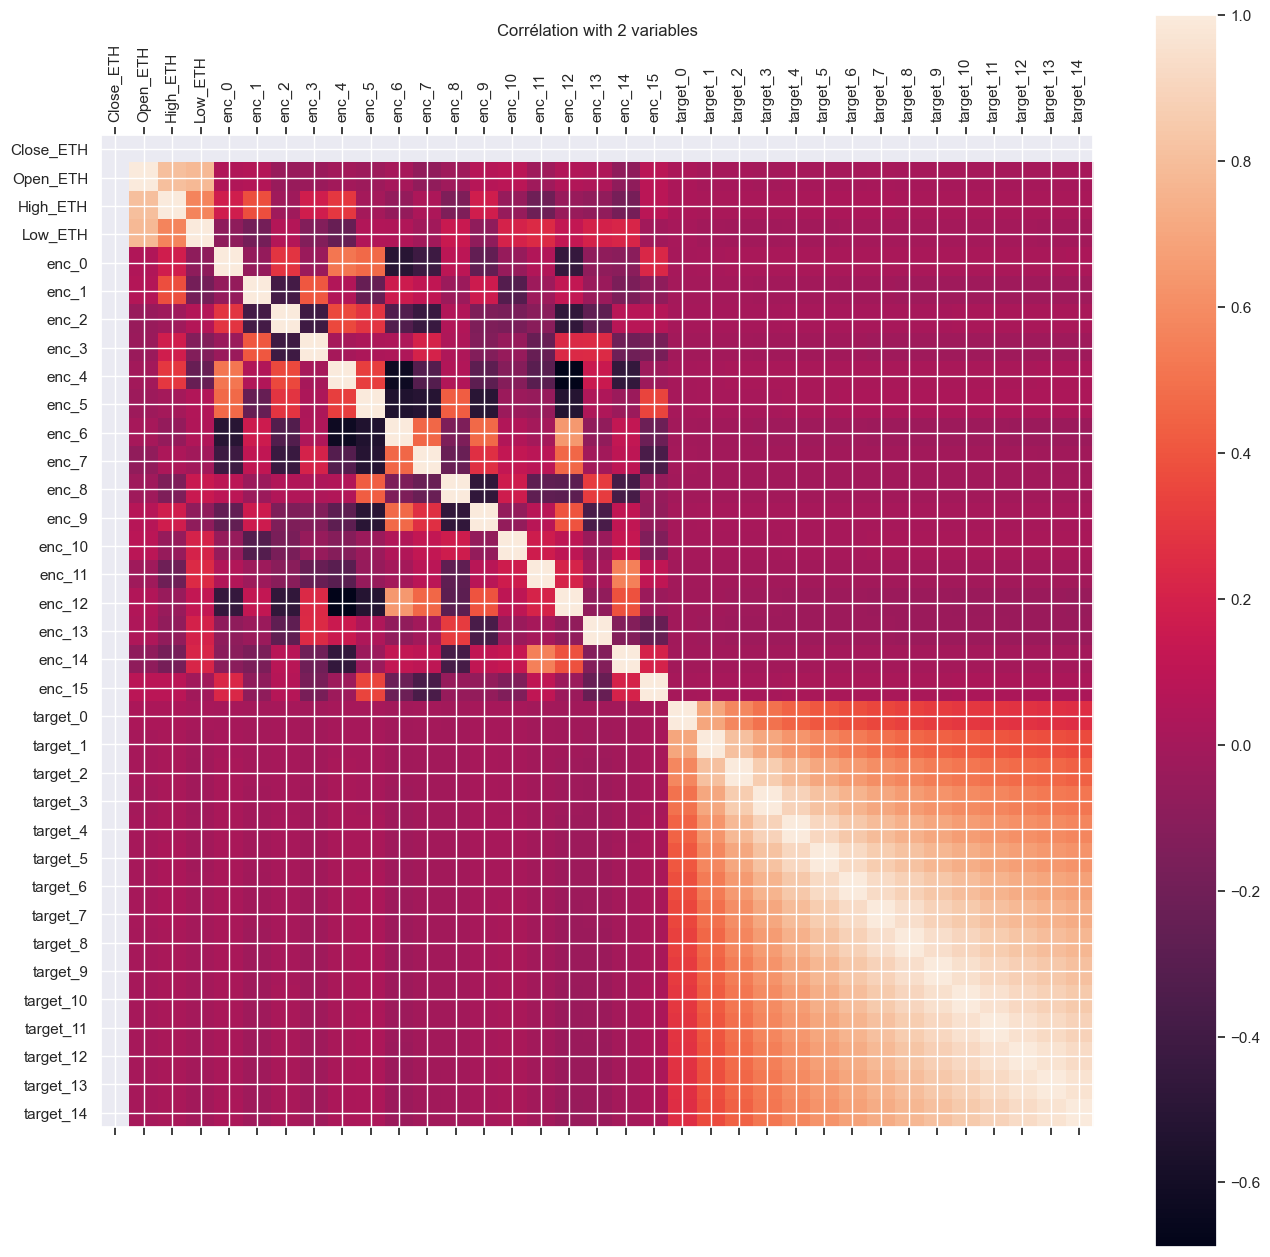

In [139]:
fig = plot_corr(corr_matrix_max) 

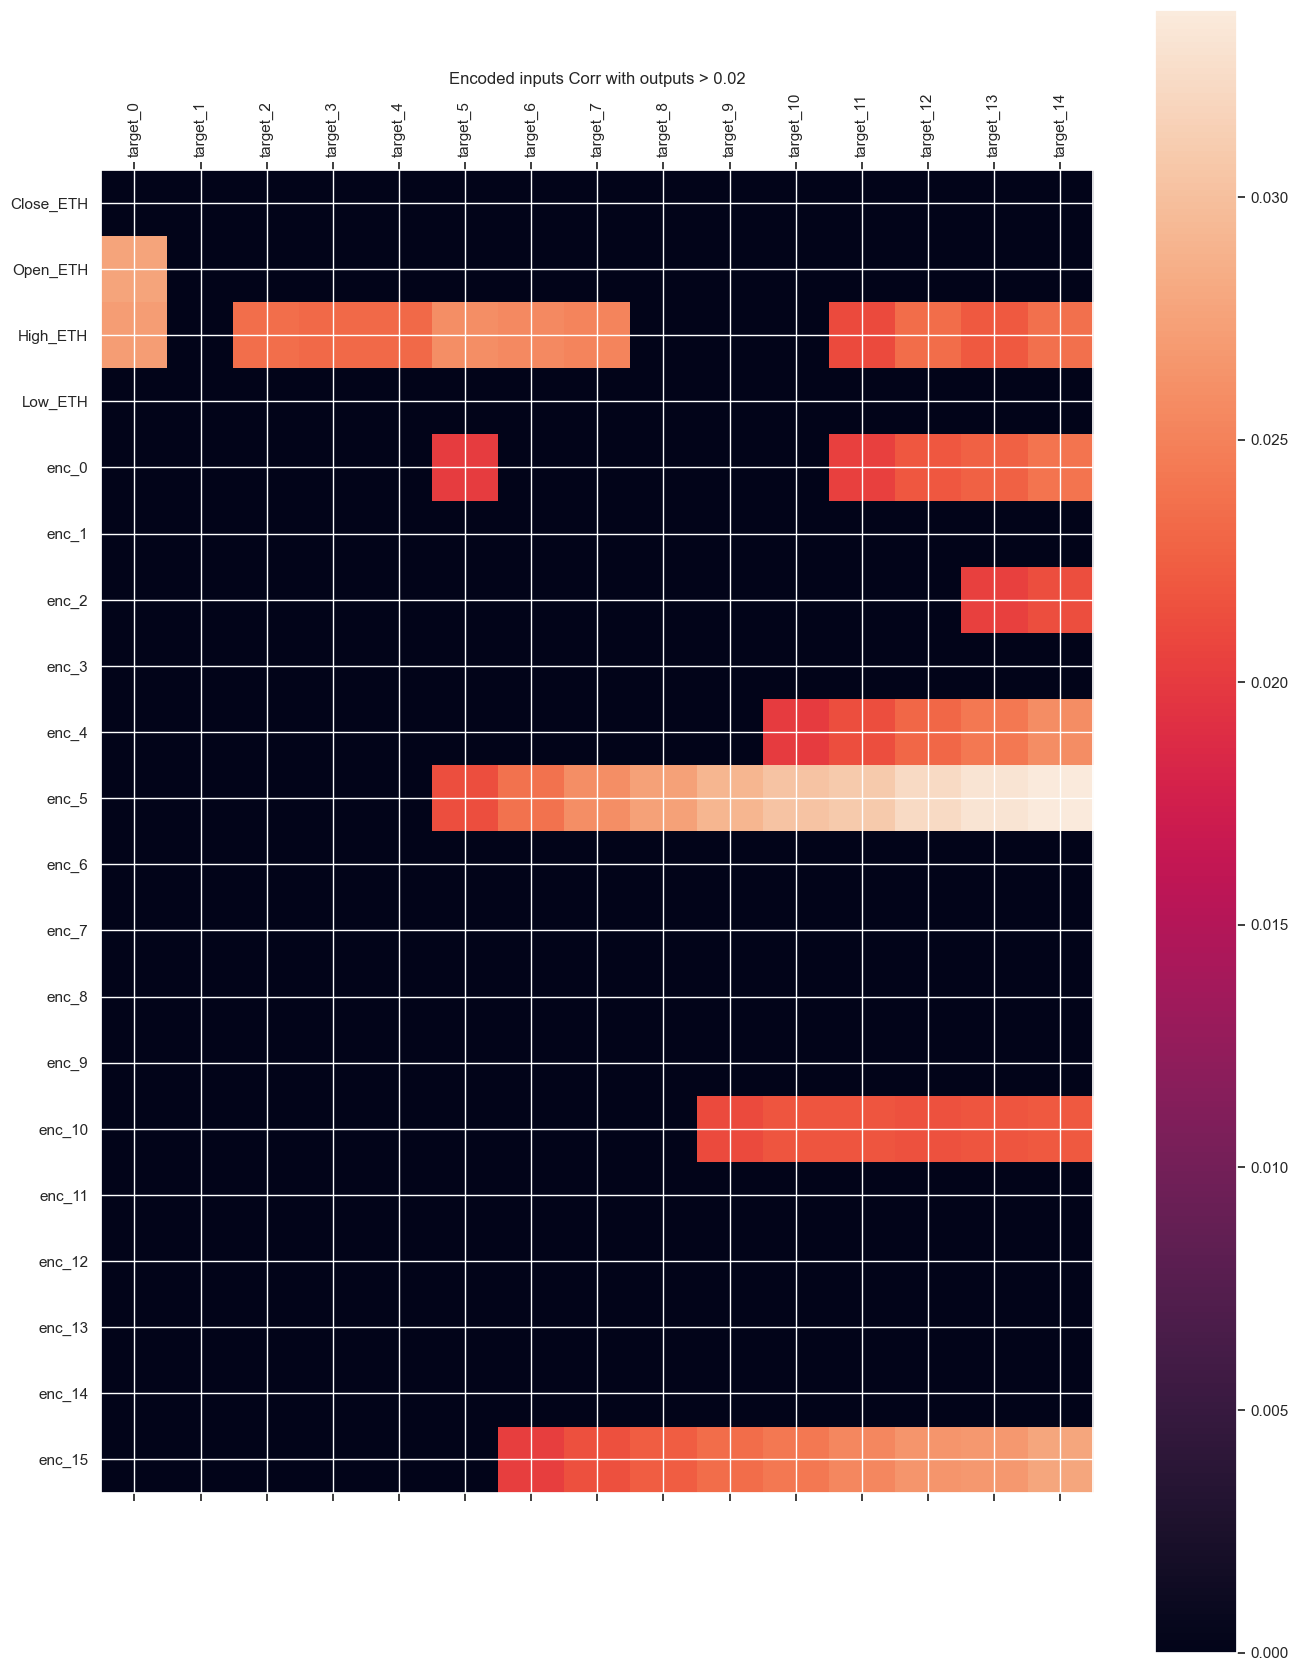

In [140]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

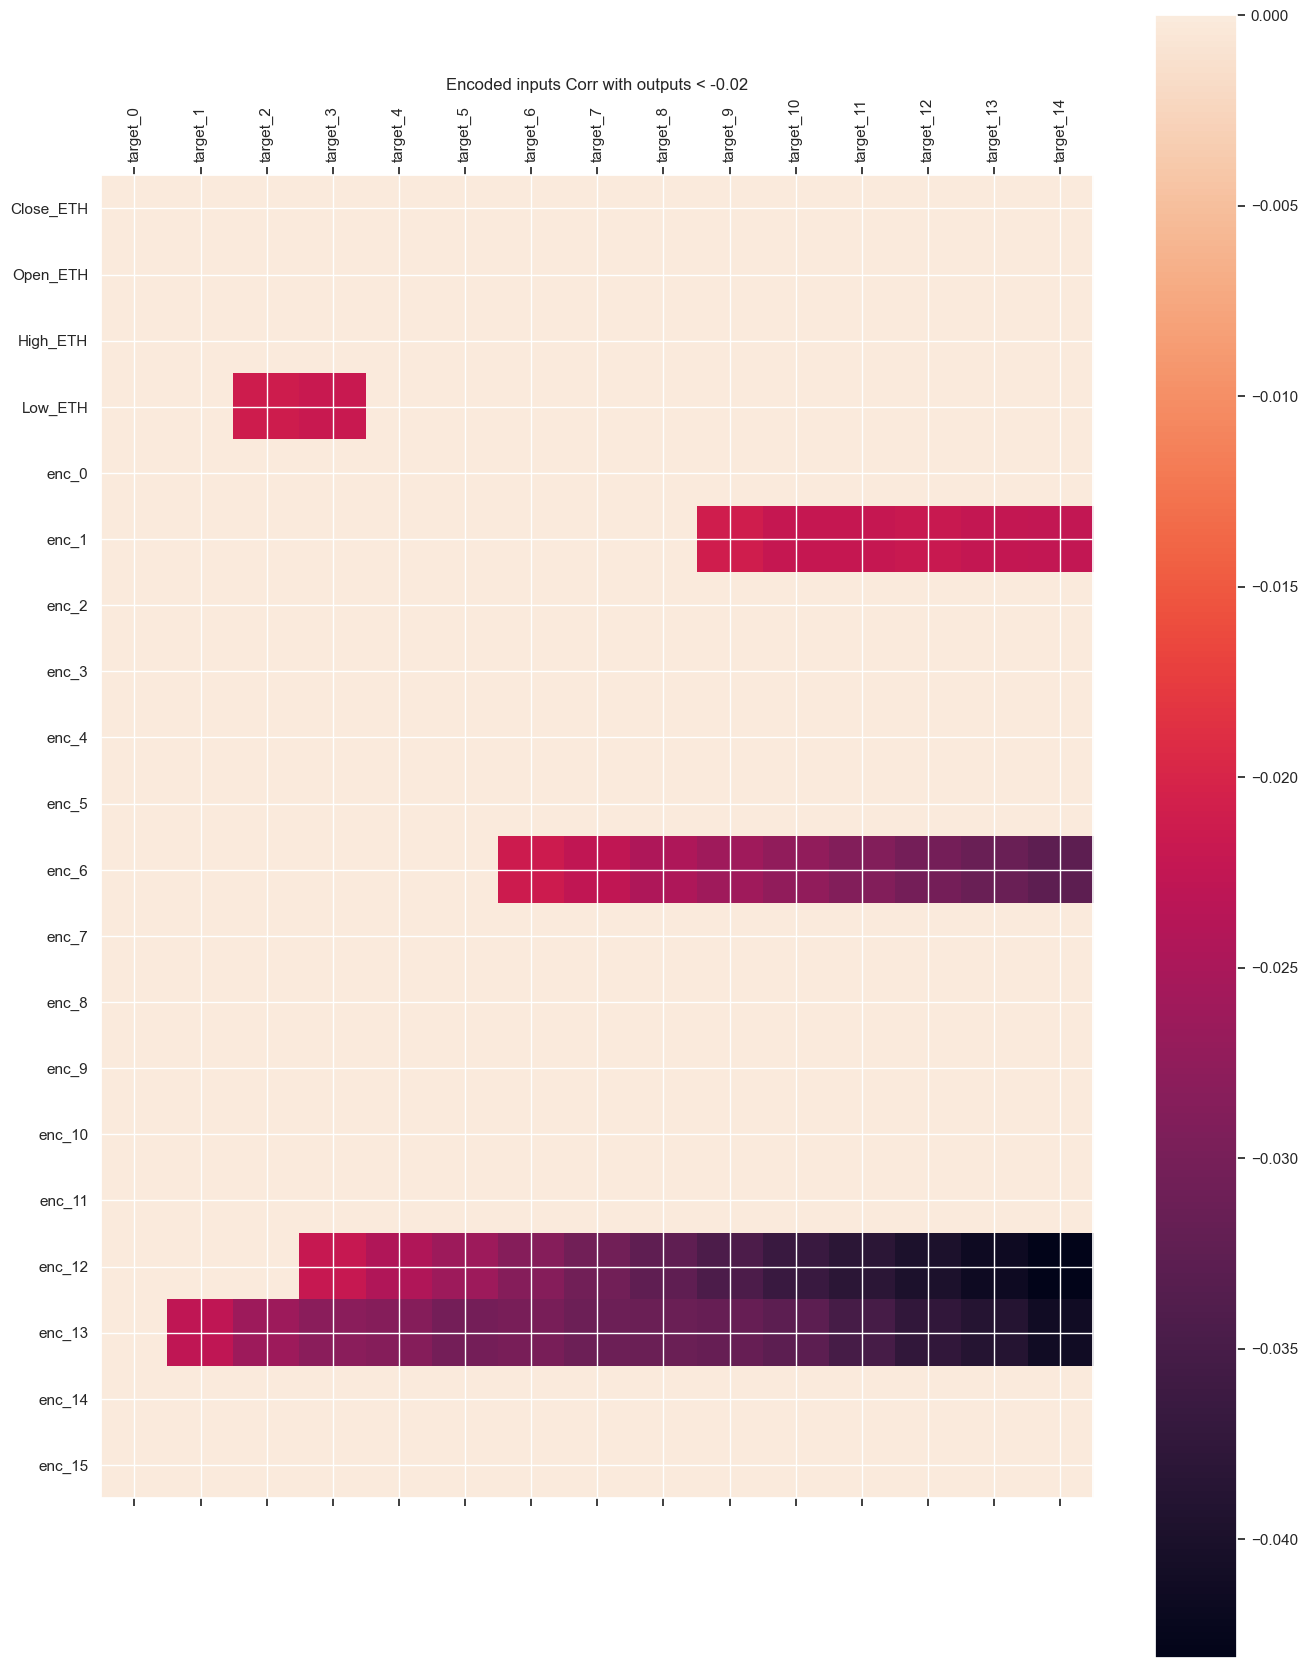

In [141]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [142]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [143]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [144]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [145]:
MODE_AUTO_SELECT

2

In [146]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[0, 1, 2, 4, 5, 6, 10, 12, 13, 15]
nb encoded features:  10


In [147]:
X_train_.shape

(55646, 72, 20)

In [148]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 14, 16, 17, 19])

In [149]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [150]:
X_train_.shape

(55646, 72, 14)

#### Train

In [151]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 20#30
patience = 0#10
#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)
seed = 1
mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in [128]: #[32, 64, 128]: #[128]: #
        for dropout_rate in  [0.15]: #[0.05, 0.15, 0.25]: #[0.1]:

            tf.keras.backend.clear_session()
            np.random.seed(seed)
            random.seed(seed)
            tf.random.set_seed(seed)
            optim = tf.keras.optimizers.legacy.Adam()
            if patience is not None:
                es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                verbose=1, patience=patience,
                                                restore_best_weights=True)
            # create model
            multi_step_model = tf.keras.models.Sequential()
            multi_step_model.add(
                tf.keras.layers.LSTM(
                    n_units,
                    return_sequences=False,
                    input_shape=X_train_.shape[-2:],
                    #kernel_regularizer=reg,
                    #bias_regularizer=reg,
                )
            )
            multi_step_model.add(tf.keras.layers.LayerNormalization())
            multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
            #multi_step_model.add(tf.keras.layers.BatchNormalization())
            multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
            # compile
            multi_step_model.compile(optimizer=optim, loss='mse')
            # fitting
            if patience == 0:
                multi_step_history = multi_step_model.fit(
                    X_train_, y_train_sca, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_, y_test_sca), 
                    verbose=1,
                )
            else:
                multi_step_history = multi_step_model.fit(
                    X_train_, y_train_sca, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_, y_test_sca), 
                    verbose=1, 
                    callbacks=[es],
                )
            # eval
            mse_curr = np.min(multi_step_history.history['val_loss'])
            print("MSE TEST : ", mse_curr)

            # plot MSE
            name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
            plot_train_history(
                multi_step_history,
                f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                saveFolder="data",
            )

            # save the best
            if mse_curr_min == None:
                mse_curr_min = mse_curr
                n_units_min = n_units
                dropout_rate_min = dropout_rate

                print("Save model: ", path_mdl_predict_autoenc_lstm)
                multi_step_model.save(path_mdl_predict_autoenc_lstm)
            else:
                if mse_curr < mse_curr_min:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate
                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

else:
    
    print("Load model: ", path_mdl_predict_autoenc_lstm)
    multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
    n_units = multi_step_model.layers[0].units#32
    dropout_rate = multi_step_model.layers[2].rate#0.25
    print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")
    print(multi_step_model.summary())

Load model:  data/mdl_predict_autoenc_lstm
Best model: n_units=128 / dropout= 0.15
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               73216     
                                                                 
 layer_normalization (Layer  (None, 128)               256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 15)                1935      
                                                                 
Total params: 75407 (294.56 KB)
Trainable params: 75407 (294.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
N

In [152]:
 print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")

Best model: n_units=128 / dropout= 0.15


In [153]:
np.min(y_train)

0.925613296000411

In [154]:
np.max(y_train)

1.0749270774292548

#### Results

##### Save mdl

In [155]:
X_train_.shape

(55646, 72, 14)

##### Predict

In [156]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

433/433 [==============================] - 5s 12ms/step


##### Plots

In [157]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(55650,)
(55650,)


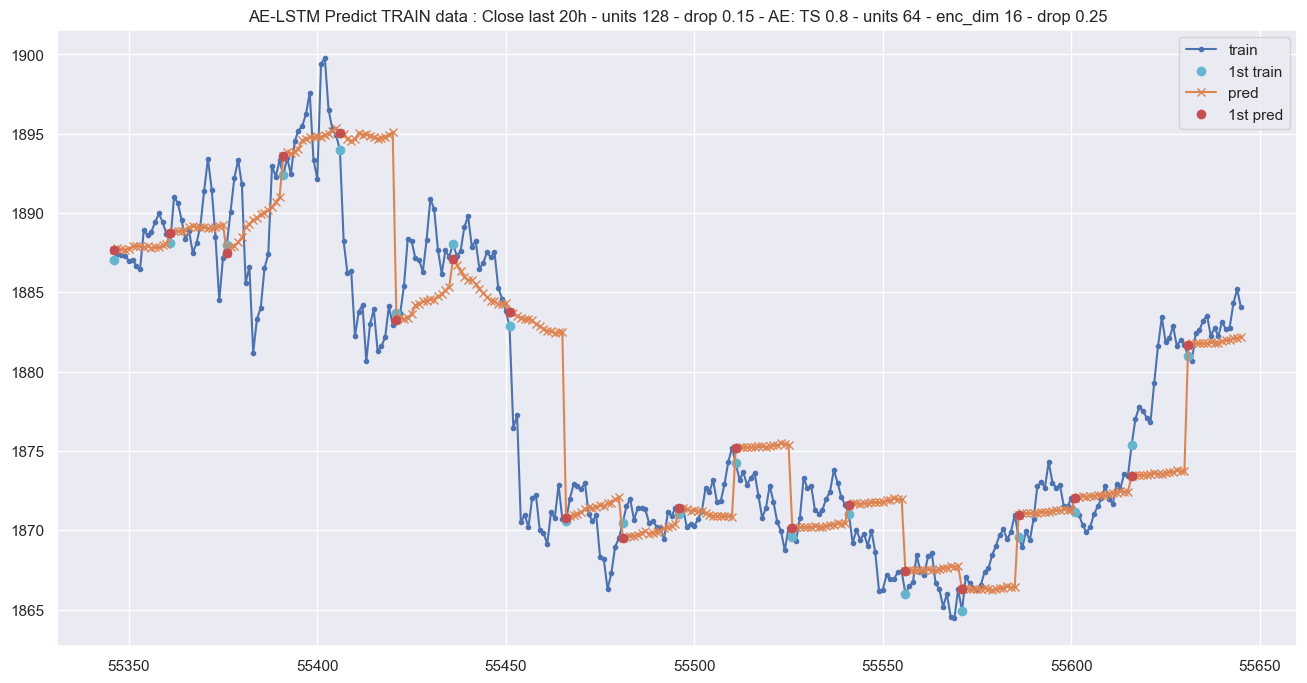

In [158]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

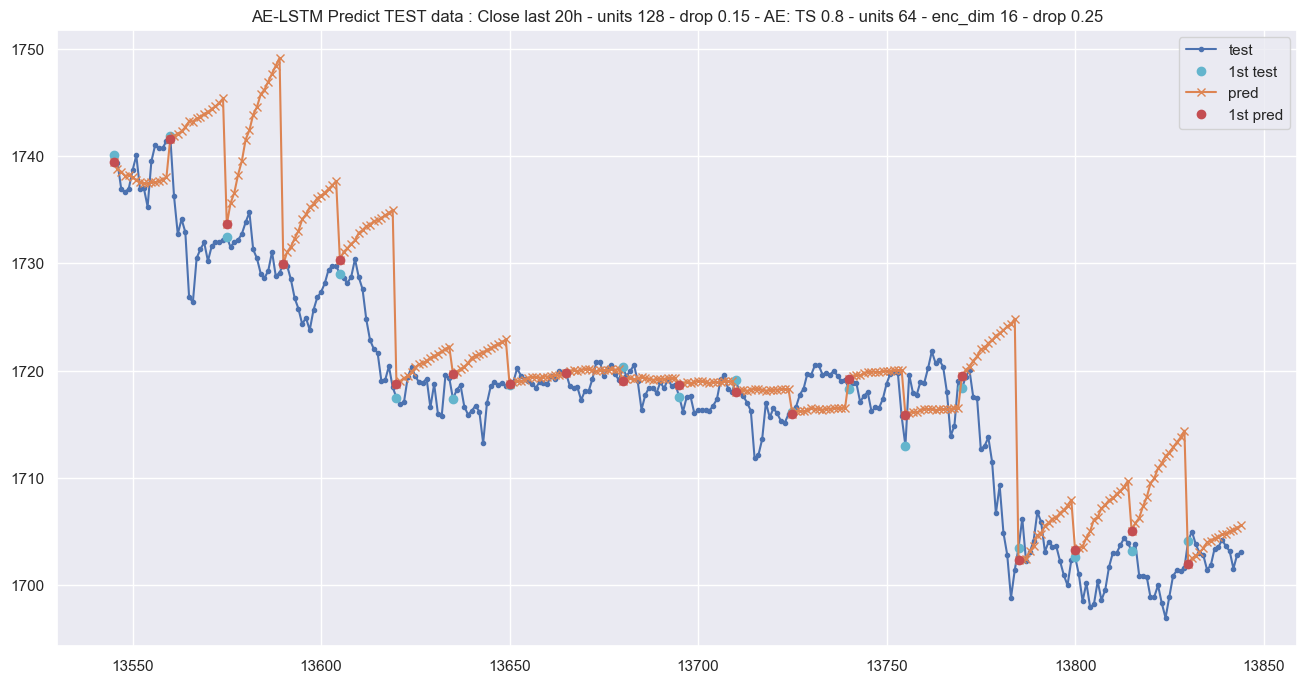

In [159]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

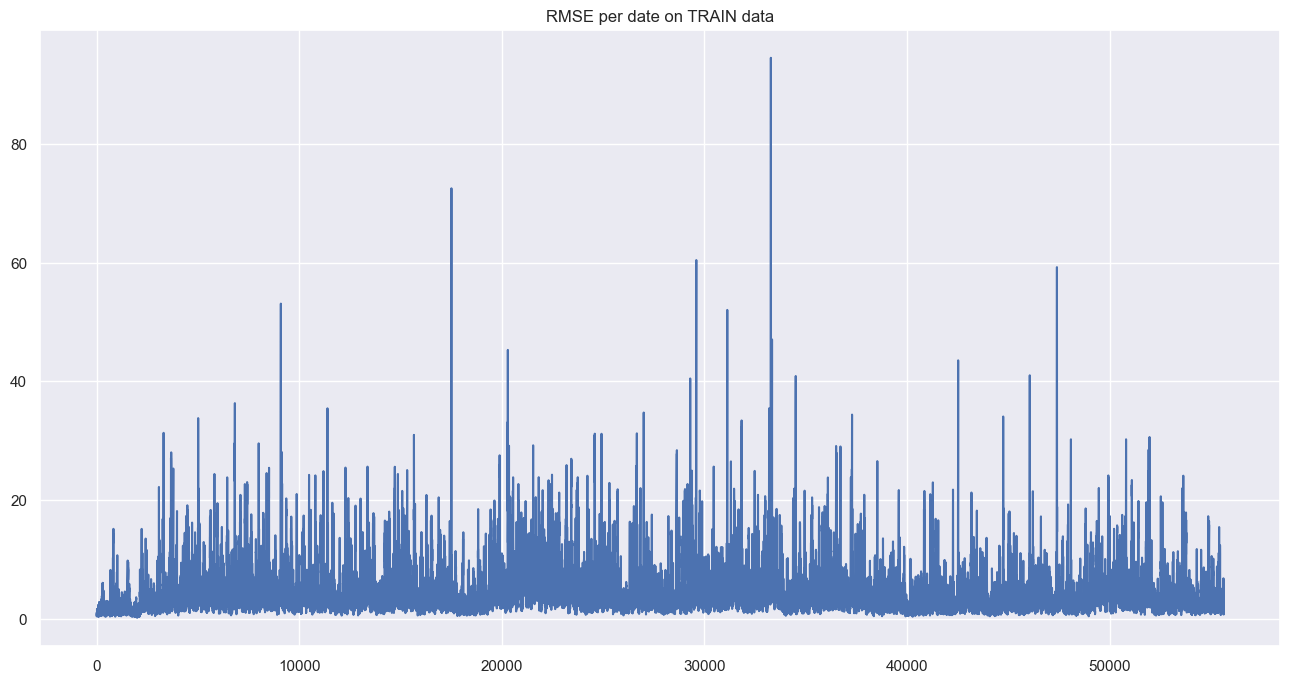

In [160]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

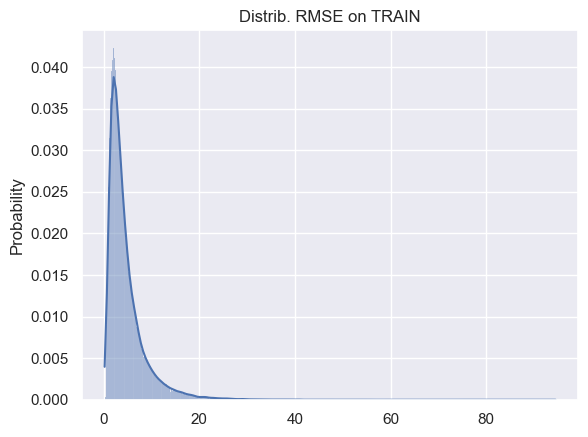

In [161]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 4.64')

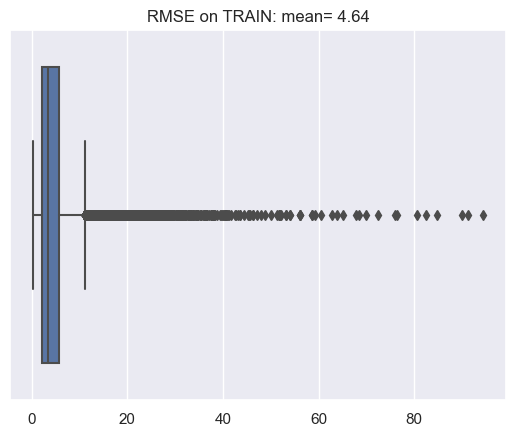

In [162]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

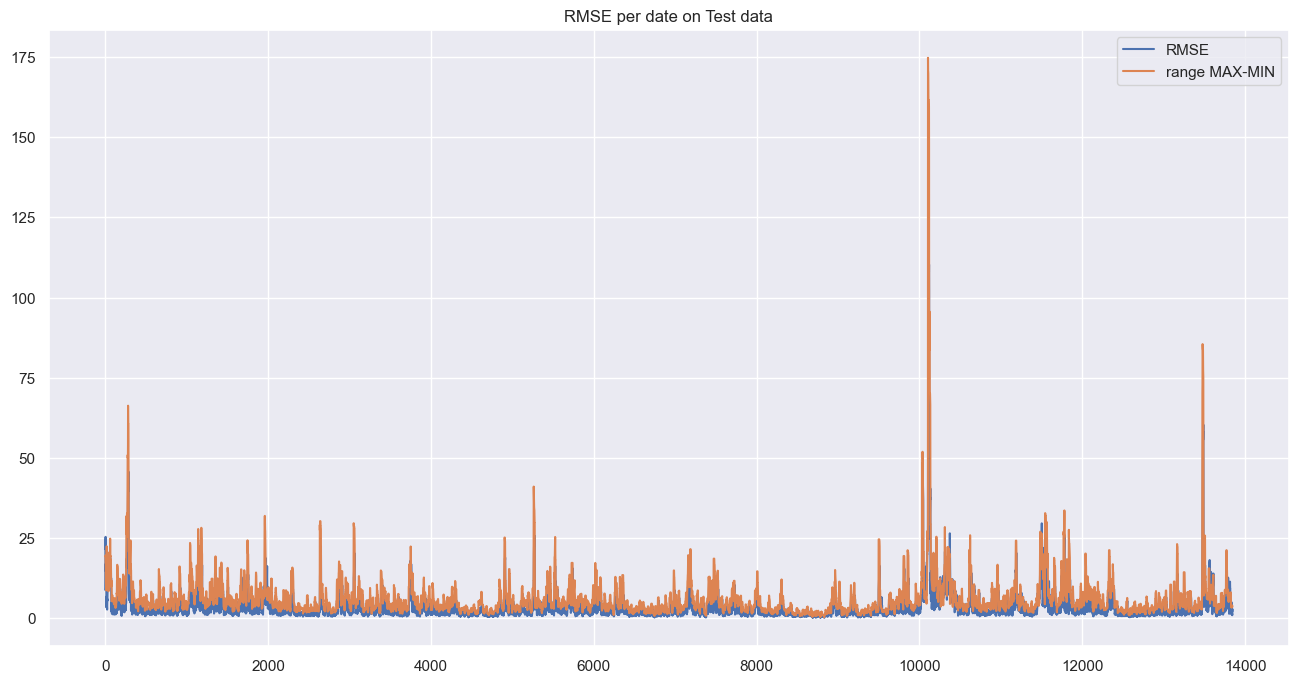

In [163]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [164]:
np.mean(arr_range)

6.40692379920549

<AxesSubplot: ylabel='Probability'>

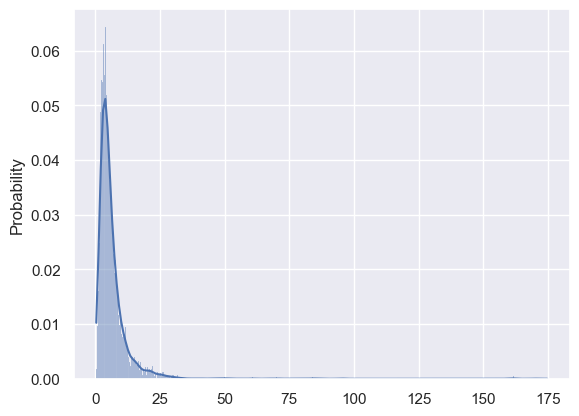

In [165]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [166]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

5.697598162447022

<AxesSubplot: ylabel='Probability'>

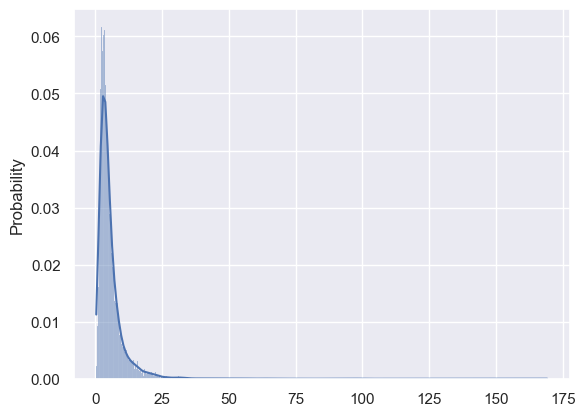

In [167]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

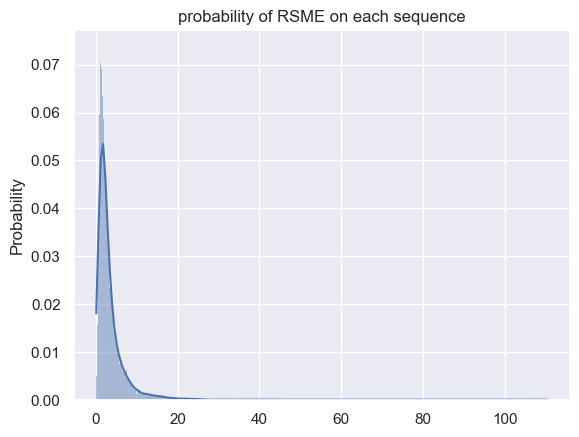

In [168]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

(0.0, 32.03461899602745)

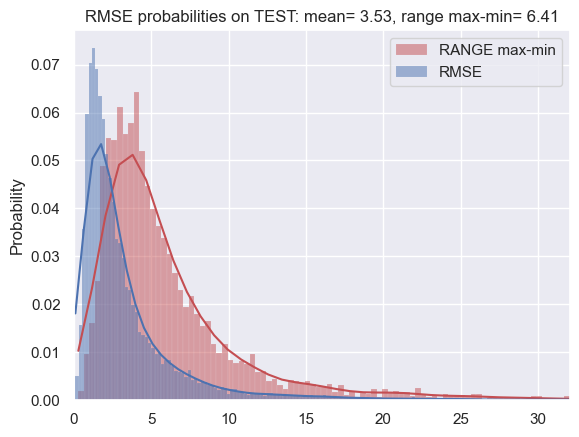

In [169]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE probabilities on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_range)*5])

(0.0, 17.64365556473247)

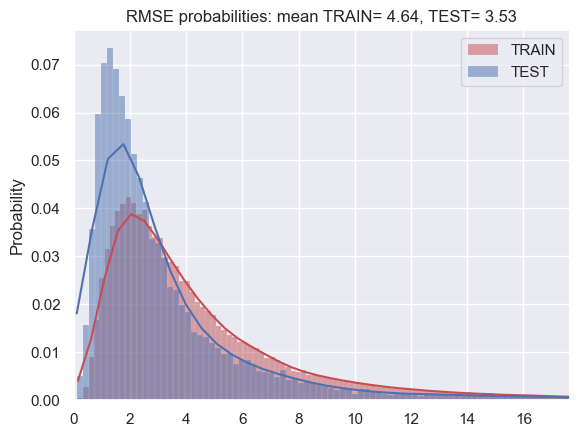

In [170]:
ax = sns.histplot(x=arr_mse_train,  stat="probability", kde=True, label="TRAIN", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="TEST", ax=ax)
plt.title(f"RMSE probabilities: mean TRAIN= {np.mean(arr_mse_train):.2f}, TEST= {np.mean(arr_mse):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_mse)*5])

Text(0.5, 1.0, 'RMSE on TEST: mean= 3.53')

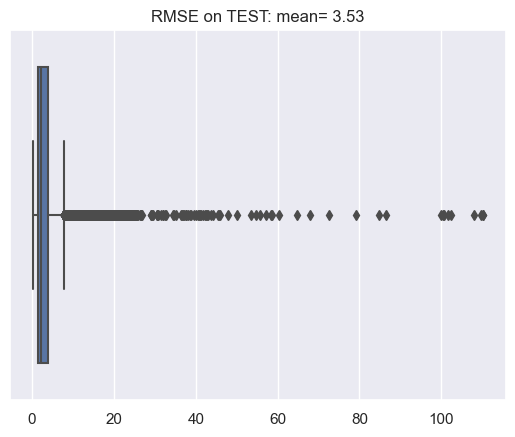

In [171]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [172]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1701.55 1702.86 1703.06 1704.73 1704.57 1704.53 1705.45 1705.02 1704.57
 1704.2  1704.5  1703.3  1703.83 1704.42 1705.21]
[1703.28380266 1703.42308541 1703.49008731 1703.42998863 1703.55282546
 1703.71789378 1703.64317651 1703.55282546 1703.40521823 1703.43303418
 1703.39466036 1703.48277801 1703.47567175 1703.50653323 1703.54998295]


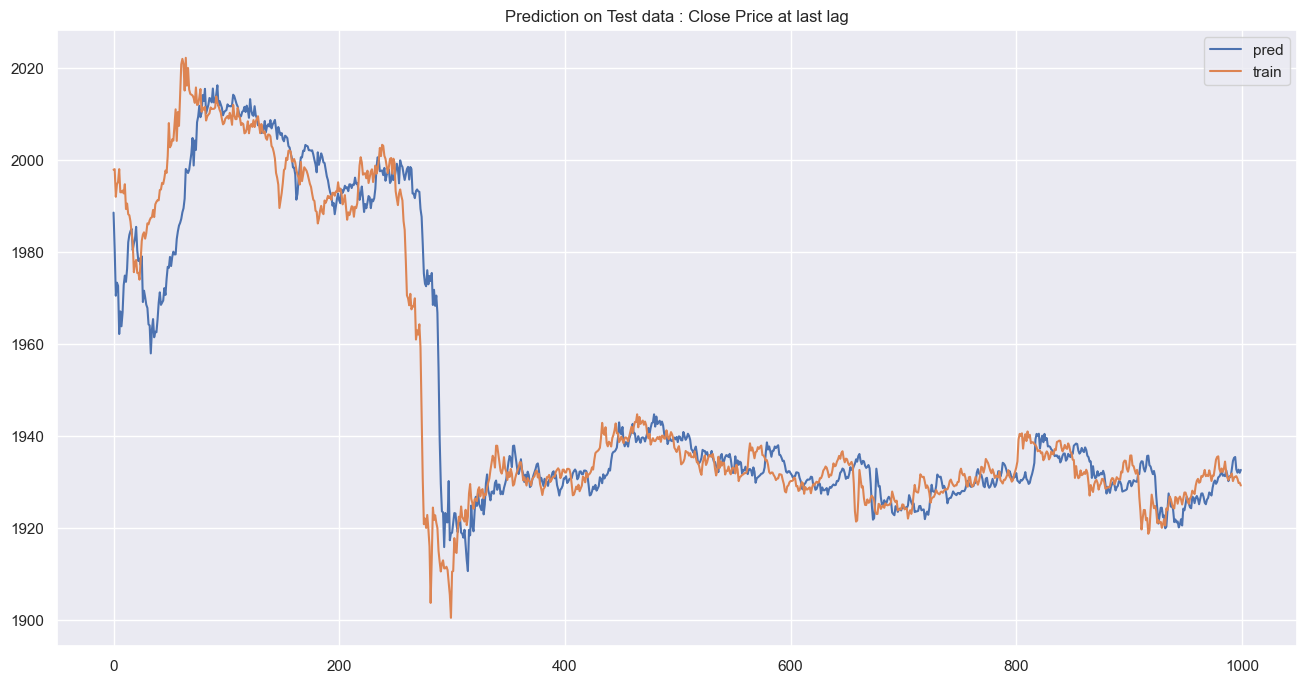

In [173]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

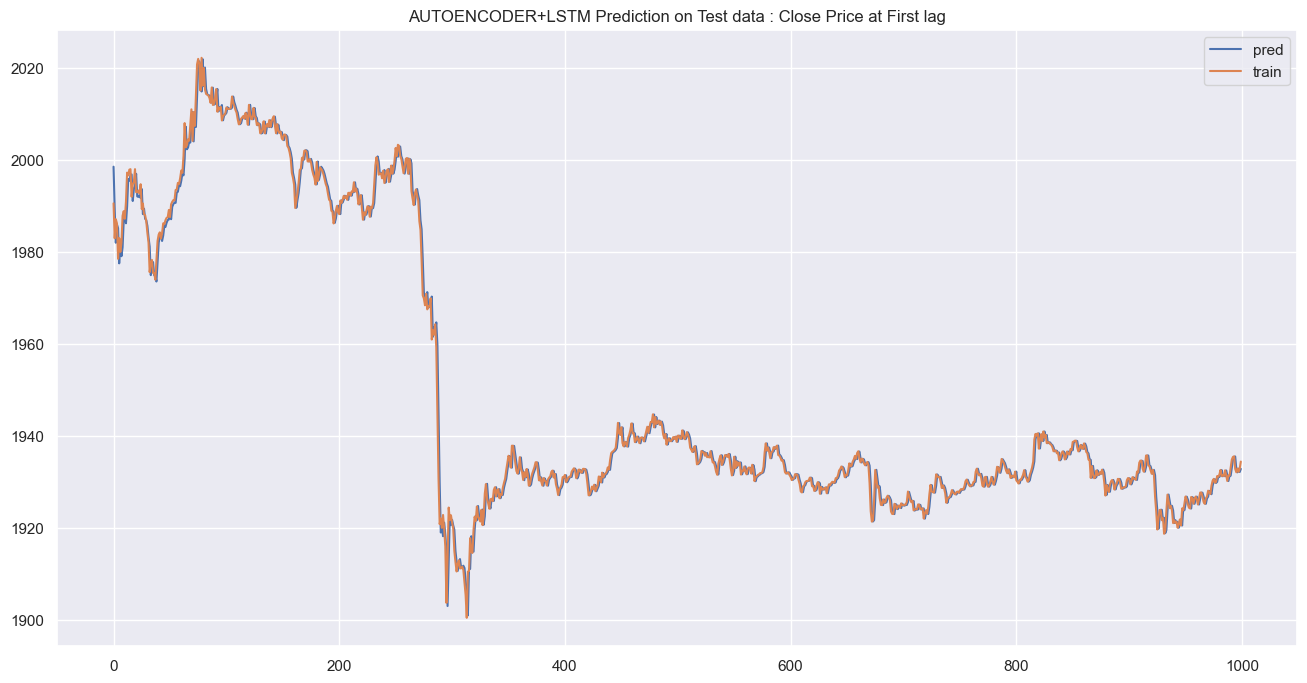

In [174]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

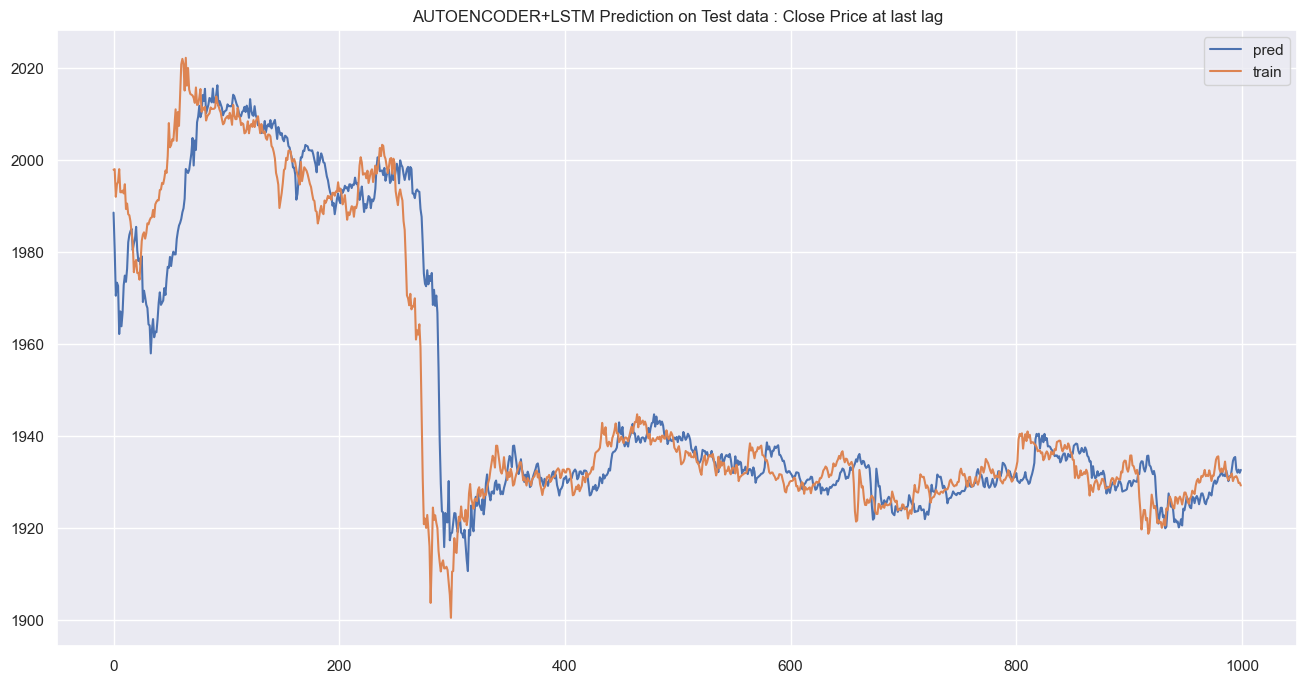

In [175]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [176]:
X_test_sca.shape

(13845, 72, 102)

In [177]:
df_feat["Close_ETH"].iloc[-1]

1704.01

In [178]:
df_feat["Close_ETH"].iloc[-1]

1704.01

In [179]:
len(list_i_enc_select)

10

In [180]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1703.11 1704.14 1706.84 1705.9  1703.14 1704.07 1703.61 1703.65 1702.28
 1700.96 1700.   1702.35 1702.68 1701.01 1698.51 1700.21 1697.96 1698.24
 1700.38 1698.62 1699.57 1701.7  1703.   1702.98 1703.74 1704.38 1703.98
 1703.18 1703.86 1700.91 1700.9  1700.81 1698.9  1698.92 1700.   1698.33
 1696.97 1698.92 1700.89 1701.38 1701.33 1701.61 1704.15 1705.01 1703.84
 1703.03 1702.83 1701.46 1701.86 1703.41 1703.54 1704.25 1703.64 1703.19
 1701.55 1702.86 1703.06 1704.73 1704.57 1704.53 1705.45 1705.02 1704.57
 1704.2  1704.5  1703.3  1703.83 1704.42 1705.21 1706.61 1705.56 1704.01]
X_last[0,:,0] after divide by price:
[0.99947183 1.00007629 1.00166079 1.00110915 0.99948944 1.00003521
 0.99976526 0.99978873 0.99898475 0.9982101  0.99764673 0.99902583
 0.99921949 0.99823945 0.99677232 0.99776997 0.99644955 0.99661387
 0.99786973 0.99683687 0.99739438 0.99864437 0.99940728 0.99939554
 0.99984155 1.00021713 0.99998239 0.99951291 0.99991197 0.99818076
 0.9

In [181]:
X_last_encoded_sca.shape

(1, 72, 16)

In [182]:
list_i_enc_select

[0, 1, 2, 4, 5, 6, 10, 12, 13, 15]

In [183]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 10)

In [184]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [185]:
X_train_.shape

(55646, 72, 14)

In [186]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
69660  1693429200000   1703.84   1704.72  1703.53    1704.42    304.2080   
69661  1693429500000   1704.42   1705.32  1704.34    1705.21    128.5311   
69662  1693429800000   1705.21   1708.34  1705.20    1706.61   1255.5185   
69663  1693430100000   1706.61   1707.69  1705.42    1705.56    412.1529   
69664  1693430400000   1705.56   1705.56  1704.01    1704.01    457.8109   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1749.198952       1748.674891   
1      2023-01-01 00:05:00       1749.198952       1748.674891   
2      2023-01-01 00:10:00       1749.198952       1748.674891   
3      2023-01-01 00:15:00       1749.198952       1748.674891   
4      2023-01-01 00:20:00       1749.198952       1748.674891   
...                    ...               ...               ...   
69660  2023-08-30 21:00:00       1700.075000       1704.125000   
69661  2023-08-30 21:05:00       1701.070000       1702.925000   
69662  2023-08-30 21:10:00       1701.070000       1702.645000   
69663  2023-08-30 21:15:00       1701.070000       1701.820000   
69664  2023-08-30 21:20:00       1701.077500       1702.245000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
69660        1703.760  ...         NaN            NaN           NaN   
69661        1703.760  ...         NaN            NaN           NaN   
69662        1704.895  ...         NaN            NaN           NaN   
69663        1704.895  ...         NaN            NaN           NaN   
69664        1704.895  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
69660               NaN         0.0               NaN         0.0      0.0   
69661               NaN         0.0               NaN         0.0      0.0   
69662               NaN         0.0               NaN         0.0      0.0   
69663               NaN         0.0               NaN         0.0      0.0   
69664               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
69660                  NaN  False  
69661                  NaN  False  
69662                  NaN  False  
69663                  NaN  False  
69664                  NaN  False  

[69665 rows x 136 columns]

In [187]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [188]:
y_last_pred_unscaled

array([[0.9999872 , 1.0000309 , 1.0000358 , 0.9999718 , 1.0000302 ,
        1.0000643 , 1.0000021 , 0.9999285 , 0.9998529 , 0.9998416 ,
        0.9998495 , 0.99985945, 0.9998657 , 0.999864  , 0.99985576]],
      dtype=float32)

In [189]:
df_feat["Close_ETH"].iloc[-1]

1704.01

In [190]:
y_last_pred_raw

array([[1703.9882, 1704.0626, 1704.0709, 1703.9619, 1704.0614, 1704.1195,
        1704.0137, 1703.8882, 1703.7594, 1703.74  , 1703.7535, 1703.7705,
        1703.7811, 1703.7782, 1703.7642]], dtype=float32)

In [191]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [192]:
list_pred

[1703.9619,
 1704.0614,
 1704.1195,
 1704.0137,
 1703.8882,
 1703.7594,
 1703.74,
 1703.7535,
 1703.7705,
 1703.7811,
 1703.7782,
 1703.7642]

In [193]:
save_list(list_pred, path_save_pred_vals)

In [194]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [195]:
list_pred_reload

[1703.9619,
 1704.0614,
 1704.1195,
 1704.0137,
 1703.8882,
 1703.7594,
 1703.74,
 1703.7535,
 1703.7705,
 1703.7811,
 1703.7782,
 1703.7642]